# 1x1 Convolutions

- [Simple test setup](#Simple-test-setup)
- [Experimentation](#Experimentation)
- [Image Size Variations](#Image-Size-Variations)
- [Input Layer Subsets](#Input-Layer-Subsets)
- [Incorporation](#Incorporation)
- [Individual Misclassified Events](#Individual-Misclassified-Events)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import pickle
from pathlib import Path
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots_1x1/'
modelpath = path_prefix+'classifier/Models/'

# import our resolution utilities
import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

inputpath = path_prefix+'inputs/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

Using TensorFlow backend.


In [3]:
np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [4]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

import tensorflow as tf
from sklearn.metrics import roc_curve, auc

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [5]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)
pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

## Simple test setup
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [6]:
filters = {
    'EMB1': (1,1), 
    'EMB2': (1,1), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}
filters2 = {
    'EMB1': (4,8), 
    'EMB2': (8,8), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools2 = {
    'EMB1': (2,2), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}

In [7]:
def cnn_model_1x1():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [8]:
model = cnn_model_1x1()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [9]:
history = model.fit(pcells_EMB2_channels[pdata_merged.train],
                    plabels[pdata_merged.train], 
                    validation_data=(pcells_EMB2_channels[pdata_merged.val], plabels[pdata_merged.val]),
                    epochs=100, batch_size=200*ngpu, verbose=2)
history = history.history

Train on 489899 samples, validate on 69988 samples
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
489899/489899 - 21s - loss: 0.3052 - acc: 0.8686 - val_loss: 0.2422 - val_acc: 0.9031
Epoch 2/100

Epoch 75/100
489899/489899 - 13s - loss: 0.1873 - acc: 0.9261 - val_loss: 0.1907 - val_acc: 0.9270
Epoch 76/100
489899/489899 - 13s - loss: 0.1869 - acc: 0.9262 - val_loss: 0.1878 - val_acc: 0.9275
Epoch 77/100
489899/489899 - 13s - loss: 0.1866 - acc: 0.9266 - val_loss: 0.1884 - val_acc: 0.9275
Epoch 78/100
489899/489899 - 13s - loss: 0.1863 - acc: 0.9269 - val_loss: 0.1884 - val_acc: 0.9272
Epoch 79/100
489899/489899 - 13s - loss: 0.1867 - acc: 0.9264 - val_loss: 0.1878 - val_acc: 0.9265
Epoch 80/100
489899/489899 - 13s - loss: 0.1866 - acc: 0.9263 - val_loss: 0.1892 - val_acc: 0.9261
Epoch 81/100
489899/489899 - 13s - loss: 0.1860 - acc: 0.9263 - val_loss: 0.1899 - val_acc: 0.9268
Epoch 82/100
489899/489899 - 13s - loss: 0.1862 - acc: 0.9266 - val_loss: 0.1898 - val_acc: 0.9268
Epoch 83/100
489899/489899 - 13s - loss: 0.1862 - acc: 0.9266 - val_loss: 0.1888 - val_acc: 0.9278
Epoch 84/100
489899/489899 - 13s - loss: 0.1856 - acc: 0.9265 - val_loss: 0.1867 - val_acc: 0.9276
Epoch 85/1

In [10]:
# save network

model.save(modelpath+"model_cnn_1x1.h5")
with open(modelpath + "model_cnn_1x1.history",'wb') as model_history_file:
    pickle.dump(history, model_history_file)

In [8]:
# load network

model = tf.keras.models.load_model(modelpath+"model_cnn_1x1.h5")
with open(modelpath + 'model_cnn_1x1.history','rb') as model_history_file:
    history = pickle.load(model_history_file)

In [12]:
# get overall performance metric
performance = model.evaluate(
    pcells_EMB2_channels[pdata_merged.test], plabels[pdata_merged.test],
    verbose = 0,
)

# get network scores for the dataset
score = model.predict(
    pcells_EMB2_channels
)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


<Figure size 576x432 with 0 Axes>

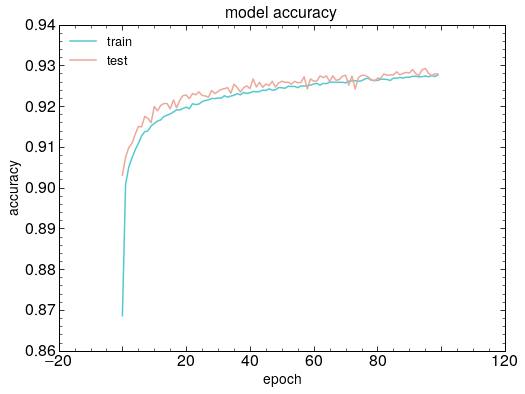

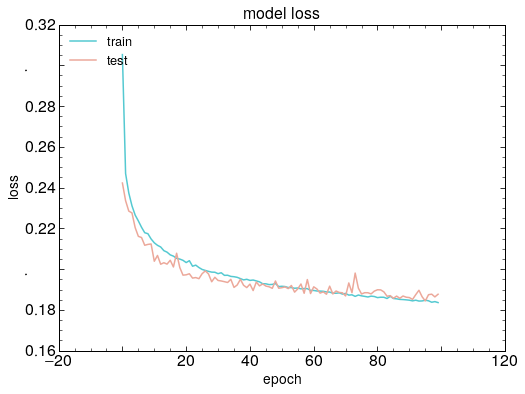

In [16]:

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plotpath + 'test_acc.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plotpath + 'test_loss.pdf')
plt.show()

In [19]:
from sklearn.metrics import roc_curve, auc

roc_fpr, roc_tpr, roc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    score[pdata_merged.test,1],
    drop_intermediate=False,
)
roc_auc = auc(roc_fpr, roc_tpr)
print('Area under curve: ' + str(roc_auc))

Area under curve: 0.9773601106216215


<Figure size 576x432 with 0 Axes>

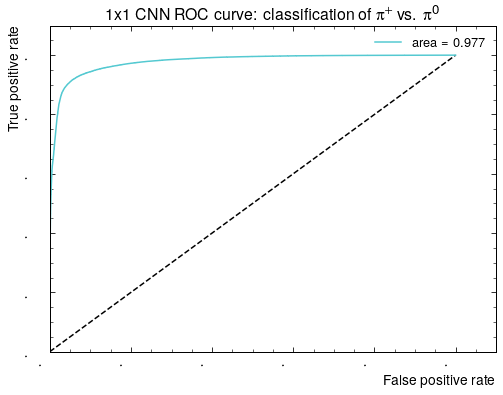

In [21]:
pu.roc_plot([roc_fpr], [roc_tpr],
            figfile=plotpath + 'roc_cnn_1x1.pdf',
            labels=['area = {:.3f}'.format(roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='1x1 CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

## Experimentation
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [24]:
def test_model(model,filename='',
               epochs=100):
    '''
    Convenience function for training and calculating
    the area-under-curve for a model
    '''
    
    # train model
    f_history = model.fit(pcells_EMB2_channels[pdata_merged.train],
                        plabels[pdata_merged.train], 
                        validation_data=(pcells_EMB2_channels[pdata_merged.val], plabels[pdata_merged.val]),
                        epochs=epochs, batch_size=200*ngpu, verbose=2)
    f_history = f_history.history
    
    # save trained weights and history
    if(filename != ''):
        model.save(modelpath+filename+".h5")
        with open(modelpath+filename +".history",'wb') as model_history_file:
            pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        pcells_EMB2_channels
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
#     f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    
#     pu.roc_plot([f_roc_fpr], [f_roc_tpr],
#             figfile=plotpath+filename+'_roc.pdf',
#             labels=['area = {:.3f}'.format(f_roc_auc)],
#             extra_lines=[[[0, 1], [0, 1]]],
#             title=filename.replace('_','-')+' ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    return f_roc_fpr, f_roc_tpr

In [25]:
# models to test
def cnn_model_1x1():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_no_maxpool():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_no_dropout():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_no_dropmax():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_4pool():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(4, 4))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [ ]:
# test models
models = [cnn_model_1x1(),
          cnn_model_1x1_no_maxpool(),
          cnn_model_1x1_no_dropout(),
          cnn_model_1x1_no_dropmax(),
          cnn_model_1x1_4pool(),
]
fnames = ['baseline','no_maxpool','no_dropout','no_dropmax','4pool']

res_fpr = []
res_tpr = []
res_auc = []
for m,n in zip(models,fnames):
    fpr, tpr = test_model(m,filename=n)
    res_fpr.append(fpr)
    res_tpr.append(tpr)
    res_auc.append( auc(fpr, tpr) )
    
pu.roc_plot(res_fpr, res_tpr,
            figfile=plotpath+'1x1_roc.pdf',
            labels=['area({}) = {:.3f}'.format(label.replace('_','-'),auc) for label,auc in zip(fnames,res_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curve: classification of $\pi^+$ vs. $\pi^0$')


In [ ]:
# models to test
def cnn_model_1x1():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_ndm_d128only():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
#         x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_ndm_d64only():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
#         x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_ndm_direct():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
#         x = Dense(128, activation='relu')(x)
#         x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model


In [ ]:
# test models
models = [cnn_model_1x1(),
          cnn_model_1x1_ndm_d128only(),
          cnn_model_1x1_ndm_d64only(),
          cnn_model_1x1_ndm_direct(),
]
fnames = ['baseline','dense128_only','dense64_only','no_dense']

res_fpr = []
res_tpr = []
res_auc = []
for m,n in zip(models,fnames):
    fpr, tpr = test_model(m,filename=n)
    res_fpr.append(fpr)
    res_tpr.append(tpr)
    res_auc.append( auc(fpr, tpr) )
    
pu.roc_plot(res_fpr, res_tpr,
            figfile=plotpath+'1x1_ndm_roc.pdf',
            labels=['area({}) = {:.3f}'.format(label.replace('_','-'),auc) for label,auc in zip(fnames,res_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curve: classification of $\pi^+$ vs. $\pi^0$')


## Image Size Variations
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [ ]:
def test_model_size(model,filename='',
               im_size=(16,16),epochs=100):
    '''
    Convenience function for training and calculating
    the area-under-curve for a model.
    This version handles testing different image sizes
    '''
    # generate resized images
    pcells_resized = mu.setupChannelImages(mu.rescaleImages(pcells_merged, im_size))
    
    # check if model has been trained already
    if Path(modelpath+filename+'.h5').is_file():
        # load model
        model = tf.keras.models.load_model(modelpath+filename+".h5")
    else:
        # train model
        f_history = model.fit(pcells_resized[pdata_merged.train],
                            plabels[pdata_merged.train], 
                            validation_data=(pcells_resized[pdata_merged.val], plabels[pdata_merged.val]),
                            epochs=epochs, batch_size=200*ngpu, verbose=2)
        f_history = f_history.history

        # save trained weights and history
        if(filename != ''):
            model.save(modelpath+filename+".h5")
            with open(modelpath+filename +".history",'wb') as model_history_file:
                pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        pcells_resized
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
#     f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    
#     pu.roc_plot([f_roc_fpr], [f_roc_tpr],
#             figfile=plotpath+filename+'_roc.pdf',
#             labels=['area = {:.3f}'.format(f_roc_auc)],
#             extra_lines=[[[0, 1], [0, 1]]],
#             title=filename.replace('_','-')+' ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    return f_roc_fpr, f_roc_tpr

In [ ]:
# models to test
def cnn_model_1x1():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_size(im_size):
    with strategy.scope():
        input1 = Input(shape=(6, im_size, im_size), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [ ]:
# test models
test_shapes = [8,12,16,20,24,28,32]
models = [ cnn_model_1x1_size(sz) for sz in test_shapes]

res_fpr = []
res_tpr = []
res_auc = []
for m,sz in zip(models,test_shapes):
    fname = 'ndm_d64_s'+str(sz)
    fpr, tpr = test_model_size(m,filename=fname,im_size=(sz,sz))
    res_fpr.append(fpr)
    res_tpr.append(tpr)
    res_auc.append( auc(fpr, tpr) )
    
pu.roc_plot(res_fpr, res_tpr,
            figfile=plotpath+'1x1_ndm_d64_s_roc.pdf',
            labels=['area('+str(sz)+'x'+str(sz)+') = {:.3f}'.format(auc) for sz,auc in zip(test_shapes,res_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='ROC curve: classification of $\pi^+$ vs. $\pi^0$')


## Input Layer Subsets
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [ ]:
def test_model_nlayers(model,subset,filename='',
               epochs=100):
    '''
    Convenience function for training and calculating
    the area-under-curve for a model.
    This version handles testing variations with
    different subsets of the 6 calo layer images.
    '''

    # check if model has been trained already
    if Path(modelpath+filename+'.h5').is_file():
        # load model
        model = tf.keras.models.load_model(modelpath+filename+".h5")
    else:
        # train model
        f_history = model.fit(subset[pdata_merged.train],
                            plabels[pdata_merged.train], 
                            validation_data=(subset[pdata_merged.val], plabels[pdata_merged.val]),
                            epochs=epochs, batch_size=200*ngpu, verbose=2)
        f_history = f_history.history

        # save trained weights and history
        if(filename != ''):
            model.save(modelpath+filename+".h5")
            with open(modelpath+filename +".history",'wb') as model_history_file:
                pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        subset
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
#     f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    
#     pu.roc_plot([f_roc_fpr], [f_roc_tpr],
#             figfile=plotpath+filename+'_roc.pdf',
#             labels=['area = {:.3f}'.format(f_roc_auc)],
#             extra_lines=[[[0, 1], [0, 1]]],
#             title=filename.replace('_','-')+' ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    return f_roc_fpr, f_roc_tpr

In [ ]:
def cnn_model_1x1_nlayers(n):
    with strategy.scope():
        input1 = Input(shape=(n, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [5]:
total_layers = 6
max_layers = 5
layer_names = np.array([ n for n in mu.cell_meta ])
base_filename = '1x1_ndm_d64_s16_lsubset'

In [ ]:
roc_data = {
    'fpr': [],
    'tpr': [],
    'auc': [],
}
for subset_id in range(1,2**total_layers):
    subset = [ (subset_id & 2**obj_pos)>0 for obj_pos in range(0,total_layers) ]
    print('Starting subset',subset_id, ':', layer_names[subset])
    
    n_layers = len(layer_names[subset])
    fpr, tpr = test_model_nlayers(cnn_model_1x1_nlayers(n_layers),
                                  pcells_EMB2_channels[:,subset],
                                  filename=base_filename+'_'+str(subset_id))
    roc_data['fpr'].append(fpr)
    roc_data['tpr'].append(tpr)
    roc_data['auc'].append( auc(fpr, tpr) )
    
with open(plotpath+base_filename+'.data','wb') as roc_file:
    pickle.dump(roc_data, roc_file)
# pu.roc_plot(res_fpr, res_tpr,
#             figfile=plotpath+'1x1_ndm_d64_s16_lsubset_roc.pdf',
#             labels=['area('+str(sz)+'x'+str(sz)+') = {:.3f}'.format(auc) for sz,auc in zip(test_shapes,res_auc)],
#             extra_lines=[[[0, 1], [0, 1]]],
#             title='ROC curve: classification of $\pi^+$ vs. $\pi^0$')


In [15]:
def count_ones(num):
    ones = 0
    while(num>0):
        num = num & (num-1)
        ones += 1
    return ones

def subset_label(subset_id):
    label = ''
    if( subset_id & int('000111',2) ):
        emb = 'EMB'
        for i in range(0,3):
            if( subset_id & 2**i > 0 ):
                emb += str(i)
        label += emb
    if( subset_id & int('111000',2) ):
        tile = 'Tile'
        for i in range(3,6):
            if( subset_id & 2**i > 0 ):
                tile += str(i-2)
        if( label != '' ):
            label += ','
        label += tile
    return label

res = [ [] for i in range(0,total_layers) ]

for subset_id in range(1,2**total_layers):
    res[count_ones(subset_id)-1].append(subset_id)
    
print(res)

[[1, 2, 4, 8, 16, 32], [3, 5, 6, 9, 10, 12, 17, 18, 20, 24, 33, 34, 36, 40, 48], [7, 11, 13, 14, 19, 21, 22, 25, 26, 28, 35, 37, 38, 41, 42, 44, 49, 50, 52, 56], [15, 23, 27, 29, 30, 39, 43, 45, 46, 51, 53, 54, 57, 58, 60], [31, 47, 55, 59, 61, 62], [63]]


<Figure size 576x432 with 0 Axes>

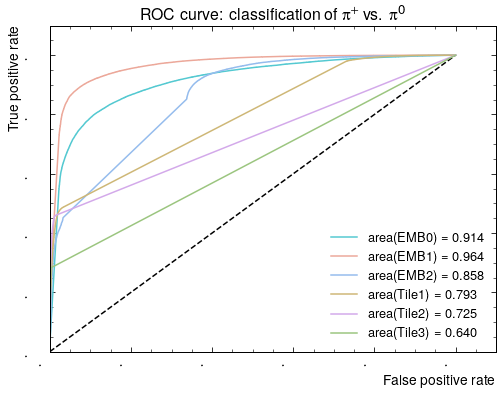

[0.914, 0.964, 0.858, 0.793, 0.725, 0.64]


<Figure size 576x432 with 0 Axes>

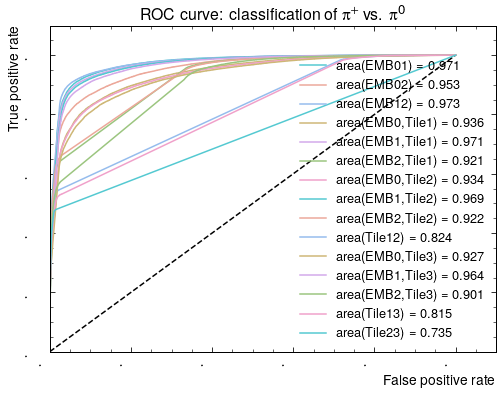

[0.971, 0.953, 0.973, 0.936, 0.971, 0.921, 0.934, 0.969, 0.922, 0.824, 0.927, 0.964, 0.901, 0.815, 0.735]


<Figure size 576x432 with 0 Axes>

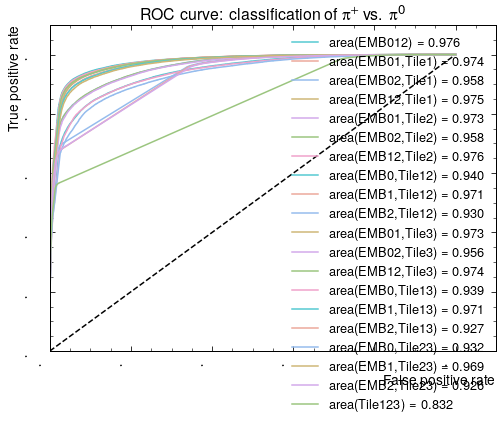

[0.976, 0.974, 0.958, 0.975, 0.973, 0.958, 0.976, 0.94, 0.971, 0.93, 0.973, 0.956, 0.974, 0.939, 0.971, 0.927, 0.932, 0.969, 0.926, 0.832]


<Figure size 576x432 with 0 Axes>

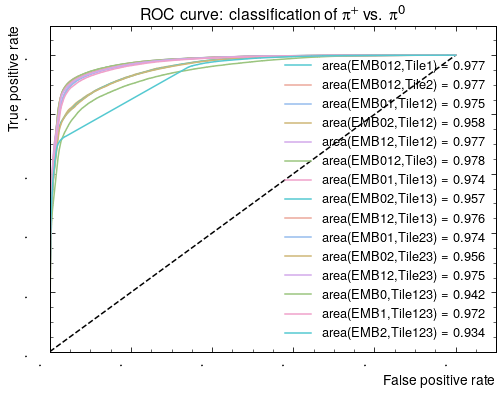

[0.977, 0.977, 0.975, 0.958, 0.977, 0.978, 0.974, 0.957, 0.976, 0.974, 0.956, 0.975, 0.942, 0.972, 0.934]


<Figure size 576x432 with 0 Axes>

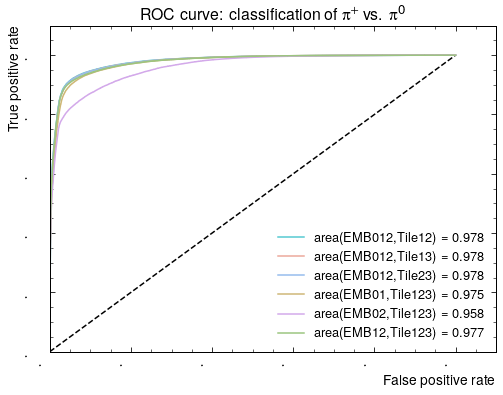

[0.978, 0.978, 0.978, 0.975, 0.958, 0.977]


<Figure size 576x432 with 0 Axes>

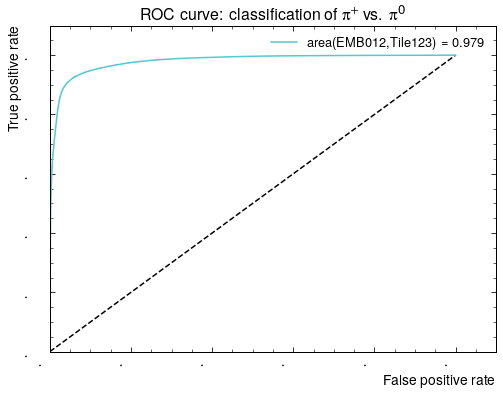

[0.979]


In [17]:
with open(plotpath + base_filename + '.data','rb') as roc_file:
    roc_data = pickle.load(roc_file)
    
for i,order in enumerate(res):
    pu.roc_plot([ roc_data['fpr'][subset_id-1] for subset_id in order ],
                [ roc_data['tpr'][subset_id-1] for subset_id in order ],
                figfile=plotpath+'1x1_ndm_d64_s16_lsubset'+str(i)+'_roc.pdf',
                labels=['area('+subset_label(subset_id)+') = {:.3f}'.format(roc_data['auc'][subset_id-1]) for subset_id in order],
                extra_lines=[[[0, 1], [0, 1]]],
                title='ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    print([ round(roc_data['auc'][subset_id-1],3) for subset_id in order ])

In [14]:
for order in res:
    print([subset_label(subset_id) for subset_id in order])

['EMB0', 'EMB1', 'EMB2', 'Tile1', 'Tile2', 'Tile3']
['EMB01', 'EMB02', 'EMB12', 'EMB0,Tile1', 'EMB1,Tile1', 'EMB2,Tile1', 'EMB0,Tile2', 'EMB1,Tile2', 'EMB2,Tile2', 'Tile12', 'EMB0,Tile3', 'EMB1,Tile3', 'EMB2,Tile3', 'Tile13', 'Tile23']
['EMB012', 'EMB01,Tile1', 'EMB02,Tile1', 'EMB12,Tile1', 'EMB01,Tile2', 'EMB02,Tile2', 'EMB12,Tile2', 'EMB0,Tile12', 'EMB1,Tile12', 'EMB2,Tile12', 'EMB01,Tile3', 'EMB02,Tile3', 'EMB12,Tile3', 'EMB0,Tile13', 'EMB1,Tile13', 'EMB2,Tile13', 'EMB0,Tile23', 'EMB1,Tile23', 'EMB2,Tile23', 'Tile123']
['EMB012,Tile1', 'EMB012,Tile2', 'EMB01,Tile12', 'EMB02,Tile12', 'EMB12,Tile12', 'EMB012,Tile3', 'EMB01,Tile13', 'EMB02,Tile13', 'EMB12,Tile13', 'EMB01,Tile23', 'EMB02,Tile23', 'EMB12,Tile23', 'EMB0,Tile123', 'EMB1,Tile123', 'EMB2,Tile123']
['EMB012,Tile12', 'EMB012,Tile13', 'EMB012,Tile23', 'EMB01,Tile123', 'EMB02,Tile123', 'EMB12,Tile123']
['EMB012,Tile123']


## Incorporation
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [ ]:
def test_model_incorporated(model,filename='',
               epochs=100):
    '''
    Convenience function for training and calculating
    the area-under-curve for a model.
    '''
    
    # check if model has been trained already
    if Path(modelpath+filename+'.h5').is_file():
        # load model
        model = tf.keras.models.load_model(modelpath+filename+".h5")
    else:
        # train model
        f_history = model.fit([pcells_EMB2_channels[pdata_merged.train], 
                               pcells_EMB1_flat[pdata_merged.train]],
                            plabels[pdata_merged.train], 
                            validation_data=([pcells_EMB2_channels[pdata_merged.val],
                                              pcells_EMB1_flat[pdata_merged.val]],
                                             plabels[pdata_merged.val]),
                            epochs=epochs, batch_size=200*ngpu, verbose=2)
        f_history = f_history.history

        # save trained weights and history
        if(filename != ''):
            model.save(modelpath+filename+".h5")
            with open(modelpath+filename +".history",'wb') as model_history_file:
                pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        [pcells_EMB2_channels, pcells_EMB1_flat]
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
    f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    
    pu.roc_plot([f_roc_fpr], [f_roc_tpr],
            figfile=plotpath+filename+'_roc.pdf',
            labels=['area = {:.3f}'.format(f_roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title=filename.replace('_','-')+' ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    return f_roc_fpr, f_roc_tpr

In [ ]:
def cnn_model_1x1_incorporated():
    # original network: channels_EMB2G_EMB1F_model_all4
    with strategy.scope():
        input1 = Input(shape=(6, 16, 16), name='input1')

        # baseline layers
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Convolution2D(32, (2, 2), activation='relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first')(input1)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Convolution2D(32, (2, 2), activation='relu')(x1_2)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Flatten()(x1_2)
        x1_2 = Dense(128, activation='relu')(x1_2)
        x1_2 = Dropout(0.2)(x1_2)
        x1_2 = Dense(64, activation='relu')(x1_2)
        
        # 1x1 convolution layers
        depth = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        depth = Flatten()(depth)
        depth = Dense(64, activation='relu')(depth)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x1_2, x2, depth]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)  

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model
    
def cnn_model_1x1_incorporated2():
    # original network: channels_EMB2G_EMB1F_model_all4
    with strategy.scope():
        input1 = Input(shape=(6, 16, 16), name='input1')

        # baseline layers
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Convolution2D(32, (2, 2), activation='relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first')(input1)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Convolution2D(32, (2, 2), activation='relu')(x1_2)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Flatten()(x1_2)
        x1_2 = Dense(128, activation='relu')(x1_2)
        x1_2 = Dropout(0.2)(x1_2)
        x1_2 = Dense(64, activation='relu')(x1_2)
        
        # 1x1 convolution layers
        depth = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        depth = Flatten()(depth)
        depth = Dense(64, activation='relu')(depth)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x1_2, depth, x2]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)  

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model
    
def cnn_model_1x1_incorporated3():
    # original network: channels_EMB2G_EMB1F_model_all4
    with strategy.scope():
        input1 = Input(shape=(6, 16, 16), name='input1')

        # baseline layers
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Convolution2D(32, (2, 2), activation='relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first')(input1)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Convolution2D(32, (2, 2), activation='relu')(x1_2)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Flatten()(x1_2)
        x1_2 = Dense(128, activation='relu')(x1_2)
        x1_2 = Dropout(0.2)(x1_2)
        x1_2 = Dense(64, activation='relu')(x1_2)
        
        # 1x1 convolution layers
        depth = Convolution2D(64, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        depth = Flatten()(depth)
        depth = Dense(64, activation='relu')(depth)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x1_2, x2, depth]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)  

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [10]:
pcells_EMB1_flat = pcells_merged['EMB1'].reshape(len(pcells_merged['EMB1']), 128 * 4)

In [ ]:
# test model
test_model_incorporated(cnn_model_1x1_incorporated(),
                        filename='1x1_incorporated')

In [ ]:
test_model_incorporated(cnn_model_1x1_incorporated2(),
                        filename='1x1_incorporated2')

In [ ]:
test_model_incorporated(cnn_model_1x1_incorporated(),
                        filename='1x1_incorporated_250',
                        epochs=250)

In [ ]:
test_model_incorporated(cnn_model_1x1_incorporated3(),
                        filename='1x1_incorporated3_250',
                        epochs=250)

## Individual Misclassified Events
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [6]:
def cnn_model_1x1_ndm_d64only():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
#         x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def channels_EMB2G_EMB1F_model_all4():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')

        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Convolution2D(32, (2, 2), activation='relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        x1_2 = Convolution2D(64, (2, 2), activation='relu', data_format = 'channels_first')(input1)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Convolution2D(32, (2, 2), activation='relu')(x1_2)
        x1_2 = MaxPool2D(pool_size=(2, 2))(x1_2)
        x1_2 = Flatten()(x1_2)
        x1_2 = Dense(128, activation='relu')(x1_2)
        x1_2 = Dropout(0.2)(x1_2)
        x1_2 = Dense(64, activation='relu')(x1_2)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x1_2, x2]) 
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)    
        x = Dense(64, activation='relu')(x)  

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model

In [7]:
filename_baseline = 'channels_EMB2G_EMB1F_model_all4'
epochs = 250

pcells_EMB1_flat = pcells_merged['EMB1'].reshape(len(pcells_merged['EMB1']), 128 * 4)

model = channels_EMB2G_EMB1F_model_all4()
history = model.fit([pcells_EMB2_channels[pdata_merged.train], 
                       pcells_EMB1_flat[pdata_merged.train]],
                    plabels[pdata_merged.train], 
                    validation_data=([pcells_EMB2_channels[pdata_merged.val],
                                      pcells_EMB1_flat[pdata_merged.val]],
                                     plabels[pdata_merged.val]),
                    epochs=epochs, batch_size=200*ngpu, verbose=2)
# history = history.history

# save trained weights and history
model.save(modelpath+filename_baseline+".h5")
#     with open(modelpath+filename +".history",'wb') as model_history_file:
#         pickle.dump(f_history, model_history_file)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 489899 samples, validate on 69988 samples
Epoch 1/250
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:l

Epoch 66/250
489899/489899 - 26s - loss: 0.1583 - accuracy: 0.9426 - val_loss: 0.1615 - val_accuracy: 0.9427
Epoch 67/250
489899/489899 - 26s - loss: 0.1584 - accuracy: 0.9427 - val_loss: 0.1615 - val_accuracy: 0.9435
Epoch 68/250
489899/489899 - 26s - loss: 0.1586 - accuracy: 0.9427 - val_loss: 0.1599 - val_accuracy: 0.9434
Epoch 69/250
489899/489899 - 26s - loss: 0.1580 - accuracy: 0.9428 - val_loss: 0.1589 - val_accuracy: 0.9437
Epoch 70/250
489899/489899 - 26s - loss: 0.1578 - accuracy: 0.9429 - val_loss: 0.1611 - val_accuracy: 0.9437
Epoch 71/250
489899/489899 - 25s - loss: 0.1571 - accuracy: 0.9431 - val_loss: 0.1596 - val_accuracy: 0.9433
Epoch 72/250
489899/489899 - 26s - loss: 0.1571 - accuracy: 0.9431 - val_loss: 0.1611 - val_accuracy: 0.9432
Epoch 73/250
489899/489899 - 28s - loss: 0.1568 - accuracy: 0.9433 - val_loss: 0.1602 - val_accuracy: 0.9439
Epoch 74/250
489899/489899 - 28s - loss: 0.1565 - accuracy: 0.9435 - val_loss: 0.1592 - val_accuracy: 0.9437
Epoch 75/250
489899

Epoch 141/250
489899/489899 - 25s - loss: 0.1460 - accuracy: 0.9473 - val_loss: 0.1552 - val_accuracy: 0.9462
Epoch 142/250
489899/489899 - 25s - loss: 0.1462 - accuracy: 0.9471 - val_loss: 0.1542 - val_accuracy: 0.9466
Epoch 143/250
489899/489899 - 26s - loss: 0.1461 - accuracy: 0.9472 - val_loss: 0.1545 - val_accuracy: 0.9466
Epoch 144/250
489899/489899 - 25s - loss: 0.1458 - accuracy: 0.9474 - val_loss: 0.1565 - val_accuracy: 0.9457
Epoch 145/250
489899/489899 - 25s - loss: 0.1457 - accuracy: 0.9475 - val_loss: 0.1603 - val_accuracy: 0.9459
Epoch 146/250
489899/489899 - 25s - loss: 0.1450 - accuracy: 0.9476 - val_loss: 0.1589 - val_accuracy: 0.9462
Epoch 147/250
489899/489899 - 25s - loss: 0.1460 - accuracy: 0.9474 - val_loss: 0.1555 - val_accuracy: 0.9464
Epoch 148/250
489899/489899 - 25s - loss: 0.1450 - accuracy: 0.9478 - val_loss: 0.1537 - val_accuracy: 0.9470
Epoch 149/250
489899/489899 - 25s - loss: 0.1451 - accuracy: 0.9477 - val_loss: 0.1553 - val_accuracy: 0.9470
Epoch 150/

Epoch 216/250
489899/489899 - 30s - loss: 0.1385 - accuracy: 0.9500 - val_loss: 0.1554 - val_accuracy: 0.9476
Epoch 217/250
489899/489899 - 30s - loss: 0.1389 - accuracy: 0.9499 - val_loss: 0.1553 - val_accuracy: 0.9475
Epoch 218/250
489899/489899 - 30s - loss: 0.1390 - accuracy: 0.9497 - val_loss: 0.1561 - val_accuracy: 0.9476
Epoch 219/250
489899/489899 - 30s - loss: 0.1389 - accuracy: 0.9497 - val_loss: 0.1539 - val_accuracy: 0.9488
Epoch 220/250
489899/489899 - 30s - loss: 0.1389 - accuracy: 0.9499 - val_loss: 0.1550 - val_accuracy: 0.9479
Epoch 221/250
489899/489899 - 30s - loss: 0.1388 - accuracy: 0.9501 - val_loss: 0.1582 - val_accuracy: 0.9483
Epoch 222/250
489899/489899 - 30s - loss: 0.1386 - accuracy: 0.9501 - val_loss: 0.1538 - val_accuracy: 0.9484
Epoch 223/250
489899/489899 - 30s - loss: 0.1386 - accuracy: 0.9503 - val_loss: 0.1575 - val_accuracy: 0.9476
Epoch 224/250
489899/489899 - 30s - loss: 0.1385 - accuracy: 0.9500 - val_loss: 0.1540 - val_accuracy: 0.9479
Epoch 225/

In [11]:
filename_depth = 'dense64_only'
filename_baseline = 'channels_EMB2G_EMB1F_model_all4'

model_depth = tf.keras.models.load_model(modelpath+filename_depth+".h5")
depth_scores = model_depth.predict(
    pcells_EMB2_channels
)

model_baseline = tf.keras.models.load_model(modelpath+filename_baseline+".h5")
baseline_scores = model_baseline.predict(
    [pcells_EMB2_channels, pcells_EMB1_flat]
)

In [11]:
sel = pdata_merged.test

misclassified_events = []
for i,evt in enumerate(plabels[sel]):
    if(plabels[sel][i][0]>0.5 and 
       depth_scores[sel][i][0]<depth_scores[sel][i][1] and
       baseline_scores[sel][i][0]>baseline_scores[sel][i][1]
      ):
        misclassified_events.append(i)
        print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])
        continue

    if(plabels[sel][i][0]<0.5 and 
       depth_scores[sel][i][0]>depth_scores[sel][i][1] and
       baseline_scores[sel][i][0]<baseline_scores[sel][i][1]
      ):
        misclassified_events.append(i)
        print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])
#     print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])

28 [1. 0.] [9.9978191e-01 2.1813909e-04] [0.48269066 0.51730937]
30 [1. 0.] [0.6789172 0.3210828] [0.33136493 0.66863513]
47 [1. 0.] [9.9952114e-01 4.7887594e-04] [0.40149668 0.5985033 ]
89 [1. 0.] [0.739686   0.26031402] [0.20070438 0.7992956 ]
101 [1. 0.] [0.98485476 0.01514516] [0.44295922 0.5570408 ]
108 [1. 0.] [0.81839377 0.1816063 ] [0.1301832 0.8698168]
120 [1. 0.] [0.71474797 0.285252  ] [0.41314885 0.5868512 ]
136 [1. 0.] [0.743762   0.25623798] [0.44521847 0.5547815 ]
142 [1. 0.] [0.8686936  0.13130642] [0.46575648 0.5342436 ]
145 [1. 0.] [0.5421584  0.45784155] [0.35698482 0.6430152 ]
184 [1. 0.] [0.83980674 0.1601933 ] [0.40455198 0.59544796]
224 [1. 0.] [0.50480086 0.49519914] [0.2723012  0.72769874]
229 [1. 0.] [0.62911093 0.37088904] [0.4712277 0.5287723]
233 [1. 0.] [0.8746349  0.12536502] [0.43046945 0.5695305 ]
234 [1. 0.] [0.6240533  0.37594673] [0.321058   0.67894197]
237 [1. 0.] [0.6017173 0.3982827] [0.49934644 0.50065356]
243 [1. 0.] [0.57227635 0.4277236 ] [0.2

3464 [1. 0.] [0.6486332  0.35136688] [0.46340296 0.5365971 ]
3551 [1. 0.] [0.71769816 0.28230184] [0.48017895 0.51982105]
3568 [1. 0.] [9.9975735e-01 2.4260380e-04] [0.42611212 0.5738879 ]
3609 [1. 0.] [0.67906874 0.3209313 ] [0.2874581  0.71254194]
3613 [1. 0.] [0.5594396  0.44056043] [0.4393928 0.5606072]
3619 [1. 0.] [0.56316566 0.4368344 ] [0.37037334 0.6296267 ]
3648 [1. 0.] [0.5747535  0.42524648] [0.3743377  0.62566227]
3665 [1. 0.] [0.94584227 0.05415772] [0.4834598  0.51654017]
3683 [1. 0.] [0.63235426 0.36764574] [0.48345459 0.5165454 ]
3699 [1. 0.] [0.5289269  0.47107312] [0.32971182 0.67028815]
3717 [1. 0.] [0.8968236  0.10317637] [0.33254743 0.6674526 ]
3792 [1. 0.] [0.6389341 0.3610659] [0.35998926 0.6400107 ]
3814 [1. 0.] [0.71014154 0.2898585 ] [0.4675269 0.5324731]
3865 [1. 0.] [0.63570833 0.36429167] [0.39721408 0.6027859 ]
3869 [1. 0.] [0.6035651 0.3964349] [0.29602167 0.7039783 ]
3871 [1. 0.] [0.76716226 0.23283775] [0.45062372 0.5493763 ]
3894 [1. 0.] [0.73515433 0

6475 [1. 0.] [0.66648245 0.33351752] [0.49642652 0.5035735 ]
6519 [1. 0.] [0.83256793 0.1674321 ] [0.47166896 0.52833104]
6528 [1. 0.] [0.53239274 0.46760723] [0.49325594 0.506744  ]
6549 [1. 0.] [0.8101574  0.18984264] [0.35284528 0.6471547 ]
6555 [1. 0.] [0.79833484 0.20166518] [0.33282277 0.6671772 ]
6580 [1. 0.] [0.8765978  0.12340222] [0.46464592 0.535354  ]
6591 [1. 0.] [0.6201907  0.37980932] [0.38131556 0.6186845 ]
6613 [1. 0.] [0.50348485 0.49651515] [0.08521231 0.9147877 ]
6707 [1. 0.] [0.89429843 0.10570151] [0.36383805 0.6361619 ]
6746 [1. 0.] [0.8182936  0.18170643] [0.30132994 0.6986701 ]
6789 [1. 0.] [0.73059183 0.26940817] [0.31486398 0.685136  ]
6799 [1. 0.] [0.67169315 0.32830682] [0.24931166 0.7506884 ]
6818 [1. 0.] [0.72525674 0.2747433 ] [0.4915169 0.5084831]
6829 [1. 0.] [0.5161567 0.4838433] [0.48950943 0.5104906 ]
6831 [1. 0.] [0.7139839  0.28601614] [0.23199944 0.7680006 ]
6839 [1. 0.] [0.76778316 0.2322168 ] [0.49748975 0.50251025]
6844 [1. 0.] [0.8504962 0.14

9592 [1. 0.] [0.9667558  0.03324415] [0.36312398 0.63687605]
9599 [1. 0.] [0.91366065 0.08633934] [0.48679057 0.5132094 ]
9613 [1. 0.] [0.6593854  0.34061462] [0.31824276 0.6817572 ]
9629 [1. 0.] [0.6053455  0.39465454] [0.44765455 0.5523454 ]
9630 [1. 0.] [0.6778824  0.32211763] [0.29302076 0.7069793 ]
9648 [1. 0.] [0.99207366 0.00792632] [0.47358876 0.5264113 ]
9663 [1. 0.] [0.59296966 0.40703037] [0.29039162 0.7096084 ]
9669 [1. 0.] [0.89651823 0.10348179] [0.359735 0.640265]
9780 [1. 0.] [0.82050645 0.17949349] [0.46389377 0.5361063 ]
9805 [1. 0.] [0.64998746 0.3500125 ] [0.27741706 0.7225829 ]
9842 [1. 0.] [0.72826636 0.27173364] [0.3913764 0.6086236]
9877 [1. 0.] [0.6992738  0.30072612] [0.4968279  0.50317216]
9906 [1. 0.] [0.67746377 0.32253623] [0.3750201 0.6249799]
9932 [1. 0.] [0.8240833  0.17591667] [0.2932252  0.70677483]
9964 [1. 0.] [0.5040744 0.4959256] [0.35925797 0.64074206]
9986 [1. 0.] [0.96760845 0.03239156] [0.38328585 0.6167142 ]
9998 [1. 0.] [0.5532602  0.4467397

12651 [1. 0.] [0.5035402 0.4964598] [0.49904233 0.50095767]
12682 [1. 0.] [0.6522553  0.34774467] [0.39812303 0.601877  ]
12715 [1. 0.] [0.8619668  0.13803326] [0.48688272 0.51311725]
12751 [1. 0.] [0.6583589  0.34164113] [0.13684115 0.8631589 ]
12776 [1. 0.] [0.9049534 0.0950466] [0.29185453 0.7081455 ]
12795 [1. 0.] [9.9961108e-01 3.8896853e-04] [0.49222347 0.5077765 ]
12804 [1. 0.] [0.98597413 0.01402584] [0.16089045 0.8391096 ]
12843 [1. 0.] [0.5161567 0.4838433] [0.08162756 0.91837245]
12905 [1. 0.] [0.7784249  0.22157508] [0.1831059 0.8168941]
12915 [1. 0.] [0.96403295 0.035967  ] [0.48323604 0.5167639 ]
13023 [1. 0.] [0.68388546 0.31611452] [0.49171528 0.50828475]
13039 [1. 0.] [0.50403196 0.49596807] [0.1910768 0.8089232]
13047 [1. 0.] [0.8153917  0.18460825] [0.04448771 0.95551234]
13057 [1. 0.] [0.6480343 0.3519657] [0.26164767 0.73835236]
13064 [1. 0.] [0.6156587 0.3843413] [0.2596456 0.7403544]
13091 [1. 0.] [0.53705996 0.46294   ] [0.47545296 0.52454704]
13105 [1. 0.] [0.9

15944 [1. 0.] [0.56252307 0.43747696] [0.49106526 0.50893474]
15947 [1. 0.] [0.518341   0.48165897] [0.28768444 0.7123155 ]
15965 [1. 0.] [0.9907815  0.00921857] [0.14630997 0.8536901 ]
15984 [1. 0.] [0.97400475 0.02599521] [0.37991503 0.620085  ]
15991 [1. 0.] [0.62571657 0.37428337] [0.04238629 0.9576137 ]
15996 [1. 0.] [0.69339806 0.30660194] [0.48628643 0.51371354]
16002 [1. 0.] [0.52720195 0.47279802] [0.32972494 0.67027503]
16067 [1. 0.] [9.99893427e-01 1.06561594e-04] [0.23274197 0.767258  ]
16140 [1. 0.] [0.7024378 0.2975622] [0.26358023 0.7364198 ]
16145 [1. 0.] [0.58507806 0.4149219 ] [0.4306454  0.56935465]
16169 [1. 0.] [0.5720536  0.42794642] [0.33356172 0.6664383 ]
16172 [1. 0.] [0.59067965 0.40932038] [0.18829055 0.81170946]
16177 [1. 0.] [0.83220816 0.16779187] [0.4702823  0.52971774]
16188 [1. 0.] [0.64618725 0.35381278] [0.463615 0.536385]
16196 [1. 0.] [0.9076578  0.09234224] [0.39553615 0.6044639 ]
16232 [1. 0.] [0.65800613 0.3419939 ] [0.4064223  0.59357774]
16248 

18955 [1. 0.] [0.656912   0.34308794] [0.27415055 0.72584945]
18974 [1. 0.] [0.97883695 0.02116312] [0.26148406 0.7385159 ]
18983 [1. 0.] [0.53412145 0.46587852] [0.40176922 0.59823084]
18986 [1. 0.] [0.85716486 0.14283511] [0.42907968 0.5709203 ]
18995 [1. 0.] [0.6699174 0.3300826] [0.37743744 0.6225625 ]
19018 [1. 0.] [0.6418315 0.3581685] [0.17829655 0.8217035 ]
19033 [1. 0.] [0.75690985 0.2430901 ] [0.22181018 0.77818984]
19039 [1. 0.] [0.6636767  0.33632326] [0.41979453 0.5802055 ]
19097 [1. 0.] [0.6153773  0.38462272] [0.46861148 0.5313885 ]
19100 [1. 0.] [0.84388715 0.15611283] [8.7428855e-04 9.9912578e-01]
19105 [1. 0.] [0.83665544 0.16334458] [0.45677704 0.54322296]
19131 [1. 0.] [0.6609256  0.33907437] [0.46067187 0.5393281 ]
19159 [1. 0.] [0.5682893  0.43171072] [0.39512804 0.6048719 ]
19192 [1. 0.] [0.97394806 0.02605188] [0.276347 0.723653]
19217 [1. 0.] [0.6470552 0.3529448] [0.49588114 0.50411886]
19237 [1. 0.] [0.81903076 0.18096924] [0.4656187 0.5343813]
19339 [1. 0.] 

22235 [1. 0.] [0.5027213  0.49727866] [0.44278806 0.55721194]
22239 [1. 0.] [0.77614623 0.22385378] [0.49004805 0.50995195]
22282 [1. 0.] [0.7508587  0.24914129] [0.4592532 0.5407468]
22296 [1. 0.] [0.8480419  0.15195818] [0.48468363 0.5153164 ]
22319 [1. 0.] [0.9741355  0.02586456] [0.03925558 0.9607444 ]
22322 [1. 0.] [0.65846425 0.34153572] [0.41373402 0.586266  ]
22357 [1. 0.] [0.5958567 0.4041433] [0.43030104 0.5696989 ]
22359 [1. 0.] [0.61337435 0.38662568] [0.4983709 0.5016291]
22388 [1. 0.] [0.74070144 0.2592986 ] [0.41404846 0.58595157]
22460 [1. 0.] [0.6909844 0.3090156] [0.18456921 0.81543076]
22481 [1. 0.] [0.6446131  0.35538694] [0.2413432 0.7586568]
22487 [1. 0.] [0.66160023 0.3383998 ] [0.31836364 0.68163633]
22495 [1. 0.] [0.560081 0.439919] [0.25963977 0.74036026]
22525 [1. 0.] [0.6527011 0.3472989] [0.4678521  0.53214794]
22581 [1. 0.] [0.56133366 0.4386664 ] [0.4416395  0.55836046]
22589 [1. 0.] [0.665599   0.33440104] [0.18514447 0.8148556 ]
22619 [1. 0.] [0.7536053

25653 [1. 0.] [0.75525045 0.24474955] [0.2540991  0.74590087]
25655 [1. 0.] [0.9445232  0.05547683] [0.3031313 0.6968687]
25657 [1. 0.] [0.94896954 0.0510305 ] [0.44853237 0.55146766]
25719 [1. 0.] [0.707189   0.29281104] [0.3224745  0.67752546]
25734 [1. 0.] [0.6306344  0.36936563] [0.27188787 0.7281121 ]
25760 [1. 0.] [0.73546374 0.26453632] [0.38100058 0.6189994 ]
25773 [1. 0.] [0.51356494 0.48643503] [0.36043888 0.6395611 ]
25778 [1. 0.] [0.90436727 0.0956327 ] [0.47065353 0.5293465 ]
25809 [1. 0.] [0.5494153  0.45058474] [0.39443755 0.60556245]
25810 [1. 0.] [0.7366213  0.26337868] [0.48687518 0.5131248 ]
25824 [1. 0.] [0.52267766 0.47732234] [0.20332016 0.79667985]
25860 [1. 0.] [9.9967480e-01 3.2527267e-04] [0.25642607 0.7435739 ]
25872 [1. 0.] [0.82238054 0.17761947] [0.38501805 0.61498195]
25934 [1. 0.] [0.6209061  0.37909392] [0.4865163 0.5134837]
25951 [1. 0.] [0.6624628 0.3375372] [0.2835011 0.716499 ]
25952 [1. 0.] [0.984583   0.01541694] [0.491124   0.50887597]
25972 [1. 

28625 [1. 0.] [0.5863886  0.41361144] [0.35648707 0.6435129 ]
28635 [1. 0.] [0.99104077 0.00895925] [0.48921722 0.5107828 ]
28678 [1. 0.] [0.53858864 0.46141136] [0.43540314 0.5645969 ]
28712 [1. 0.] [0.89567184 0.10432819] [0.49951786 0.50048214]
28744 [1. 0.] [0.50907737 0.49092263] [0.1703293 0.8296707]
28745 [1. 0.] [0.61214024 0.3878598 ] [0.4281258 0.5718742]
28784 [1. 0.] [0.9985697  0.00143021] [0.02640948 0.97359055]
28797 [1. 0.] [0.71494496 0.285055  ] [0.43115202 0.568848  ]
28842 [1. 0.] [0.93507695 0.06492307] [0.44681308 0.5531869 ]
28901 [1. 0.] [0.6735171 0.3264829] [0.47463503 0.525365  ]
28902 [1. 0.] [0.7862252  0.21377476] [0.46959478 0.5304052 ]
28910 [1. 0.] [0.75615036 0.24384966] [0.4814884 0.5185116]
28914 [1. 0.] [0.8160504  0.18394963] [0.46832237 0.5316776 ]
28948 [1. 0.] [0.6765601 0.3234399] [0.40961468 0.5903853 ]
28971 [1. 0.] [0.9098229  0.09017713] [0.38948432 0.6105157 ]
29002 [1. 0.] [0.7564591  0.24354085] [0.28742334 0.7125767 ]
29006 [1. 0.] [0.9

32079 [1. 0.] [0.8587511 0.1412489] [0.474663   0.52533704]
32118 [1. 0.] [0.55899054 0.44100946] [0.4912665  0.50873345]
32139 [1. 0.] [0.6868189  0.31318107] [0.47146747 0.5285325 ]
32152 [1. 0.] [0.6381569 0.3618431] [0.45476824 0.54523176]
32156 [1. 0.] [0.6604293  0.33957064] [0.34471807 0.6552819 ]
32158 [1. 0.] [0.9252336  0.07476648] [0.3652632 0.6347368]
32201 [1. 0.] [0.6602989  0.33970112] [0.48729447 0.5127055 ]
32306 [1. 0.] [0.56229687 0.43770307] [0.26588452 0.7341155 ]
32330 [1. 0.] [0.8566757  0.14332424] [0.4488828  0.55111724]
32348 [1. 0.] [0.62805015 0.37194985] [0.4460571 0.5539429]
32356 [1. 0.] [0.65119946 0.34880054] [0.487098 0.512902]
32390 [1. 0.] [0.6515439 0.3484561] [0.49663836 0.5033617 ]
32392 [1. 0.] [0.66741383 0.33258617] [0.45423478 0.5457652 ]
32403 [1. 0.] [0.9157466  0.08425339] [0.31468946 0.68531054]
32404 [1. 0.] [0.5161567 0.4838433] [0.29363275 0.7063672 ]
32405 [1. 0.] [0.69246894 0.3075311 ] [0.48722932 0.51277065]
32423 [1. 0.] [0.8632038

35211 [1. 0.] [0.6093593  0.39064068] [0.26071283 0.7392872 ]
35223 [1. 0.] [0.6564608  0.34353915] [0.3367163  0.66328377]
35236 [1. 0.] [0.555438   0.44456202] [0.31769845 0.6823016 ]
35258 [1. 0.] [0.71177566 0.2882243 ] [0.46791992 0.53208005]
35283 [1. 0.] [0.90791315 0.09208691] [0.47934374 0.5206562 ]
35308 [1. 0.] [0.6417343  0.35826576] [0.4437327  0.55626726]
35312 [1. 0.] [0.52335197 0.476648  ] [0.23747256 0.7625274 ]
35323 [1. 0.] [0.5563885 0.4436115] [0.3418121  0.65818787]
35341 [1. 0.] [0.68323594 0.31676412] [0.4362351 0.5637649]
35374 [1. 0.] [0.60700315 0.39299685] [0.49260578 0.5073942 ]
35400 [1. 0.] [0.7396376  0.26036242] [0.43063095 0.569369  ]
35417 [1. 0.] [0.7638149  0.23618513] [0.4732211 0.5267789]
35435 [1. 0.] [0.90014935 0.09985067] [0.13442402 0.8655759 ]
35438 [1. 0.] [0.89904255 0.10095745] [0.348169 0.651831]
35510 [1. 0.] [0.6390596  0.36094037] [0.47103262 0.5289674 ]
35514 [1. 0.] [0.79034144 0.2096586 ] [0.28711647 0.7128836 ]
35522 [1. 0.] [0.8

38275 [1. 0.] [0.6702518  0.32974824] [0.4446958  0.55530417]
38281 [1. 0.] [0.73164696 0.26835304] [0.36366245 0.6363375 ]
38286 [1. 0.] [0.7877446  0.21225542] [0.45914042 0.5408596 ]
38307 [1. 0.] [0.7215886  0.27841145] [0.37486458 0.62513536]
38308 [1. 0.] [0.52658    0.47342002] [0.33984858 0.6601514 ]
38318 [1. 0.] [0.84393376 0.15606624] [0.18697582 0.81302416]
38321 [1. 0.] [0.63189536 0.3681046 ] [0.1729511 0.8270489]
38442 [1. 0.] [0.7113199  0.28868008] [0.37593988 0.62406015]
38457 [1. 0.] [0.891626   0.10837398] [0.17397296 0.82602704]
38461 [1. 0.] [0.7845577 0.2154423] [0.1702833 0.8297167]
38493 [1. 0.] [0.91187865 0.08812135] [0.06793784 0.93206215]
38520 [1. 0.] [0.9719348  0.02806519] [0.4023618  0.59763825]
38557 [1. 0.] [0.5458134  0.45418662] [0.13841061 0.8615894 ]
38567 [1. 0.] [0.5888369  0.41116306] [0.35392386 0.64607614]
38581 [1. 0.] [0.7938746  0.20612533] [0.13617727 0.86382276]
38592 [1. 0.] [0.5451286  0.45487142] [0.32236713 0.6776328 ]
38659 [1. 0.] 

41292 [1. 0.] [0.7289425  0.27105743] [0.384084   0.61591595]
41347 [1. 0.] [0.528968   0.47103205] [0.4736762 0.5263238]
41357 [1. 0.] [0.7137951  0.28620487] [0.1450707  0.85492927]
41388 [1. 0.] [0.6929225 0.3070776] [0.4218871 0.5781129]
41397 [1. 0.] [0.91692805 0.08307191] [0.47917995 0.5208201 ]
41435 [1. 0.] [0.67510724 0.32489273] [0.33097073 0.66902924]
41460 [1. 0.] [0.9159148  0.08408523] [0.43140972 0.5685903 ]
41467 [1. 0.] [0.99876827 0.00123172] [0.38642624 0.61357373]
41470 [1. 0.] [0.6227359  0.37726402] [0.34670934 0.6532907 ]
41511 [1. 0.] [0.70189756 0.29810247] [0.18394639 0.81605357]
41517 [1. 0.] [0.7580523  0.24194774] [0.21108975 0.7889102 ]
41534 [1. 0.] [0.710542   0.28945792] [0.38639846 0.61360157]
41574 [1. 0.] [0.82040185 0.17959817] [0.383688 0.616312]
41597 [1. 0.] [0.67647785 0.3235222 ] [0.4727001 0.5272999]
41601 [1. 0.] [0.561025   0.43897492] [0.39445257 0.6055474 ]
41612 [1. 0.] [0.5081473  0.49185276] [0.23905182 0.7609482 ]
41673 [1. 0.] [0.932

44015 [1. 0.] [0.5193733  0.48062673] [0.38990784 0.61009216]
44026 [1. 0.] [0.6938475  0.30615252] [0.23077692 0.7692231 ]
44053 [1. 0.] [0.63884884 0.36115116] [0.25069624 0.74930376]
44094 [1. 0.] [0.60599357 0.39400637] [0.46126172 0.5387383 ]
44097 [1. 0.] [0.7800905  0.21990955] [0.29564476 0.7043553 ]
44122 [1. 0.] [0.8891396  0.11086039] [0.14959328 0.8504067 ]
44128 [1. 0.] [0.9501443  0.04985579] [0.14393742 0.8560626 ]
44132 [1. 0.] [0.78289413 0.2171059 ] [0.4451982 0.5548018]
44190 [1. 0.] [0.72239625 0.27760375] [0.42497182 0.5750282 ]
44209 [1. 0.] [0.68338084 0.31661913] [0.4506108 0.5493892]
44227 [1. 0.] [0.921553  0.0784469] [0.49988228 0.50011766]
44249 [1. 0.] [0.68886817 0.31113186] [0.2024429  0.79755706]
44424 [1. 0.] [0.5709599  0.42904007] [0.21695128 0.7830487 ]
44444 [1. 0.] [0.7225935  0.27740648] [0.4268565 0.5731435]
44466 [1. 0.] [0.5187492  0.48125082] [0.37701294 0.62298703]
44492 [1. 0.] [0.65829974 0.34170026] [0.21886349 0.7811365 ]
44496 [1. 0.] [0

47160 [1. 0.] [0.9327205  0.06727949] [0.17520975 0.8247903 ]
47164 [1. 0.] [0.7362436  0.26375633] [0.34194613 0.65805393]
47253 [1. 0.] [0.73175275 0.26824725] [0.22683488 0.7731651 ]
47278 [1. 0.] [0.969386   0.03061402] [0.2863276 0.7136724]
47289 [1. 0.] [0.85317546 0.14682451] [0.49167833 0.5083217 ]
47308 [1. 0.] [0.54611933 0.45388064] [0.10708891 0.89291114]
47371 [1. 0.] [0.6528991 0.3471009] [0.49916288 0.5008371 ]
47413 [1. 0.] [0.9949275  0.00507244] [0.4377959 0.5622041]
47419 [1. 0.] [0.58490753 0.41509247] [0.42485663 0.57514334]
47434 [1. 0.] [0.6823798  0.31762025] [0.43819872 0.5618013 ]
47459 [1. 0.] [0.62046605 0.37953398] [0.36411878 0.6358812 ]
47464 [1. 0.] [0.63384473 0.3661553 ] [0.45708972 0.5429103 ]
47469 [1. 0.] [0.7241651  0.27583492] [0.24314588 0.7568541 ]
47472 [1. 0.] [0.70115197 0.29884803] [0.3116188 0.6883812]
47479 [1. 0.] [0.8217715  0.17822851] [0.41691992 0.5830801 ]
47481 [1. 0.] [0.76239496 0.23760508] [0.4977613 0.5022387]
47493 [1. 0.] [9.9

50217 [1. 0.] [0.7170416  0.28295842] [0.47897455 0.5210254 ]
50232 [1. 0.] [0.67867756 0.3213224 ] [0.328697 0.671303]
50257 [1. 0.] [0.59753907 0.4024609 ] [0.44424042 0.55575955]
50279 [1. 0.] [0.8990265  0.10097346] [0.1786353  0.82136476]
50339 [1. 0.] [0.5761435  0.42385653] [0.42718476 0.57281524]
50436 [1. 0.] [0.779625   0.22037505] [0.15911312 0.84088683]
50460 [1. 0.] [0.6037371  0.39626288] [0.3343073 0.6656927]
50482 [1. 0.] [0.5886952  0.41130477] [0.3752176  0.62478244]
50487 [1. 0.] [0.8897191  0.11028086] [0.33764693 0.6623531 ]
50550 [1. 0.] [0.8099562  0.19004378] [0.05538099 0.944619  ]
50562 [1. 0.] [0.61515146 0.38484854] [0.4743404  0.52565956]
50593 [1. 0.] [0.6408056  0.35919443] [0.3461694 0.6538306]
50603 [1. 0.] [0.60709107 0.39290896] [0.49298644 0.5070136 ]
50629 [1. 0.] [0.8673008  0.13269915] [0.40207168 0.59792835]
50641 [1. 0.] [0.6515785  0.34842145] [0.44423604 0.55576396]
50654 [1. 0.] [0.5779935  0.42200646] [0.44672385 0.5532761 ]
50662 [1. 0.] [0

53634 [0. 1.] [0.17541386 0.82458615] [0.7651108  0.23488924]
53637 [0. 1.] [0.07091971 0.92908025] [0.5250167  0.47498325]
53701 [0. 1.] [0.44267467 0.55732536] [0.6514548  0.34854513]
53712 [0. 1.] [0.48626834 0.51373166] [0.631087 0.368913]
53734 [0. 1.] [0.33385146 0.6661486 ] [0.7794143  0.22058566]
53739 [0. 1.] [0.14259025 0.8574097 ] [0.53725    0.46275002]
53771 [0. 1.] [0.40882128 0.5911787 ] [0.6483973  0.35160267]
53775 [0. 1.] [0.03908253 0.9609175 ] [0.61908984 0.3809102 ]
53794 [0. 1.] [0.25716355 0.7428365 ] [0.5923201  0.40767995]
53828 [0. 1.] [0.03570595 0.9642941 ] [0.5069543 0.4930457]
53881 [0. 1.] [1.434042e-04 9.998566e-01] [0.7898386  0.21016142]
53910 [0. 1.] [0.46417102 0.535829  ] [0.6308452  0.36915484]
53937 [0. 1.] [0.03945551 0.9605445 ] [0.5392447 0.4607553]
54093 [0. 1.] [0.39823365 0.6017663 ] [0.84246    0.15754007]
54128 [0. 1.] [0.11391271 0.8860873 ] [0.7527937  0.24720629]
54131 [0. 1.] [0.3769771 0.6230229] [0.7312018 0.2687981]
54149 [0. 1.] [0

59063 [0. 1.] [0.26635304 0.733647  ] [0.694866 0.305134]
59071 [0. 1.] [0.45646766 0.5435323 ] [0.66406083 0.3359391 ]
59097 [0. 1.] [0.47945526 0.5205447 ] [0.65709555 0.34290445]
59164 [0. 1.] [0.4028531 0.5971469] [0.51144123 0.4885588 ]
59193 [0. 1.] [0.4679504 0.5320496] [0.5835525  0.41644746]
59212 [0. 1.] [0.41264132 0.58735865] [0.7055997  0.29440027]
59220 [0. 1.] [0.05318158 0.9468185 ] [0.75246096 0.247539  ]
59262 [0. 1.] [0.10781933 0.8921806 ] [0.5833176  0.41668248]
59352 [0. 1.] [0.42555958 0.5744404 ] [0.5421757  0.45782423]
59356 [0. 1.] [0.17855175 0.8214482 ] [0.765653   0.23434696]
59370 [0. 1.] [0.21503185 0.7849682 ] [0.5354009 0.4645991]
59409 [0. 1.] [1.8304598e-10 1.0000000e+00] [0.5289123 0.4710877]
59468 [0. 1.] [0.31987444 0.68012553] [0.71349365 0.28650638]
59494 [0. 1.] [0.48023668 0.51976335] [0.517153   0.48284698]
59620 [0. 1.] [0.14971834 0.8502817 ] [0.7808495  0.21915044]
59631 [0. 1.] [0.10141469 0.89858526] [0.8717264 0.1282736]
59708 [0. 1.] [0

64367 [0. 1.] [0.0284737 0.9715263] [0.64358467 0.35641533]
64470 [0. 1.] [0.00158935 0.9984106 ] [0.60634077 0.3936592 ]
64517 [0. 1.] [0.02537771 0.97462225] [0.5995595  0.40044057]
64555 [0. 1.] [0.32025495 0.6797451 ] [0.5182299 0.4817701]
64634 [0. 1.] [0.2018081 0.7981919] [0.52648264 0.4735174 ]
64666 [0. 1.] [0.21435921 0.7856408 ] [0.56702197 0.43297803]
64809 [0. 1.] [0.03581895 0.964181  ] [0.550156   0.44984403]
64867 [0. 1.] [0.37367973 0.62632024] [0.54420674 0.4557933 ]
64871 [0. 1.] [0.02876047 0.9712395 ] [0.6683575  0.33164257]
64895 [0. 1.] [0.3629343 0.6370657] [0.79425323 0.20574678]
64907 [0. 1.] [0.08370452 0.91629547] [0.58232933 0.4176707 ]
64925 [0. 1.] [0.45867637 0.54132366] [0.61666554 0.38333446]
64987 [0. 1.] [0.343036 0.656964] [0.6439333  0.35606673]
65050 [0. 1.] [0.36496285 0.6350371 ] [0.5890843  0.41091567]
65062 [0. 1.] [0.2629682 0.7370318] [0.5402225  0.45977747]
65072 [0. 1.] [0.33393663 0.6660633 ] [0.62942785 0.37057218]
65076 [0. 1.] [0.18867

71056 [0. 1.] [0.22893302 0.77106696] [0.6038425  0.39615753]
71067 [0. 1.] [0.12430093 0.8756991 ] [0.8294076  0.17059241]
71119 [0. 1.] [0.03608767 0.9639123 ] [0.7254187 0.2745813]
71220 [0. 1.] [0.09550453 0.9044954 ] [0.7812344  0.21876565]
71261 [0. 1.] [0.15590076 0.8440993 ] [0.57089794 0.429102  ]
71278 [0. 1.] [0.3311229  0.66887707] [0.5560666 0.4439334]
71293 [0. 1.] [0.08368957 0.9163105 ] [0.52323854 0.47676146]
71334 [0. 1.] [0.18875448 0.8112455 ] [0.79302424 0.20697579]
71361 [0. 1.] [0.31984016 0.6801598 ] [0.5868455 0.4131545]
71408 [0. 1.] [0.3942759 0.6057241] [0.91206694 0.08793306]
71543 [0. 1.] [0.404637   0.59536296] [0.8255287  0.17447138]
71545 [0. 1.] [0.40529642 0.59470356] [0.7340129  0.26598713]
71584 [0. 1.] [0.06255846 0.93744147] [0.82281566 0.17718437]
71595 [0. 1.] [0.19265942 0.8073406 ] [0.52053726 0.47946277]
71626 [0. 1.] [0.30530903 0.69469094] [0.71323586 0.2867641 ]
71654 [0. 1.] [0.12238158 0.87761843] [0.6044679  0.39553207]
71718 [0. 1.] [0

76984 [0. 1.] [0.0223699  0.97763014] [0.6827022  0.31729785]
77023 [0. 1.] [0.01903697 0.980963  ] [0.5619158 0.4380842]
77039 [0. 1.] [0.27898833 0.72101164] [0.555265 0.444735]
77161 [0. 1.] [0.07929013 0.9207099 ] [0.9790932  0.02090687]
77176 [0. 1.] [2.5147485e-37 1.0000000e+00] [0.8506165  0.14938354]
77309 [0. 1.] [0.39637896 0.603621  ] [0.65033334 0.34966668]
77372 [0. 1.] [0.09278574 0.90721434] [0.5457636  0.45423642]
77400 [0. 1.] [5.6739438e-05 9.9994326e-01] [0.7007281 0.2992719]
77529 [0. 1.] [0.13918151 0.86081845] [0.88705635 0.11294368]
77695 [0. 1.] [0.11955862 0.8804414 ] [0.6333776 0.3666224]
77707 [0. 1.] [0.2598082  0.74019176] [0.54727435 0.45272565]
77724 [0. 1.] [0.0584262 0.9415738] [0.70131636 0.29868364]
77830 [0. 1.] [0.0382012 0.9617988] [0.6830666 0.3169334]
77946 [0. 1.] [0.1055095 0.8944905] [0.6140172  0.38598278]
77971 [0. 1.] [0.3294383  0.67056173] [0.54016936 0.45983058]
78015 [0. 1.] [0.05347401 0.94652593] [0.85994345 0.14005655]
78025 [0. 1.] 

83652 [0. 1.] [0.03529828 0.9647017 ] [0.57599926 0.42400074]
83653 [0. 1.] [0.32836863 0.6716314 ] [0.578961   0.42103893]
83852 [0. 1.] [0.02558861 0.97441137] [0.9039191  0.09608093]
83973 [0. 1.] [0.02245536 0.97754467] [0.7608963  0.23910366]
84000 [0. 1.] [0.37812778 0.62187225] [0.7858123  0.21418768]
84010 [0. 1.] [0.11255458 0.8874454 ] [0.5341441  0.46585587]
84017 [0. 1.] [0.32145384 0.67854613] [0.6658658  0.33413425]
84040 [0. 1.] [0.4497347  0.55026525] [0.73456156 0.2654384 ]
84104 [0. 1.] [0.03050807 0.9694919 ] [0.5236557  0.47634432]
84200 [0. 1.] [0.09870402 0.901296  ] [0.90120935 0.09879062]
84238 [0. 1.] [0.1806408  0.81935924] [0.5854924 0.4145076]
84442 [0. 1.] [0.24418812 0.75581187] [0.8795885  0.12041155]
84457 [0. 1.] [0.02187057 0.9781294 ] [0.5097954 0.4902046]
84478 [0. 1.] [0.31748834 0.6825117 ] [0.7841509  0.21584915]
84486 [0. 1.] [0.17763948 0.8223606 ] [0.54751843 0.45248154]
84530 [0. 1.] [0.40770352 0.5922965 ] [0.71038705 0.289613  ]
84540 [0. 1.

89483 [0. 1.] [0.30659443 0.6934055 ] [0.7119767  0.28802326]
89498 [0. 1.] [0.01441473 0.9855853 ] [0.5859342  0.41406584]
89538 [0. 1.] [3.9476232e-05 9.9996054e-01] [0.50558764 0.49441233]
89583 [0. 1.] [0.0658424  0.93415755] [0.86348194 0.13651803]
89661 [0. 1.] [0.14510806 0.8548919 ] [0.87581694 0.12418307]
89667 [0. 1.] [0.30137256 0.6986275 ] [0.6162681  0.38373187]
89671 [0. 1.] [0.12291815 0.8770818 ] [0.70322275 0.29677722]
89681 [0. 1.] [0.1165947  0.88340527] [0.5747302 0.4252698]
89718 [0. 1.] [0.4874595  0.51254046] [0.5558918  0.44410813]
89742 [0. 1.] [0.03999012 0.96000993] [0.5461621  0.45383784]
89752 [0. 1.] [0.05755951 0.94244045] [0.519254   0.48074594]
89824 [0. 1.] [0.43524826 0.56475174] [0.5793912  0.42060882]
89866 [0. 1.] [4.5553948e-05 9.9995446e-01] [0.63361347 0.36638647]
89890 [0. 1.] [0.04811236 0.95188767] [0.50204426 0.4979558 ]
90069 [0. 1.] [0.30058554 0.6994145 ] [0.7097871 0.2902129]
90104 [0. 1.] [0.10360488 0.8963951 ] [0.7252088 0.2747912]
90

95638 [0. 1.] [0.2071567 0.7928433] [0.70732397 0.29267606]
95660 [0. 1.] [0.04145233 0.95854765] [0.5669809  0.43301913]
95728 [0. 1.] [0.1055115 0.8944885] [0.6068347 0.3931653]
95824 [0. 1.] [0.04831278 0.9516872 ] [0.77627945 0.22372055]
95890 [0. 1.] [0.02965936 0.9703406 ] [0.66280746 0.33719257]
95909 [0. 1.] [0.27713698 0.722863  ] [0.51543444 0.4845656 ]
95945 [0. 1.] [0.386011   0.61398906] [0.64756143 0.35243857]
95963 [0. 1.] [0.0926443 0.9073557] [0.67775846 0.32224157]
95989 [0. 1.] [0.43409175 0.56590825] [0.614024   0.38597605]
95999 [0. 1.] [0.07588673 0.9241133 ] [0.62337583 0.3766242 ]
96050 [0. 1.] [0.24048062 0.75951934] [0.57187146 0.42812854]
96079 [0. 1.] [0.29954916 0.7004509 ] [0.7885845  0.21141559]
96101 [0. 1.] [0.4619656 0.5380344] [0.7565422  0.24345784]
96105 [0. 1.] [0.48530856 0.5146915 ] [0.58546835 0.41453162]
96134 [0. 1.] [0.09312366 0.9068763 ] [0.9156544  0.08434555]
96168 [0. 1.] [0.02142654 0.9785735 ] [0.9092992  0.09070079]
96282 [0. 1.] [0.2

101309 [0. 1.] [0.3682622 0.6317378] [0.5187597  0.48124033]
101347 [0. 1.] [0.3296875  0.67031246] [0.6324992  0.36750078]
101366 [0. 1.] [0.25176796 0.748232  ] [0.5295073 0.4704927]
101369 [0. 1.] [0.19279772 0.8072022 ] [0.67318434 0.3268157 ]
101650 [0. 1.] [0.371703 0.628297] [0.5142582 0.4857418]
101760 [0. 1.] [0.16493386 0.8350661 ] [0.511262   0.48873803]
101771 [0. 1.] [0.42991713 0.57008284] [0.7017516  0.29824838]
101792 [0. 1.] [0.00110701 0.99889296] [0.5669884  0.43301162]
101806 [0. 1.] [0.18139242 0.81860757] [0.6512979 0.348702 ]
101857 [0. 1.] [0.12693763 0.8730623 ] [0.5935583  0.40644166]
101874 [0. 1.] [0.14220476 0.85779524] [0.92472017 0.07527981]
101877 [0. 1.] [0.19555494 0.804445  ] [0.580983   0.41901702]
101898 [0. 1.] [0.46380523 0.5361948 ] [0.8421709  0.15782915]
101941 [0. 1.] [0.01595533 0.9840447 ] [0.68472743 0.31527257]
101965 [0. 1.] [0.2340407  0.76595926] [0.5437086  0.45629138]
102007 [0. 1.] [0.2376084 0.7623916] [0.806332 0.193668]
102024 [0.

107564 [0. 1.] [0.25400022 0.7459998 ] [0.6750504  0.32494965]
107587 [0. 1.] [1.0446974e-05 9.9998951e-01] [0.5349495 0.4650505]
107635 [0. 1.] [0.03557733 0.96442264] [0.5547236  0.44527644]
107676 [0. 1.] [0.48719314 0.51280683] [0.73863333 0.26136664]
107819 [0. 1.] [0.04679405 0.95320594] [0.61908776 0.38091224]
107851 [0. 1.] [0.09348568 0.90651435] [0.66206384 0.33793622]
107934 [0. 1.] [0.03058539 0.9694146 ] [0.5068297  0.49317035]
107956 [0. 1.] [0.18928067 0.8107194 ] [0.58488315 0.41511682]
108043 [0. 1.] [0.01026648 0.9897335 ] [0.56232655 0.43767345]
108194 [0. 1.] [0.39004135 0.6099587 ] [0.6069029 0.3930971]
108209 [0. 1.] [0.12268877 0.8773112 ] [0.6424987  0.35750136]
108281 [0. 1.] [0.04117706 0.95882297] [0.5213384  0.47866157]
108301 [0. 1.] [0.44911104 0.55088896] [0.8181144  0.18188557]
108325 [0. 1.] [0.0169665 0.9830335] [0.5728487 0.4271513]
108379 [0. 1.] [0.03673882 0.9632612 ] [0.5175088 0.4824912]
108568 [0. 1.] [0.04558955 0.95441043] [0.7192194  0.280780

113319 [0. 1.] [0.38184705 0.6181529 ] [0.57160866 0.42839134]
113384 [0. 1.] [0.4055109  0.59448904] [0.9162108  0.08378917]
113443 [0. 1.] [0.12401077 0.87598926] [0.6157116  0.38428834]
113549 [0. 1.] [0.46532243 0.5346775 ] [0.88021463 0.11978537]
113580 [0. 1.] [0.01047245 0.9895275 ] [0.608499 0.391501]
113618 [0. 1.] [0.04458163 0.9554184 ] [0.5221963  0.47780377]
113785 [0. 1.] [0.3190459 0.6809541] [0.84232277 0.15767723]
113881 [0. 1.] [0.1940725 0.8059275] [0.7003014  0.29969862]
113950 [0. 1.] [0.334787  0.6652129] [0.7513322  0.24866775]
113951 [0. 1.] [0.27069253 0.7293075 ] [0.7843493  0.21565065]
113952 [0. 1.] [0.42632052 0.5736795 ] [0.50148445 0.49851555]
113977 [0. 1.] [0.2560532  0.74394673] [0.6640831  0.33591682]
113980 [0. 1.] [0.30145842 0.6985416 ] [0.6085235  0.39147654]
114016 [0. 1.] [0.37398455 0.6260154 ] [0.579707   0.42029294]
114024 [0. 1.] [0.00152395 0.9984761 ] [0.5537483 0.4462517]
114107 [0. 1.] [0.03062574 0.96937424] [0.838669   0.16133101]
1141

118651 [0. 1.] [0.28667668 0.7133233 ] [0.6776754 0.3223246]
118686 [0. 1.] [0.12749363 0.8725064 ] [0.5141685 0.4858315]
118788 [0. 1.] [0.19539393 0.8046061 ] [0.53145653 0.4685434 ]
118874 [0. 1.] [0.1990733 0.8009267] [0.6018806 0.3981194]
118955 [0. 1.] [0.153765 0.846235] [0.6500386  0.34996143]
118970 [0. 1.] [0.01263556 0.9873645 ] [0.8195294  0.18047059]
119053 [0. 1.] [0.36061168 0.6393883 ] [0.575605 0.424395]
119216 [0. 1.] [0.03062878 0.9693712 ] [0.58644724 0.41355273]
119253 [0. 1.] [0.04048903 0.959511  ] [0.5877409 0.4122591]
119301 [0. 1.] [0.00242137 0.9975787 ] [0.5452621  0.45473787]
119400 [0. 1.] [0.02561973 0.97438025] [0.60219616 0.39780384]
119420 [0. 1.] [9.940312e-04 9.990060e-01] [0.53563565 0.46436432]
119616 [0. 1.] [0.04503509 0.9549649 ] [0.58410156 0.41589847]
119618 [0. 1.] [0.23745528 0.7625447 ] [0.68569887 0.31430116]
119764 [0. 1.] [0.05416039 0.9458396 ] [0.5219142 0.4780858]
119789 [0. 1.] [0.10660175 0.8933982 ] [0.8579135  0.14208652]
119797 [

125531 [0. 1.] [0.2465925  0.75340754] [0.666623   0.33337697]
125534 [0. 1.] [0.37302685 0.62697315] [0.73827934 0.26172066]
125560 [0. 1.] [0.01589327 0.98410666] [0.52101105 0.478989  ]
125562 [0. 1.] [0.4861164 0.5138836] [0.9525922  0.04740776]
125680 [0. 1.] [0.46247515 0.5375249 ] [0.60992366 0.39007637]
125682 [0. 1.] [0.36974004 0.63026   ] [0.8245488  0.17545126]
125873 [0. 1.] [0.17473964 0.82526034] [0.60026133 0.39973864]
125990 [0. 1.] [0.2320502 0.7679498] [0.7056056 0.2943944]
126010 [0. 1.] [0.43435466 0.56564534] [0.518439   0.48156103]
126027 [0. 1.] [0.3102807  0.68971926] [0.68434477 0.31565523]
126100 [0. 1.] [0.16193072 0.83806926] [0.64983475 0.35016522]
126102 [0. 1.] [0.2936313  0.70636874] [0.6701299  0.32987013]
126158 [0. 1.] [0.16302603 0.8369739 ] [0.70130813 0.2986919 ]
126176 [0. 1.] [0.00580483 0.99419516] [0.5672664 0.4327336]
126194 [0. 1.] [0.02363633 0.97636366] [0.5151211  0.48487887]
126289 [0. 1.] [0.19606127 0.80393875] [0.80671155 0.19328846]


131876 [0. 1.] [0.15686993 0.84313005] [0.57862526 0.4213747 ]
131893 [0. 1.] [0.20894614 0.79105383] [0.81065196 0.18934804]
131913 [0. 1.] [0.47159797 0.52840203] [0.70363355 0.29636645]
131975 [0. 1.] [0.49566272 0.5043373 ] [0.6580896  0.34191042]
132026 [0. 1.] [0.10432729 0.8956727 ] [0.78332186 0.21667817]
132041 [0. 1.] [0.04545995 0.9545401 ] [0.5149362 0.4850638]
132124 [0. 1.] [0.15165818 0.84834176] [0.59001887 0.40998113]
132135 [0. 1.] [0.15748492 0.84251505] [0.62745655 0.37254342]
132206 [0. 1.] [0.10237008 0.89762986] [0.8383023  0.16169772]
132219 [0. 1.] [0.40089634 0.5991036 ] [0.5951832  0.40481687]
132234 [0. 1.] [0.49590907 0.50409096] [0.9442166  0.05578342]
132287 [0. 1.] [0.02975228 0.9702478 ] [0.83614874 0.16385125]
132291 [0. 1.] [7.8229268e-06 9.9999213e-01] [0.5609813  0.43901867]
132305 [0. 1.] [0.2479362  0.75206375] [0.91567194 0.0843281 ]
132413 [0. 1.] [0.00293788 0.99706215] [0.9388888  0.06111121]
132446 [0. 1.] [0.00746199 0.99253803] [0.71038294 

137556 [0. 1.] [0.03297421 0.96702576] [0.526976   0.47302407]
137561 [0. 1.] [0.01238188 0.9876181 ] [0.55994195 0.44005805]
137562 [0. 1.] [0.43106246 0.5689375 ] [0.7955566 0.2044434]
137602 [0. 1.] [0.2752107  0.72478926] [0.6268011  0.37319887]
137603 [0. 1.] [0.16364148 0.8363585 ] [0.63938147 0.3606186 ]
137622 [0. 1.] [0.46129578 0.5387042 ] [0.5315089  0.46849108]
137778 [0. 1.] [0.3016591  0.69834083] [0.51840883 0.48159114]
137815 [0. 1.] [0.1384368  0.86156315] [0.94937444 0.05062553]
137842 [0. 1.] [0.02799145 0.9720086 ] [0.5145089  0.48549104]
137953 [0. 1.] [0.39828846 0.6017115 ] [0.65620106 0.34379894]
137964 [0. 1.] [0.27141133 0.7285887 ] [0.61198264 0.38801733]
138004 [0. 1.] [0.3040378  0.69596213] [0.61169136 0.38830867]
138203 [0. 1.] [0.40859178 0.59140825] [0.9124337  0.08756629]
138272 [0. 1.] [0.06233502 0.937665  ] [0.56447875 0.43552125]
138293 [0. 1.] [0.31438673 0.6856133 ] [0.6109892  0.38901076]
138342 [0. 1.] [0.05676093 0.9432391 ] [0.5678998  0.4321

In [15]:
# save indices
with open(modelpath+"misclassified.data",'wb') as index_file:
    pickle.dump(misclassified_events, index_file)

In [15]:
misclassified_events = []
with open(modelpath+"misclassified.data",'rb') as index_file:
    misclassified_events = pickle.load(index_file)

EOFError: Ran out of input

In [14]:
depth_scores[pdata_merged.test][10]

array([0.9968449, 0.0031551], dtype=float32)

In [ ]:
def render_images(index,filename=''):
    for layer in mu.cell_meta:
        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.imshow(pcells_merged[layer][pdata_merged.test][index], extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 11)
        fig.axes[0].text(-0.18, 0.135, 'Individual Misidentified Event: '+str(index))
        fig.axes[0].text(-0.18, 0.105, layer)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)
        if( filename != '' ):
            plt.savefig(plotpath+filename+'_'+layer+'.pdf')
        plt.show()

In [ ]:
for i in range(20):
    render_images(misclassified_events[i])

In [8]:
ebin = 100
width = 0.1
sel = pdata_merged.test & (pdata_merged['clusterE']<((1-width)*ebin)) & (pdata_merged['clusterE']<((1+width)*ebin))

In [16]:
misclassified_events_ebin = []
for i,evt in enumerate(plabels[sel]):
    if(plabels[sel][i][0]>0.5 and 
       depth_scores[sel][i][0]<depth_scores[sel][i][1] and
       baseline_scores[sel][i][0]>baseline_scores[sel][i][1]
      ):
        misclassified_events_ebin.append(i)
        print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])
        continue

    if(plabels[sel][i][0]<0.5 and 
       depth_scores[sel][i][0]>depth_scores[sel][i][1] and
       baseline_scores[sel][i][0]<baseline_scores[sel][i][1]
      ):
        misclassified_events_ebin.append(i)
        print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])
#     print(i,plabels[sel][i],baseline_scores[sel][i],depth_scores[sel][i])

17 [1. 0.] [9.9978191e-01 2.1813909e-04] [0.48269066 0.51730937]
19 [1. 0.] [0.6789172 0.3210828] [0.33136493 0.66863513]
31 [1. 0.] [9.9952114e-01 4.7887594e-04] [0.40149668 0.5985033 ]
58 [1. 0.] [0.739686   0.26031402] [0.20070438 0.7992956 ]
65 [1. 0.] [0.98485476 0.01514516] [0.44295922 0.5570408 ]
72 [1. 0.] [0.81839377 0.1816063 ] [0.1301832 0.8698168]
77 [1. 0.] [0.71474797 0.285252  ] [0.41314885 0.5868512 ]
90 [1. 0.] [0.743762   0.25623798] [0.44521847 0.5547815 ]
94 [1. 0.] [0.8686936  0.13130642] [0.46575648 0.5342436 ]
96 [1. 0.] [0.5421584  0.45784155] [0.35698482 0.6430152 ]
125 [1. 0.] [0.83980674 0.1601933 ] [0.40455198 0.59544796]
154 [1. 0.] [0.50480086 0.49519914] [0.2723012  0.72769874]
157 [1. 0.] [0.62911093 0.37088904] [0.4712277 0.5287723]
160 [1. 0.] [0.8746349  0.12536502] [0.43046945 0.5695305 ]
161 [1. 0.] [0.6240533  0.37594673] [0.321058   0.67894197]
162 [1. 0.] [0.6017173 0.3982827] [0.49934644 0.50065356]
167 [1. 0.] [0.57227635 0.4277236 ] [0.2473404

2401 [1. 0.] [0.71769816 0.28230184] [0.48017895 0.51982105]
2411 [1. 0.] [9.9975735e-01 2.4260380e-04] [0.42611212 0.5738879 ]
2433 [1. 0.] [0.67906874 0.3209313 ] [0.2874581  0.71254194]
2437 [1. 0.] [0.5594396  0.44056043] [0.4393928 0.5606072]
2442 [1. 0.] [0.56316566 0.4368344 ] [0.37037334 0.6296267 ]
2462 [1. 0.] [0.5747535  0.42524648] [0.3743377  0.62566227]
2474 [1. 0.] [0.94584227 0.05415772] [0.4834598  0.51654017]
2487 [1. 0.] [0.63235426 0.36764574] [0.48345459 0.5165454 ]
2497 [1. 0.] [0.5289269  0.47107312] [0.32971182 0.67028815]
2508 [1. 0.] [0.8968236  0.10317637] [0.33254743 0.6674526 ]
2563 [1. 0.] [0.6389341 0.3610659] [0.35998926 0.6400107 ]
2583 [1. 0.] [0.71014154 0.2898585 ] [0.4675269 0.5324731]
2619 [1. 0.] [0.63570833 0.36429167] [0.39721408 0.6027859 ]
2621 [1. 0.] [0.6035651 0.3964349] [0.29602167 0.7039783 ]
2622 [1. 0.] [0.76716226 0.23283775] [0.45062372 0.5493763 ]
2640 [1. 0.] [0.73515433 0.26484567] [0.4629626 0.5370374]
2643 [1. 0.] [0.6756885 0.32

4480 [1. 0.] [0.8765978  0.12340222] [0.46464592 0.535354  ]
4486 [1. 0.] [0.6201907  0.37980932] [0.38131556 0.6186845 ]
4501 [1. 0.] [0.50348485 0.49651515] [0.08521231 0.9147877 ]
4558 [1. 0.] [0.89429843 0.10570151] [0.36383805 0.6361619 ]
4578 [1. 0.] [0.8182936  0.18170643] [0.30132994 0.6986701 ]
4606 [1. 0.] [0.73059183 0.26940817] [0.31486398 0.685136  ]
4611 [1. 0.] [0.67169315 0.32830682] [0.24931166 0.7506884 ]
4627 [1. 0.] [0.72525674 0.2747433 ] [0.4915169 0.5084831]
4632 [1. 0.] [0.5161567 0.4838433] [0.48950943 0.5104906 ]
4634 [1. 0.] [0.7139839  0.28601614] [0.23199944 0.7680006 ]
4640 [1. 0.] [0.76778316 0.2322168 ] [0.49748975 0.50251025]
4642 [1. 0.] [0.8504962 0.1495038] [0.27027047 0.72972953]
4658 [1. 0.] [9.999647e-01 3.529693e-05] [0.4625001  0.53749996]
4667 [1. 0.] [0.6953164 0.3046836] [0.2577814 0.7422186]
4672 [1. 0.] [0.8195318  0.18046814] [0.31391993 0.68608004]
4700 [1. 0.] [0.6903243  0.30967563] [0.09114473 0.9088553 ]
4719 [1. 0.] [0.992898   0.007

6679 [1. 0.] [0.6992738  0.30072612] [0.4968279  0.50317216]
6712 [1. 0.] [0.8240833  0.17591667] [0.2932252  0.70677483]
6731 [1. 0.] [0.5040744 0.4959256] [0.35925797 0.64074206]
6750 [1. 0.] [0.96760845 0.03239156] [0.38328585 0.6167142 ]
6758 [1. 0.] [0.5532602  0.44673976] [0.23461866 0.7653813 ]
6781 [1. 0.] [0.78974444 0.21025552] [0.45509854 0.5449015 ]
6783 [1. 0.] [0.7691094  0.23089057] [0.29587927 0.7041207 ]
6787 [1. 0.] [0.5161567 0.4838433] [0.46935794 0.53064203]
6789 [1. 0.] [0.6004511  0.39954886] [0.42725584 0.57274413]
6797 [1. 0.] [0.834371 0.165629] [0.3793135  0.62068653]
6811 [1. 0.] [0.7034498  0.29655018] [0.46357328 0.5364267 ]
6824 [1. 0.] [0.8118758  0.18812414] [0.40205956 0.59794044]
6922 [1. 0.] [0.95293    0.04707005] [0.45452696 0.54547304]
6937 [1. 0.] [0.60094297 0.39905703] [0.33316743 0.66683257]
6941 [1. 0.] [9.99986529e-01 1.34291795e-05] [0.4840801 0.5159199]
6943 [1. 0.] [0.7267989  0.27320108] [0.42148158 0.5785184 ]
6945 [1. 0.] [0.96573144 0

8851 [1. 0.] [0.6315682 0.3684318] [0.4178588 0.5821412]
8857 [1. 0.] [0.9854108  0.01458923] [0.46712372 0.5328763 ]
8861 [1. 0.] [0.7752156  0.22478437] [0.21728331 0.7827167 ]
8891 [1. 0.] [0.8745591  0.12544097] [0.23878698 0.76121294]
8893 [1. 0.] [0.54396045 0.45603958] [0.23204795 0.767952  ]
8922 [1. 0.] [0.640895 0.359105] [0.3442968  0.65570325]
8927 [1. 0.] [0.9471782  0.05282185] [0.49711502 0.50288504]
8954 [1. 0.] [0.69614583 0.30385417] [0.45890278 0.54109716]
8967 [1. 0.] [0.84290105 0.15709895] [0.3708589 0.6291411]
8980 [1. 0.] [0.5197213  0.48027867] [0.33309662 0.6669034 ]
8997 [1. 0.] [0.7354097  0.26459032] [0.25434473 0.74565524]
9008 [1. 0.] [0.69104105 0.30895892] [0.37141418 0.6285858 ]
9043 [1. 0.] [0.81186295 0.1881371 ] [0.45502853 0.5449715 ]
9044 [1. 0.] [0.6471994  0.35280055] [0.28555188 0.7144481 ]
9047 [1. 0.] [0.72664326 0.27335677] [0.46068552 0.5393145 ]
9048 [1. 0.] [0.5997912  0.40020877] [0.4896201 0.5103799]
9065 [1. 0.] [0.81351775 0.18648218]

11038 [1. 0.] [0.7557873 0.2442127] [0.37248316 0.6275168 ]
11051 [1. 0.] [0.7168121  0.28318796] [0.26146683 0.7385332 ]
11056 [1. 0.] [0.8890335  0.11096652] [0.31673226 0.6832678 ]
11084 [1. 0.] [0.660214   0.33978602] [0.41394785 0.5860521 ]
11090 [1. 0.] [0.7137191  0.28628087] [0.48214486 0.51785517]
11093 [1. 0.] [0.92540574 0.07459428] [0.11326935 0.8867306 ]
11101 [1. 0.] [0.5264588 0.4735412] [0.16257344 0.83742654]
11138 [1. 0.] [0.81698436 0.1830157 ] [0.4924537 0.5075463]
11163 [1. 0.] [0.96862495 0.03137501] [0.22389425 0.77610576]
11171 [1. 0.] [0.6408762  0.35912383] [0.4646677 0.5353323]
11184 [1. 0.] [0.52852696 0.47147298] [0.34613138 0.65386856]
11190 [1. 0.] [0.856217   0.14378305] [0.17632133 0.8236787 ]
11207 [1. 0.] [0.59907573 0.40092427] [0.36412978 0.63587016]
11230 [1. 0.] [0.72502714 0.27497286] [0.46399805 0.536002  ]
11274 [1. 0.] [0.70530427 0.29469576] [0.43968937 0.56031066]
11277 [1. 0.] [0.73998696 0.26001307] [0.44829106 0.55170894]
11283 [1. 0.] [0

13274 [1. 0.] [0.8333759  0.16662411] [0.45025283 0.54974717]
13291 [1. 0.] [0.6350867  0.36491325] [0.28347266 0.71652734]
13303 [1. 0.] [0.76366943 0.23633051] [0.05650043 0.9434995 ]
13307 [1. 0.] [0.77453834 0.22546166] [0.4631681  0.53683186]
13309 [1. 0.] [0.5115521 0.4884479] [0.4609643 0.5390357]
13312 [1. 0.] [0.63633883 0.3636612 ] [0.4903335 0.5096665]
13315 [1. 0.] [0.54248345 0.45751652] [0.3643176  0.63568246]
13324 [1. 0.] [0.52450615 0.47549385] [0.05797185 0.94202816]
13327 [1. 0.] [0.7054411 0.2945589] [0.32496545 0.6750346 ]
13331 [1. 0.] [0.8330032  0.16699678] [0.27411342 0.7258866 ]
13361 [1. 0.] [0.62968683 0.37031317] [0.4838176  0.51618236]
13389 [1. 0.] [0.9167649  0.08323507] [0.3988514 0.6011486]
13400 [1. 0.] [0.78134984 0.21865012] [0.2946555  0.70534444]
13434 [1. 0.] [0.6095381 0.3904619] [0.09943493 0.9005651 ]
13437 [1. 0.] [0.6696581  0.33034185] [0.3355247 0.6644753]
13445 [1. 0.] [0.7746895 0.2253105] [0.4288159  0.57118416]
13486 [1. 0.] [0.9925865

15448 [1. 0.] [0.6061566  0.39384338] [0.19535786 0.8046421 ]
15467 [1. 0.] [0.6804524  0.31954756] [0.48542845 0.51457155]
15472 [1. 0.] [0.5071144  0.49288565] [0.3747873 0.6252127]
15492 [1. 0.] [0.7168658 0.2831342] [0.214707 0.785293]
15517 [1. 0.] [0.67271847 0.32728156] [0.48500562 0.5149944 ]
15546 [1. 0.] [0.55611116 0.44388884] [0.43820584 0.56179416]
15550 [1. 0.] [0.90401703 0.09598299] [0.33304292 0.6669571 ]
15551 [1. 0.] [0.84098047 0.1590195 ] [0.11885896 0.881141  ]
15574 [1. 0.] [0.6324456  0.36755446] [0.17759015 0.8224098 ]
15575 [1. 0.] [0.9724027  0.02759726] [0.19440383 0.8055962 ]
15576 [1. 0.] [0.56659657 0.4334035 ] [0.3898695 0.6101304]
15584 [1. 0.] [0.9640951  0.03590487] [0.38418365 0.6158163 ]
15617 [1. 0.] [0.84137964 0.15862034] [0.37529138 0.62470865]
15619 [1. 0.] [0.6478531 0.3521469] [0.40919426 0.5908057 ]
15624 [1. 0.] [0.65654397 0.34345603] [0.45177016 0.5482299 ]
15662 [1. 0.] [0.6252924  0.37470758] [0.44319347 0.55680656]
15663 [1. 0.] [0.630

17715 [1. 0.] [0.99789387 0.00210621] [0.1933038  0.80669624]
17732 [1. 0.] [0.70399207 0.29600796] [0.20794904 0.79205096]
17735 [1. 0.] [0.76848495 0.23151505] [0.38951668 0.6104833 ]
17738 [1. 0.] [0.762864   0.23713607] [0.43031272 0.5696873 ]
17745 [1. 0.] [0.6423756  0.35762444] [0.42977962 0.5702204 ]
17757 [1. 0.] [0.5401629  0.45983708] [0.4665419 0.5334582]
17789 [1. 0.] [0.7872994  0.21270062] [0.3240086  0.67599136]
17790 [1. 0.] [0.7367241 0.2632759] [0.465208   0.53479207]
17797 [1. 0.] [0.59419334 0.40580666] [0.2492797 0.7507203]
17803 [1. 0.] [9.9979848e-01 2.0154401e-04] [0.44802105 0.55197895]
17830 [1. 0.] [0.5781814  0.42181858] [0.37807313 0.62192684]
17837 [1. 0.] [0.7514907  0.24850927] [0.409199   0.59080094]
17842 [1. 0.] [0.57115555 0.42884445] [0.44173104 0.558269  ]
17845 [1. 0.] [0.61000806 0.38999194] [0.36371633 0.6362837 ]
17849 [1. 0.] [0.7274767  0.27252328] [0.4499351 0.5500649]
17860 [1. 0.] [0.5169876  0.48301238] [0.31741974 0.68258023]
17906 [1. 

19738 [1. 0.] [0.9390193  0.06098063] [0.45579082 0.5442092 ]
19754 [1. 0.] [0.60140514 0.39859483] [0.455086 0.544914]
19796 [1. 0.] [0.66432416 0.33567584] [0.43625048 0.5637495 ]
19802 [1. 0.] [0.768302   0.23169798] [0.4356404 0.5643596]
19839 [1. 0.] [0.54124707 0.45875293] [0.29924464 0.70075536]
19852 [1. 0.] [0.79690593 0.20309404] [0.3711832 0.6288168]
19881 [1. 0.] [0.6861176 0.3138824] [0.39984596 0.60015404]
19883 [1. 0.] [0.9988444  0.00115558] [0.09909782 0.90090215]
19887 [1. 0.] [0.7271075 0.2728925] [0.31866565 0.6813344 ]
19924 [1. 0.] [0.9417849  0.05821512] [0.37701908 0.62298095]
19972 [1. 0.] [0.59171695 0.40828308] [0.28896934 0.7110307 ]
19994 [1. 0.] [0.63077676 0.36922327] [0.45950693 0.5404931 ]
19995 [1. 0.] [0.56316316 0.43683687] [0.26118353 0.7388165 ]
19999 [1. 0.] [0.59014934 0.40985066] [0.4090763  0.59092367]
20015 [1. 0.] [0.62012994 0.37987012] [0.45978415 0.54021585]
20017 [1. 0.] [0.5706619  0.42933813] [0.48828638 0.5117136 ]
20032 [1. 0.] [0.543

22081 [1. 0.] [0.7866378 0.2133622] [0.03352591 0.96647406]
22097 [1. 0.] [0.56181437 0.4381856 ] [0.41483685 0.5851631 ]
22109 [1. 0.] [0.6342315 0.3657685] [0.48109806 0.51890194]
22130 [1. 0.] [0.8820426  0.11795742] [0.49088252 0.5091175 ]
22134 [1. 0.] [1.0000000e+00 2.3378803e-12] [0.29164433 0.70835567]
22149 [1. 0.] [0.79244417 0.20755583] [0.14124353 0.8587565 ]
22169 [1. 0.] [0.72318715 0.27681285] [0.44476122 0.55523884]
22180 [1. 0.] [0.6322668  0.36773318] [0.42838433 0.5716157 ]
22182 [1. 0.] [0.728604 0.271396] [0.4748434 0.5251566]
22194 [1. 0.] [0.6290834  0.37091666] [0.04474194 0.955258  ]
22198 [1. 0.] [0.63526696 0.36473304] [0.3501457 0.6498543]
22214 [1. 0.] [0.7206517  0.27934837] [0.47300938 0.5269906 ]
22232 [1. 0.] [0.713341   0.28665894] [0.12099444 0.8790055 ]
22268 [1. 0.] [0.5856523  0.41434777] [0.13742566 0.86257434]
22270 [1. 0.] [0.5946771  0.40532294] [0.44049856 0.55950147]
22289 [1. 0.] [0.52580065 0.4741993 ] [0.25221217 0.7477879 ]
22304 [1. 0.] 

24274 [1. 0.] [0.8780343 0.1219657] [0.4915761 0.5084239]
24285 [1. 0.] [0.6968997 0.3031003] [0.4778368 0.5221632]
24304 [1. 0.] [0.9610909  0.03890907] [0.33646688 0.6635331 ]
24368 [1. 0.] [0.91903394 0.08096608] [0.49878183 0.5012182 ]
24425 [1. 0.] [0.6715586 0.3284414] [0.35075557 0.6492444 ]
24430 [1. 0.] [0.68361515 0.31638482] [0.4836123 0.5163877]
24432 [1. 0.] [0.9412597  0.05874027] [0.37229884 0.62770116]
24434 [1. 0.] [0.5259583 0.4740417] [0.46141386 0.53858614]
24438 [1. 0.] [0.63907254 0.3609275 ] [0.4693018  0.53069824]
24448 [1. 0.] [0.9446735  0.05532653] [0.15488811 0.8451119 ]
24480 [1. 0.] [0.7429376  0.25706244] [0.41940483 0.5805952 ]
24484 [1. 0.] [0.88429946 0.11570051] [0.31282198 0.6871781 ]
24486 [1. 0.] [0.6250374  0.37496257] [0.46183732 0.53816265]
24494 [1. 0.] [0.9618617 0.0381382] [0.4652311 0.5347689]
24505 [1. 0.] [0.88425535 0.11574464] [0.497723 0.502277]
24509 [1. 0.] [0.6010036 0.3989964] [0.43981603 0.56018394]
24522 [1. 0.] [0.6423597 0.35764

26542 [1. 0.] [0.8762819 0.1237181] [0.48006842 0.51993155]
26552 [1. 0.] [0.7739255  0.22607453] [0.38738358 0.6126164 ]
26558 [1. 0.] [0.8137785  0.18622145] [0.30885673 0.6911433 ]
26569 [1. 0.] [0.82832956 0.17167038] [0.49062937 0.5093706 ]
26584 [1. 0.] [0.76048696 0.23951297] [0.39787012 0.60212994]
26607 [1. 0.] [0.9353347  0.06466528] [0.48860806 0.51139194]
26625 [1. 0.] [0.70488805 0.29511195] [0.3254741 0.6745259]
26644 [1. 0.] [0.7790652  0.22093476] [0.06563963 0.9343604 ]
26649 [1. 0.] [0.77767986 0.22232011] [0.4447322  0.55526775]
26668 [1. 0.] [0.6685225  0.33147755] [0.1785065 0.8214935]
26705 [1. 0.] [0.64416015 0.35583988] [0.46421534 0.53578466]
26718 [1. 0.] [0.68859404 0.31140596] [0.47116163 0.5288384 ]
26745 [1. 0.] [0.98370045 0.01629951] [0.35564533 0.6443547 ]
26747 [1. 0.] [0.52020484 0.47979516] [0.05976154 0.9402384 ]
26751 [1. 0.] [0.877015   0.12298503] [0.08250272 0.9174973 ]
26754 [1. 0.] [0.7851054  0.21489458] [0.41257405 0.58742595]
26755 [1. 0.] 

28587 [1. 0.] [0.9792681  0.02073198] [0.33917463 0.6608253 ]
28611 [1. 0.] [0.62987125 0.37012875] [0.23881817 0.76118183]
28621 [1. 0.] [0.68377763 0.31622237] [0.4743502 0.5256498]
28629 [1. 0.] [9.9991906e-01 8.0911443e-05] [0.36785793 0.63214207]
28630 [1. 0.] [0.70431596 0.29568404] [0.3615959 0.6384041]
28631 [1. 0.] [0.60341513 0.3965849 ] [0.47250414 0.52749586]
28650 [1. 0.] [0.5374086  0.46259144] [0.31079808 0.6892019 ]
28664 [1. 0.] [0.6025482 0.3974518] [0.39796346 0.60203654]
28677 [1. 0.] [0.8628453  0.13715468] [0.38153037 0.61846966]
28685 [1. 0.] [0.9750397  0.02496025] [0.35920864 0.6407914 ]
28728 [1. 0.] [0.6424739  0.35752612] [0.4465323 0.5534677]
28745 [1. 0.] [0.56991565 0.43008435] [0.02174448 0.97825557]
28746 [1. 0.] [0.78421026 0.21578972] [0.48671126 0.51328874]
28749 [1. 0.] [0.6782991  0.32170087] [0.46034113 0.53965884]
28754 [1. 0.] [0.52396894 0.47603106] [0.35135978 0.6486402 ]
28761 [1. 0.] [0.7245938  0.27540618] [0.3699072 0.6300928]
28783 [1. 0.

30732 [1. 0.] [0.6795362  0.32046375] [0.40648746 0.59351254]
30762 [1. 0.] [0.92820275 0.07179725] [0.49715653 0.50284344]
30788 [1. 0.] [0.577003   0.42299703] [0.40031055 0.5996894 ]
30825 [1. 0.] [9.9940026e-01 5.9979223e-04] [0.3489008  0.65109915]
30829 [1. 0.] [0.6364601  0.36353987] [0.01168904 0.9883109 ]
30840 [1. 0.] [9.996650e-01 3.349373e-04] [0.39225549 0.6077445 ]
30844 [1. 0.] [0.8458253  0.15417463] [0.2755616  0.72443837]
30845 [1. 0.] [0.78330374 0.21669625] [0.42951027 0.57048976]
30860 [1. 0.] [0.7668608  0.23313922] [0.49046844 0.5095315 ]
30879 [1. 0.] [0.7798833  0.22011673] [0.23806582 0.76193416]
30895 [1. 0.] [0.8835386  0.11646143] [0.40859342 0.5914066 ]
30899 [1. 0.] [0.861705   0.13829495] [0.32541305 0.67458695]
30907 [1. 0.] [0.7858889 0.2141111] [0.2568456 0.7431544]
30912 [1. 0.] [0.6993093  0.30069074] [0.18848746 0.8115126 ]
30913 [1. 0.] [0.99857223 0.00142774] [0.48634917 0.51365083]
30921 [1. 0.] [0.7060247 0.2939753] [0.44925374 0.55074626]
3092

32807 [1. 0.] [0.5857113 0.4142887] [0.1979191  0.80208087]
32809 [1. 0.] [0.73034626 0.26965377] [0.30649188 0.69350815]
32815 [1. 0.] [0.6027057  0.39729425] [0.4122917 0.5877083]
32837 [1. 0.] [0.818605   0.18139504] [0.31407648 0.68592346]
32858 [1. 0.] [0.8795307  0.12046929] [0.1594706  0.84052944]
32859 [1. 0.] [0.61400026 0.38599968] [0.3053694  0.69463056]
32912 [1. 0.] [0.9181199  0.08188008] [0.17420578 0.82579416]
32919 [1. 0.] [0.6335259  0.36647412] [0.4123402 0.5876598]
32965 [1. 0.] [0.9332359  0.06676412] [0.3647284 0.6352716]
32981 [1. 0.] [0.6580345 0.3419655] [0.38446036 0.6155396 ]
33000 [1. 0.] [0.85413164 0.14586833] [0.02760687 0.97239316]
33012 [1. 0.] [0.6078465 0.3921535] [0.29171643 0.7082836 ]
33015 [1. 0.] [0.5022541  0.49774593] [0.19655949 0.8034405 ]
33077 [1. 0.] [0.64245325 0.35754675] [0.49404082 0.5059592 ]
33081 [1. 0.] [0.6622619  0.33773807] [0.29052594 0.709474  ]
33109 [1. 0.] [0.95909756 0.04090241] [0.28816855 0.7118315 ]
33128 [1. 0.] [0.655

35065 [1. 0.] [0.64399946 0.3560005 ] [0.43255538 0.5674446 ]
35090 [1. 0.] [0.56686765 0.4331324 ] [0.44814453 0.55185544]
35096 [1. 0.] [0.6661669  0.33383316] [0.422008   0.57799196]
35098 [1. 0.] [0.5983066  0.40169337] [0.35830435 0.6416957 ]
35121 [1. 0.] [0.6381811  0.36181888] [0.45301968 0.5469803 ]
35122 [1. 0.] [0.6612265  0.33877343] [0.4847524  0.51524764]
35127 [1. 0.] [0.7243927  0.27560735] [0.3183731 0.6816269]
35132 [1. 0.] [0.6468334  0.35316655] [0.4769793  0.52302074]
35144 [1. 0.] [0.79396105 0.206039  ] [0.37781328 0.6221868 ]
35146 [1. 0.] [0.6847997 0.3152003] [0.00170831 0.9982917 ]
35150 [1. 0.] [0.99717844 0.00282156] [0.2126106 0.7873894]
35177 [1. 0.] [0.66058135 0.33941862] [0.49530137 0.50469863]
35191 [1. 0.] [0.60700995 0.39299002] [0.41876253 0.5812375 ]
35194 [1. 0.] [0.50406414 0.49593586] [0.24673961 0.75326043]
35215 [1. 0.] [0.944215   0.05578497] [0.20185429 0.7981457 ]
35219 [1. 0.] [0.62776786 0.37223214] [0.3798588 0.6201412]
35229 [1. 0.] [0

38336 [0. 1.] [0.213112   0.78688794] [0.5268098 0.4731902]
38342 [0. 1.] [0.19500507 0.8049949 ] [0.6558724 0.3441276]
38346 [0. 1.] [0.29196718 0.70803285] [0.61904407 0.3809559 ]
38386 [0. 1.] [0.28996244 0.7100375 ] [0.5440086 0.4559914]
38462 [0. 1.] [0.1400699 0.8599301] [0.5553234  0.44467658]
38525 [0. 1.] [0.13745758 0.8625424 ] [0.7070599  0.29294008]
38537 [0. 1.] [0.29157338 0.70842665] [0.79144955 0.20855041]
38539 [0. 1.] [0.16597438 0.8340256 ] [0.7616452  0.23835483]
38553 [0. 1.] [0.4894602 0.5105398] [0.59026915 0.40973082]
38565 [0. 1.] [0.484197   0.51580304] [0.67205733 0.32794267]
38612 [0. 1.] [0.32114002 0.67886   ] [0.56245375 0.43754625]
38631 [0. 1.] [0.1342677  0.86573225] [0.50804996 0.49195   ]
38641 [0. 1.] [2.759166e-12 1.000000e+00] [0.5215547  0.47844526]
38676 [0. 1.] [0.40402317 0.5959768 ] [0.7707003  0.22929971]
38696 [0. 1.] [0.1485191  0.85148096] [0.5469587  0.45304134]
38746 [0. 1.] [0.21640141 0.7835986 ] [0.60590184 0.39409813]
38763 [0. 1.] 

43021 [0. 1.] [0.4769217 0.5230783] [0.6684379  0.33156213]
43058 [0. 1.] [0.3727617 0.6272383] [0.5103189  0.48968112]
43121 [0. 1.] [0.36639544 0.6336045 ] [0.52746564 0.4725344 ]
43157 [0. 1.] [0.47691816 0.52308184] [0.6932058  0.30679417]
43165 [0. 1.] [0.07580657 0.92419344] [0.5745152  0.42548484]
43190 [0. 1.] [0.0798137  0.92018634] [0.53870124 0.46129873]
43214 [0. 1.] [0.07047774 0.9295222 ] [0.5756824  0.42431763]
43222 [0. 1.] [0.23158622 0.7684138 ] [0.8252278  0.17477219]
43260 [0. 1.] [0.18300067 0.8169993 ] [0.5663399 0.4336601]
43325 [0. 1.] [0.38386747 0.6161325 ] [0.67832905 0.3216709 ]
43339 [0. 1.] [0.3429537  0.65704626] [0.5982839  0.40171614]
43388 [0. 1.] [0.32986054 0.6701395 ] [0.5835491  0.41645092]
43469 [0. 1.] [0.47594765 0.5240523 ] [0.53486747 0.46513256]
43490 [0. 1.] [0.01052923 0.9894707 ] [0.70538884 0.29461116]
43506 [0. 1.] [0.4158576 0.5841424] [0.6449041  0.35509592]
43523 [0. 1.] [0.26558235 0.7344177 ] [0.7352391  0.26476094]
43546 [0. 1.] [0

47732 [0. 1.] [0.09969695 0.90030307] [0.60899705 0.39100295]
47802 [0. 1.] [0.09938242 0.9006176 ] [0.5966037  0.40339634]
47857 [0. 1.] [0.01062123 0.98937875] [0.7333518 0.2666481]
47858 [0. 1.] [3.1230640e-05 9.9996877e-01] [0.51507884 0.4849212 ]
47882 [0. 1.] [0.03439558 0.96560436] [0.5854813  0.41451874]
47899 [0. 1.] [0.22591321 0.7740868 ] [0.59874046 0.4012595 ]
47928 [0. 1.] [0.0741238 0.9258762] [0.57235605 0.42764395]
47932 [0. 1.] [0.04053937 0.95946056] [0.6033553  0.39664474]
47978 [0. 1.] [0.44585273 0.55414724] [0.67959046 0.32040954]
47993 [0. 1.] [0.18037172 0.8196283 ] [0.9552399  0.04476013]
48014 [0. 1.] [0.19939134 0.8006087 ] [0.6707284 0.3292716]
48047 [0. 1.] [0.35891345 0.6410866 ] [0.52828217 0.47171783]
48066 [0. 1.] [0.01847911 0.98152095] [0.54495466 0.45504534]
48085 [0. 1.] [0.12328969 0.8767103 ] [0.5112705  0.48872945]
48187 [0. 1.] [0.07465958 0.9253404 ] [0.6513884 0.3486116]
48210 [0. 1.] [0.31797677 0.6820232 ] [0.5579649  0.44203508]
48308 [0. 

53063 [0. 1.] [0.25657883 0.7434212 ] [0.79102564 0.20897435]
53069 [0. 1.] [0.3291831  0.67081696] [0.6819716  0.31802836]
53126 [0. 1.] [0.0033143 0.9966857] [9.997975e-01 2.024554e-04]
53158 [0. 1.] [0.46187922 0.5381208 ] [0.5374118  0.46258816]
53164 [0. 1.] [0.23456149 0.76543856] [0.5934178 0.4065822]
53166 [0. 1.] [0.02875066 0.9712494 ] [0.55447143 0.44552857]
53200 [0. 1.] [0.14958301 0.85041696] [0.65521616 0.3447838 ]
53220 [0. 1.] [2.0107298e-07 9.9999976e-01] [0.600282 0.399718]
53250 [0. 1.] [0.0282317  0.97176826] [0.6147203 0.3852797]
53264 [0. 1.] [0.43187866 0.5681213 ] [0.5233039 0.4766961]
53270 [0. 1.] [0.1736043 0.8263957] [0.56090564 0.43909436]
53353 [0. 1.] [0.4192327  0.58076733] [0.8575151  0.14248492]
53404 [0. 1.] [0.02526449 0.9747355 ] [0.5764651  0.42353493]
53524 [0. 1.] [1.9121695e-05 9.9998093e-01] [0.6386563 0.3613437]
53539 [0. 1.] [0.180603   0.81939703] [0.53951377 0.46048623]
53564 [0. 1.] [0.02723813 0.97276187] [0.5875691  0.41243088]
53625 [0

58799 [0. 1.] [0.4733344 0.5266656] [0.50629115 0.49370888]
58904 [0. 1.] [0.4388843 0.5611157] [0.6458727  0.35412723]
58942 [0. 1.] [0.02771275 0.9722873 ] [0.7397164  0.26028362]
58975 [0. 1.] [0.16768879 0.83231115] [0.51274467 0.4872554 ]
59019 [0. 1.] [0.28453556 0.7154644 ] [0.59561723 0.4043827 ]
59044 [0. 1.] [2.2476389e-13 1.0000000e+00] [0.64819473 0.35180533]
59045 [0. 1.] [0.02284932 0.9771507 ] [0.692472   0.30752808]
59047 [0. 1.] [0.2937877 0.7062123] [0.64008    0.35991997]
59088 [0. 1.] [0.11571549 0.88428456] [0.8054232  0.19457683]
59158 [0. 1.] [0.48651367 0.5134863 ] [0.9357343  0.06426569]
59198 [0. 1.] [0.01108663 0.98891336] [0.7622968  0.23770326]
59259 [0. 1.] [0.18275642 0.8172436 ] [0.5297748  0.47022516]
59342 [0. 1.] [0.2486414 0.7513586] [0.5010092  0.49899074]
59374 [0. 1.] [0.18153724 0.8184627 ] [0.59479856 0.4052014 ]
59416 [0. 1.] [0.08291536 0.91708463] [0.62465805 0.37534195]
59427 [0. 1.] [0.04359417 0.9564059 ] [0.604991   0.39500895]
59457 [0. 

63704 [0. 1.] [0.04237387 0.95762616] [0.6046323 0.3953677]
63712 [0. 1.] [0.00267016 0.99732983] [0.51657826 0.4834217 ]
63778 [0. 1.] [0.21097147 0.7890285 ] [0.7070125  0.29298759]
63787 [0. 1.] [0.11530843 0.88469154] [0.5500391 0.4499609]
63819 [0. 1.] [0.48072043 0.5192796 ] [0.8852296  0.11477047]
63845 [0. 1.] [0.06291229 0.9370877 ] [0.66301566 0.3369843 ]
63884 [0. 1.] [0.10499607 0.895004  ] [0.57673776 0.42326224]
63905 [0. 1.] [0.49933985 0.5006602 ] [0.69976324 0.30023676]
63954 [0. 1.] [0.1390058 0.8609942] [0.79449415 0.20550586]
63967 [0. 1.] [0.4906647  0.50933534] [0.72332084 0.27667913]
64081 [0. 1.] [0.2842317  0.71576834] [0.77500397 0.22499605]
64096 [0. 1.] [0.42491567 0.5750843 ] [0.76113373 0.23886622]
64104 [0. 1.] [0.417868 0.582132] [0.5685242  0.43147585]
64116 [0. 1.] [0.2656224 0.7343776] [0.74358034 0.2564196 ]
64134 [0. 1.] [0.47160068 0.5283993 ] [0.57670444 0.4232956 ]
64141 [0. 1.] [0.41409236 0.58590764] [0.71040785 0.28959215]
64165 [0. 1.] [0.433

69005 [0. 1.] [0.43613982 0.5638602 ] [0.63418186 0.36581814]
69032 [0. 1.] [0.14222181 0.85777813] [0.5069436  0.49305645]
69095 [0. 1.] [0.10363492 0.8963651 ] [0.5277792  0.47222078]
69106 [0. 1.] [0.0123023  0.98769766] [0.75244415 0.24755584]
69120 [0. 1.] [0.21839197 0.781608  ] [0.70330137 0.29669863]
69325 [0. 1.] [0.37919116 0.6208089 ] [0.60538375 0.39461628]
69335 [0. 1.] [0.03771461 0.96228534] [0.5466036  0.45339638]
69344 [0. 1.] [0.4867301 0.5132699] [0.59243196 0.407568  ]
69351 [0. 1.] [0.20652065 0.7934793 ] [0.6703176 0.3296824]
69493 [0. 1.] [0.36930358 0.6306964 ] [0.585755   0.41424495]
69567 [0. 1.] [0.39554933 0.60445064] [0.65437925 0.34562072]
69586 [0. 1.] [0.4304889 0.5695111] [0.57027894 0.42972106]
69677 [0. 1.] [0.24867937 0.7513206 ] [0.7333021  0.26669788]
69703 [0. 1.] [0.36790997 0.63209   ] [0.62648016 0.3735199 ]
69742 [0. 1.] [0.40602565 0.59397435] [0.6762756  0.32372433]
69911 [0. 1.] [0.0024425 0.9975575] [0.5763981 0.4236019]
69916 [0. 1.] [0.0

74202 [0. 1.] [0.0499628 0.9500372] [0.6089462  0.39105374]
74205 [0. 1.] [0.02668298 0.973317  ] [0.53930503 0.46069503]
74224 [0. 1.] [0.32394177 0.6760583 ] [0.59448975 0.40551022]
74245 [0. 1.] [0.04444256 0.95555747] [0.67382395 0.32617605]
74264 [0. 1.] [0.42669111 0.5733089 ] [0.57115823 0.42884177]
74292 [0. 1.] [0.03941657 0.96058345] [0.93830615 0.0616939 ]
74298 [0. 1.] [0.03544878 0.96455115] [0.5107236  0.48927644]
74313 [0. 1.] [0.34706825 0.6529317 ] [0.8974469  0.10255314]
74314 [0. 1.] [0.03862397 0.9613761 ] [0.5540857 0.4459143]
74366 [0. 1.] [0.11590163 0.88409835] [0.6183175 0.3816825]
74408 [0. 1.] [0.03630035 0.9636996 ] [0.5174485 0.4825515]
74502 [0. 1.] [0.49544773 0.5045523 ] [0.6887176  0.31128243]
74547 [0. 1.] [0.00514129 0.99485874] [0.60662323 0.3933768 ]
74602 [0. 1.] [0.18311074 0.8168893 ] [0.8066433  0.19335671]
74642 [0. 1.] [0.00938334 0.9906166 ] [0.6421151  0.35788488]
74692 [0. 1.] [0.3379025 0.6620976] [0.564965   0.43503502]
74697 [0. 1.] [0.0

79368 [0. 1.] [0.17078444 0.8292155 ] [0.6795033  0.32049668]
79380 [0. 1.] [0.0179787  0.98202133] [0.7196423  0.28035778]
79408 [0. 1.] [0.36780348 0.63219655] [0.59975946 0.40024054]
79444 [0. 1.] [0.1586546  0.84134537] [0.5329287  0.46707132]
79562 [0. 1.] [0.05810719 0.94189286] [0.5472999  0.45270005]
79600 [0. 1.] [0.26327503 0.7367249 ] [0.5595686  0.44043145]
79617 [0. 1.] [0.3722069  0.62779313] [0.69435525 0.30564475]
79635 [0. 1.] [0.00336211 0.9966378 ] [0.7313585 0.2686415]
79667 [0. 1.] [0.4895768 0.5104232] [0.6074409  0.39255908]
79686 [0. 1.] [0.01458669 0.9854134 ] [0.5059169 0.4940831]
79777 [0. 1.] [0.01274996 0.98725003] [0.54525477 0.4547452 ]
79806 [0. 1.] [0.0829962 0.9170038] [0.55127364 0.44872636]
79827 [0. 1.] [0.20130987 0.79869014] [0.76552683 0.23447312]
79838 [0. 1.] [0.11842909 0.8815709 ] [0.53052187 0.46947813]
79845 [0. 1.] [0.42849922 0.5715008 ] [0.6019868  0.39801317]
79953 [0. 1.] [0.25400022 0.7459998 ] [0.6750504  0.32494965]
79974 [0. 1.] [1

84113 [0. 1.] [0.02187598 0.978124  ] [0.55411315 0.44588685]
84143 [0. 1.] [0.4002241  0.59977585] [0.5413442  0.45865577]
84220 [0. 1.] [0.10398973 0.8960103 ] [0.64808 0.35192]
84279 [0. 1.] [0.22235005 0.77764994] [0.523958 0.476042]
84410 [0. 1.] [0.08589203 0.914108  ] [0.7630121  0.23698789]
84433 [0. 1.] [0.15837216 0.84162784] [0.8974866  0.10251342]
84479 [0. 1.] [0.26580933 0.73419064] [0.71179 0.28821]
84486 [0. 1.] [0.37984627 0.6201537 ] [0.69530994 0.30469003]
84514 [0. 1.] [0.03980561 0.9601944 ] [0.5155331 0.4844669]
84548 [0. 1.] [0.38184705 0.6181529 ] [0.57160866 0.42839134]
84600 [0. 1.] [0.4055109  0.59448904] [0.9162108  0.08378917]
84649 [0. 1.] [0.12401077 0.87598926] [0.6157116  0.38428834]
84735 [0. 1.] [0.46532243 0.5346775 ] [0.88021463 0.11978537]
84759 [0. 1.] [0.01047245 0.9895275 ] [0.608499 0.391501]
84789 [0. 1.] [0.04458163 0.9554184 ] [0.5221963  0.47780377]
84920 [0. 1.] [0.3190459 0.6809541] [0.84232277 0.15767723]
84988 [0. 1.] [0.1940725 0.80592

89231 [0. 1.] [0.03062878 0.9693712 ] [0.58644724 0.41355273]
89263 [0. 1.] [0.04048903 0.959511  ] [0.5877409 0.4122591]
89306 [0. 1.] [0.00242137 0.9975787 ] [0.5452621  0.45473787]
89385 [0. 1.] [0.02561973 0.97438025] [0.60219616 0.39780384]
89396 [0. 1.] [9.940312e-04 9.990060e-01] [0.53563565 0.46436432]
89561 [0. 1.] [0.04503509 0.9549649 ] [0.58410156 0.41589847]
89562 [0. 1.] [0.23745528 0.7625447 ] [0.68569887 0.31430116]
89691 [0. 1.] [0.10660175 0.8933982 ] [0.8579135  0.14208652]
89698 [0. 1.] [0.00741217 0.99258786] [0.6653379  0.33466205]
89724 [0. 1.] [0.01998448 0.98001546] [0.5673524  0.43264762]
89765 [0. 1.] [0.3373621 0.6626379] [0.85319126 0.14680871]
89805 [0. 1.] [0.15156019 0.84843975] [0.64933026 0.35066974]
89875 [0. 1.] [0.30079904 0.6992009 ] [0.6989104 0.3010896]
89881 [0. 1.] [0.00404534 0.99595463] [0.8222797  0.17772034]
89892 [0. 1.] [0.35560545 0.6443945 ] [0.8157101  0.18428984]
89985 [0. 1.] [0.00784908 0.9921509 ] [0.70916796 0.29083204]
90034 [0. 

94933 [0. 1.] [0.19606127 0.80393875] [0.80671155 0.19328846]
94934 [0. 1.] [0.17106654 0.8289335 ] [0.7840025  0.21599753]
94970 [0. 1.] [0.46382177 0.53617823] [0.5323367  0.46766326]
95004 [0. 1.] [0.2887628 0.7112372] [0.796648   0.20335199]
95014 [0. 1.] [0.26983923 0.7301608 ] [0.5436001 0.4563999]
95105 [0. 1.] [0.03817734 0.9618226 ] [0.57845485 0.42154512]
95165 [0. 1.] [0.15646976 0.84353024] [0.8815517  0.11844829]
95192 [0. 1.] [0.41072908 0.58927095] [0.89949995 0.10050001]
95241 [0. 1.] [0.10001815 0.8999818 ] [0.64017576 0.35982427]
95303 [0. 1.] [0.42924604 0.570754  ] [0.5712154  0.42878458]
95309 [0. 1.] [0.22379075 0.77620924] [0.57805896 0.42194107]
95362 [0. 1.] [0.43139312 0.5686069 ] [0.7012251  0.29877493]
95396 [0. 1.] [0.02390483 0.9760952 ] [0.52346057 0.4765395 ]
95406 [0. 1.] [0.04556861 0.95443135] [0.5489738  0.45102623]
95465 [0. 1.] [0.30121678 0.6987832 ] [0.6462104  0.35378966]
95488 [0. 1.] [0.17684412 0.8231559 ] [0.54563767 0.45436233]
95538 [0. 1.

100114 [0. 1.] [0.07354726 0.92645276] [0.5239672  0.47603276]
100130 [0. 1.] [0.05880327 0.94119674] [0.5044003  0.49559972]
100144 [0. 1.] [0.4879195  0.51208043] [0.7462164  0.25378358]
100153 [0. 1.] [0.44646892 0.5535311 ] [0.6904375  0.30956247]
100157 [0. 1.] [0.05232652 0.9476735 ] [0.8830764  0.11692351]
100188 [0. 1.] [0.25959077 0.7404092 ] [0.61335075 0.38664922]
100205 [0. 1.] [0.14536625 0.85463375] [0.6213785  0.37862158]
100209 [0. 1.] [0.05434827 0.9456517 ] [0.5843891 0.4156109]
100213 [0. 1.] [0.02897534 0.97102463] [0.71001315 0.28998682]
100255 [0. 1.] [0.27911836 0.7208816 ] [0.56685024 0.43314973]
100284 [0. 1.] [0.30144668 0.6985534 ] [0.7693766  0.23062348]
100318 [0. 1.] [0.45073783 0.54926217] [0.76150537 0.23849466]
100380 [0. 1.] [0.3704229  0.62957716] [0.7147659  0.28523406]
100437 [0. 1.] [0.03108823 0.9689118 ] [0.6792593  0.32074067]
100474 [0. 1.] [0.3260189  0.67398113] [0.66236955 0.33763048]
100530 [0. 1.] [0.41924167 0.58075833] [0.6307322 0.36926

105103 [0. 1.] [0.4877427  0.51225734] [0.50785613 0.49214384]
105149 [0. 1.] [0.3125434 0.6874566] [0.90798455 0.09201539]
105160 [0. 1.] [0.17789617 0.82210386] [0.52738804 0.4726119 ]
105194 [0. 1.] [0.02226753 0.9777324 ] [0.55216706 0.44783297]
105306 [0. 1.] [0.41274583 0.58725417] [0.52456695 0.47543305]
105352 [0. 1.] [0.02467808 0.9753219 ] [0.69114316 0.30885684]
105362 [0. 1.] [0.3341121 0.6658879] [0.59069747 0.4093025 ]
105385 [0. 1.] [0.31859705 0.6814029 ] [0.5410697  0.45893028]
105401 [0. 1.] [0.21034399 0.78965604] [0.62872005 0.37127993]
105414 [0. 1.] [0.02017571 0.9798243 ] [0.88411707 0.11588289]
105459 [0. 1.] [0.09631596 0.903684  ] [0.9365847  0.06341526]
105512 [0. 1.] [0.24427885 0.75572115] [0.5373145  0.46268553]
105540 [0. 1.] [0.17387317 0.8261268 ] [0.52974665 0.47025338]
105611 [0. 1.] [0.24705887 0.75294113] [0.82509565 0.17490436]
105655 [0. 1.] [0.4926288  0.50737125] [0.8127945  0.18720546]
105869 [0. 1.] [0.04257582 0.95742416] [0.7040753  0.295924

In [17]:
with open(modelpath+"misclassified_binned_100_10.data",'wb') as index_file:
    pickle.dump(misclassified_events_ebin, index_file)

In [14]:
with open(modelpath+"misclassified_binned_100_10.data",'rb') as index_file:
    misclassified_events_ebin = pickle.load(index_file)

EOFError: Ran out of input

In [13]:
def render_images_ebin(index,ebin,width=0.1,filename=''):
    sel = pdata_merged.test & (pdata_merged['clusterE']<((1-width)*ebin)) & (pdata_merged['clusterE']<((1+width)*ebin))
    for layer in mu.cell_meta:
        plt.cla(); plt.clf()
        fig = plt.figure()
        fig.patch.set_facecolor('white')
        plt.imshow(pcells_merged[layer][sel][index], extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
        ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 11)
        fig.axes[0].text(-0.18, 0.135, 'Individual Misidentified Event: '+str(index))
        fig.axes[0].text(-0.18, 0.105, layer)
        cbar = plt.colorbar()
        cbar.set_label('Energy fraction', rotation=270, labelpad=20)
        if( filename != '' ):
            plt.savefig(plotpath+filename+'_'+layer+'.pdf')
        plt.show()

<Figure size 576x432 with 0 Axes>

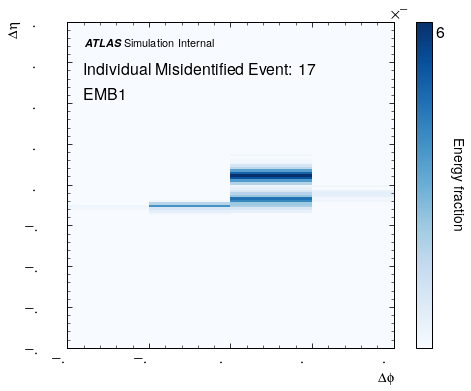

<Figure size 576x432 with 0 Axes>

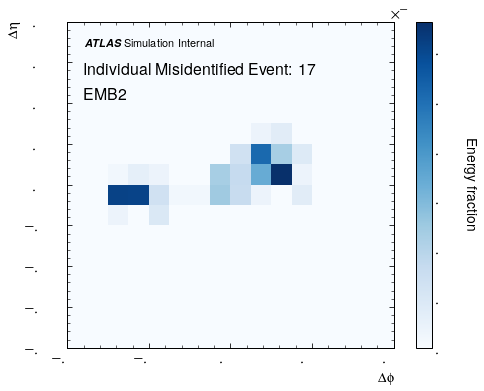

<Figure size 576x432 with 0 Axes>

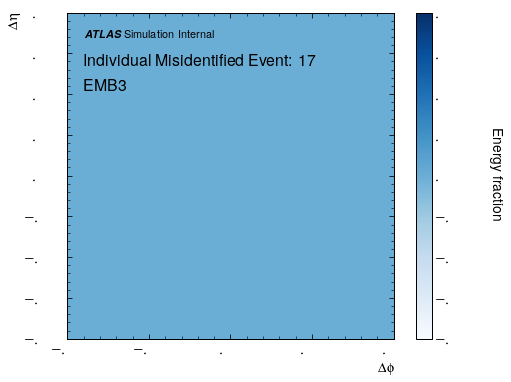

<Figure size 576x432 with 0 Axes>

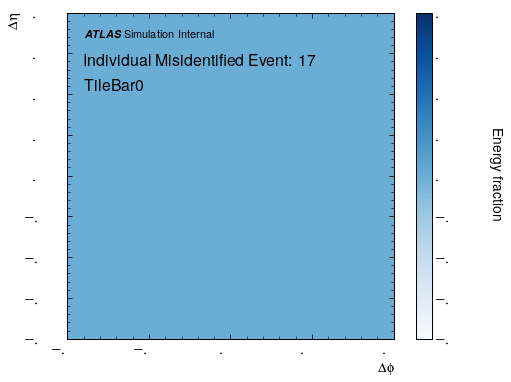

<Figure size 576x432 with 0 Axes>

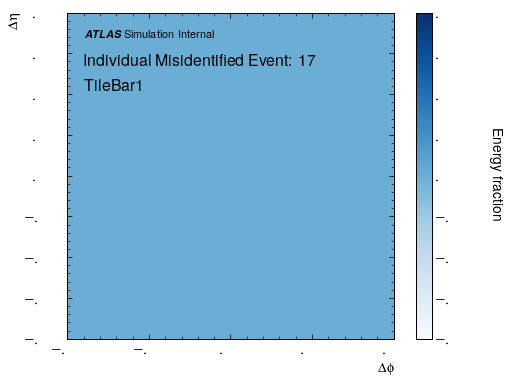

<Figure size 576x432 with 0 Axes>

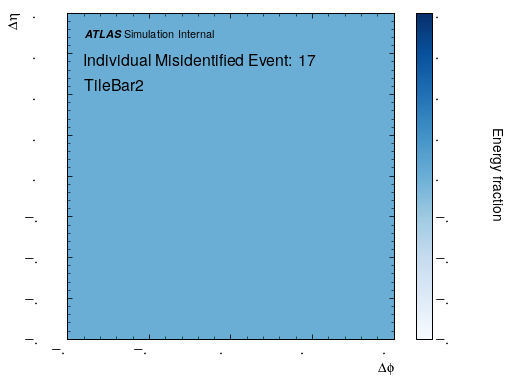

<Figure size 576x432 with 0 Axes>

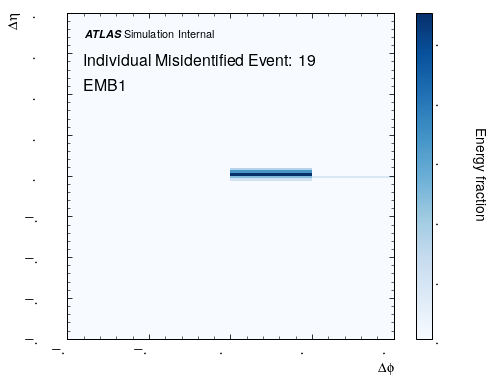

<Figure size 576x432 with 0 Axes>

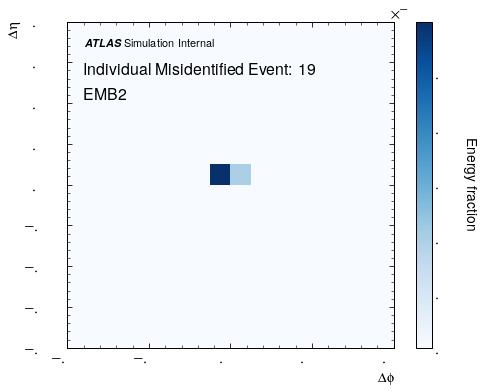

<Figure size 576x432 with 0 Axes>

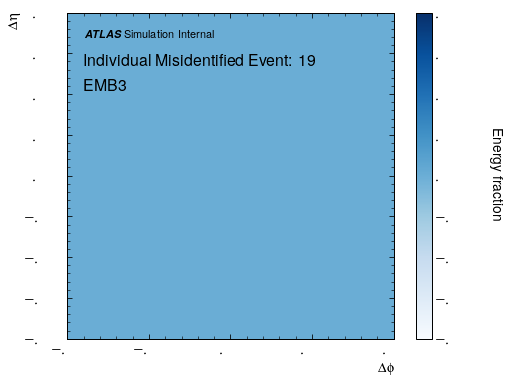

<Figure size 576x432 with 0 Axes>

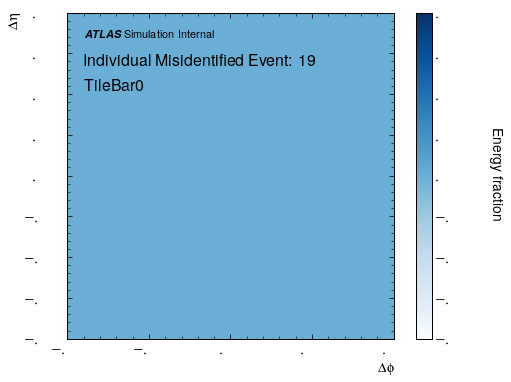

<Figure size 576x432 with 0 Axes>

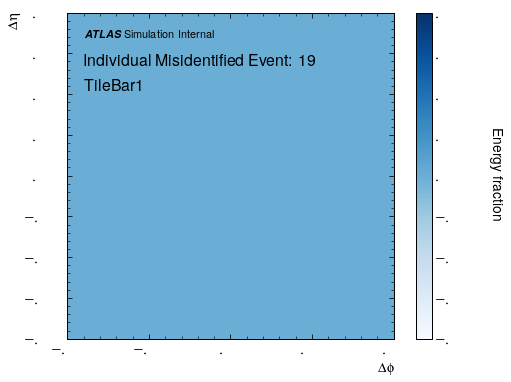

<Figure size 576x432 with 0 Axes>

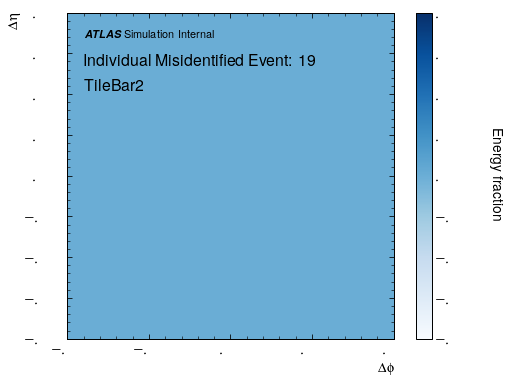

<Figure size 576x432 with 0 Axes>

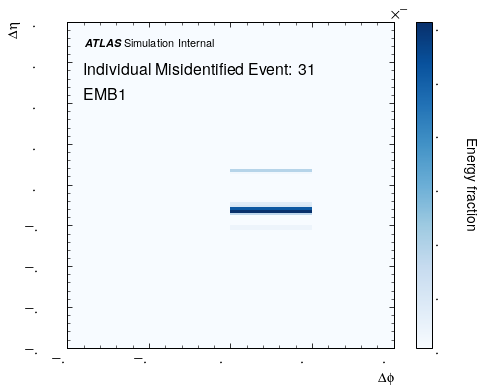

<Figure size 576x432 with 0 Axes>

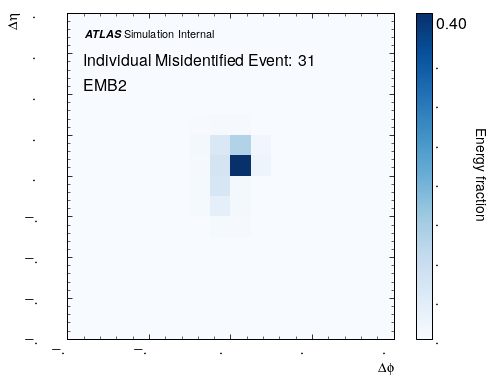

<Figure size 576x432 with 0 Axes>

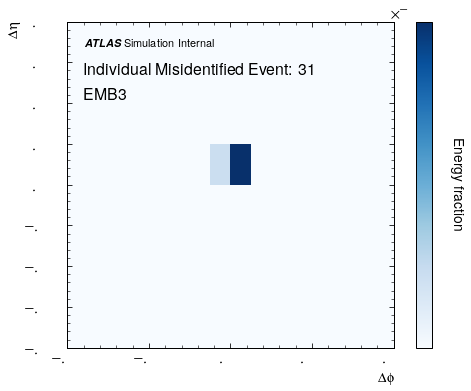

<Figure size 576x432 with 0 Axes>

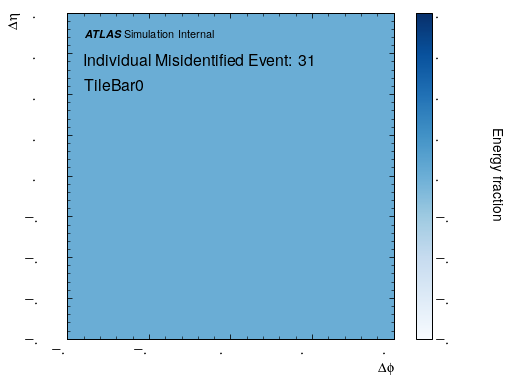

<Figure size 576x432 with 0 Axes>

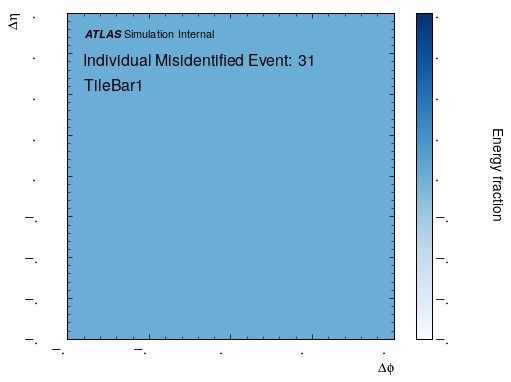

<Figure size 576x432 with 0 Axes>

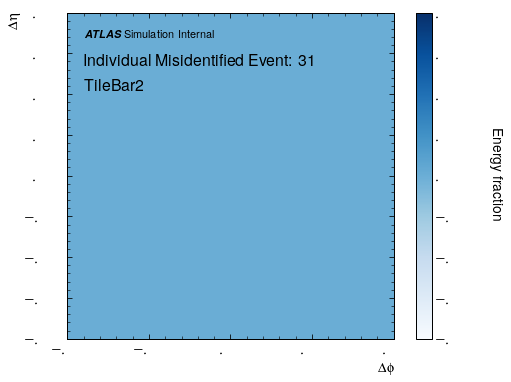

<Figure size 576x432 with 0 Axes>

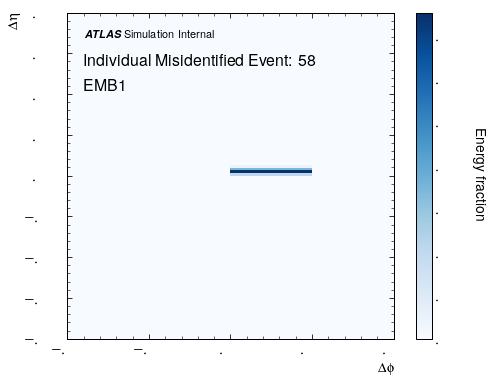

<Figure size 576x432 with 0 Axes>

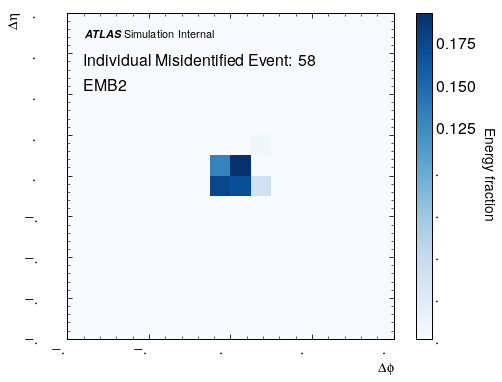

<Figure size 576x432 with 0 Axes>

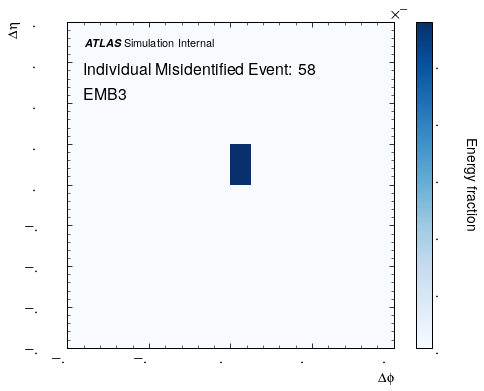

<Figure size 576x432 with 0 Axes>

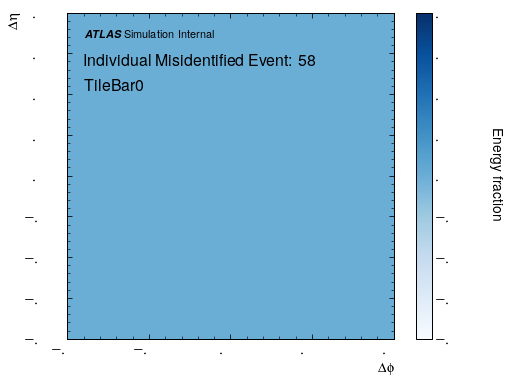

<Figure size 576x432 with 0 Axes>

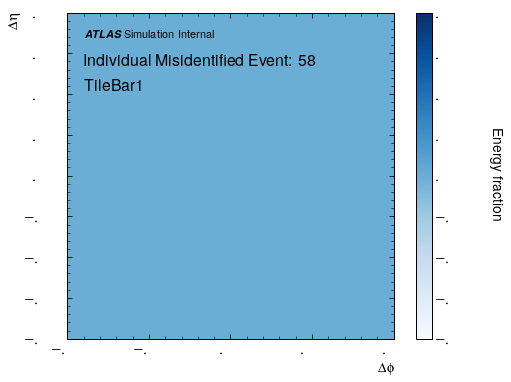

<Figure size 576x432 with 0 Axes>

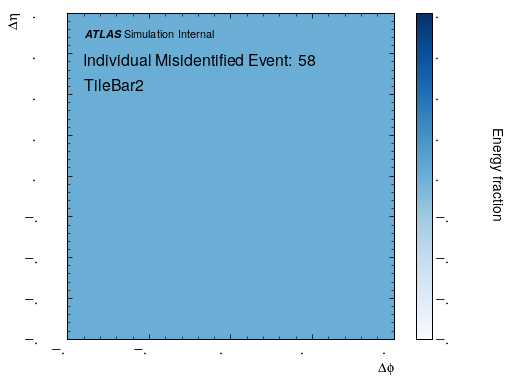

<Figure size 576x432 with 0 Axes>

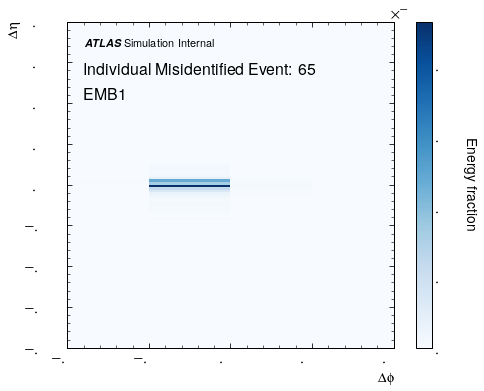

<Figure size 576x432 with 0 Axes>

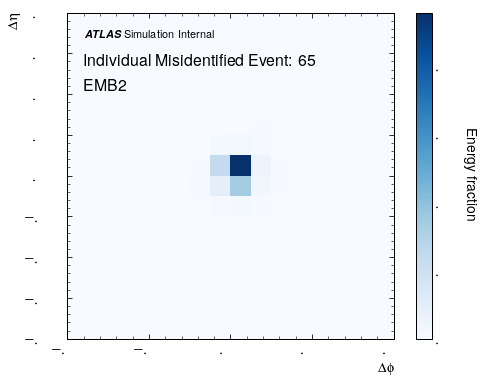

<Figure size 576x432 with 0 Axes>

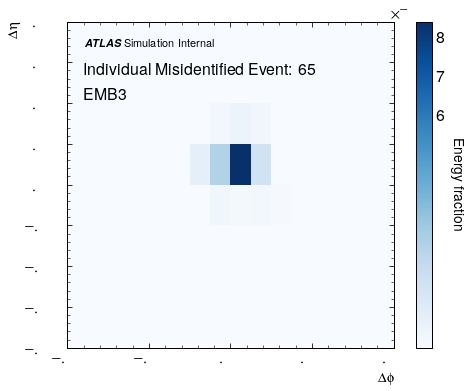

<Figure size 576x432 with 0 Axes>

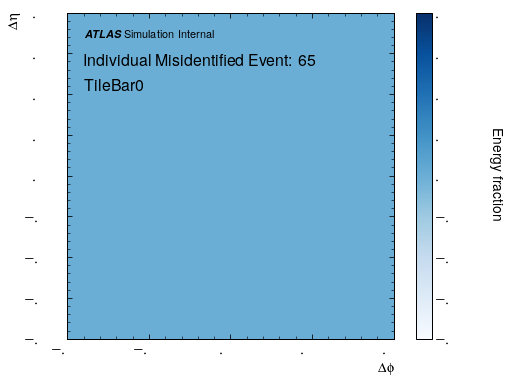

<Figure size 576x432 with 0 Axes>

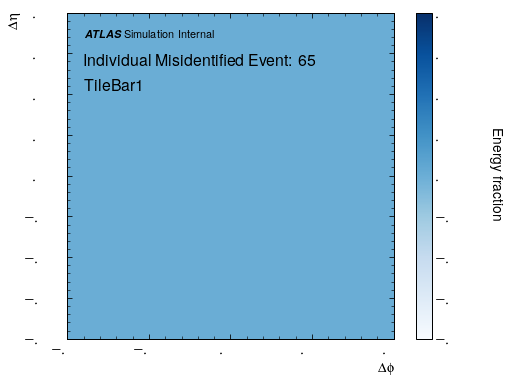

<Figure size 576x432 with 0 Axes>

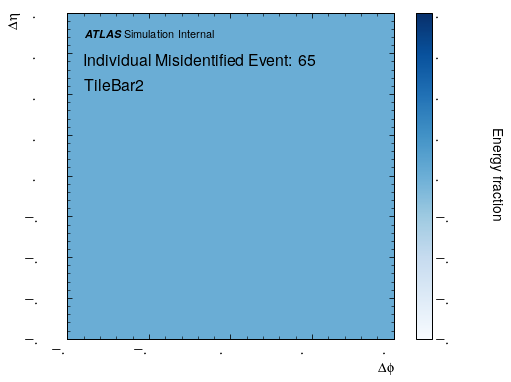

<Figure size 576x432 with 0 Axes>

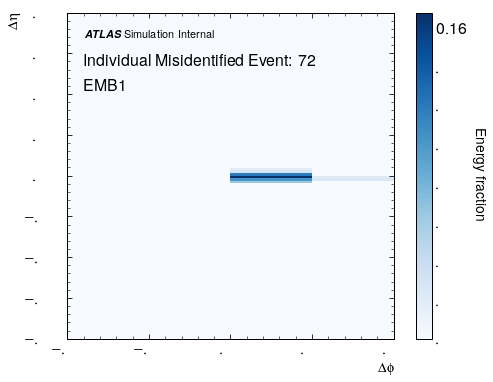

<Figure size 576x432 with 0 Axes>

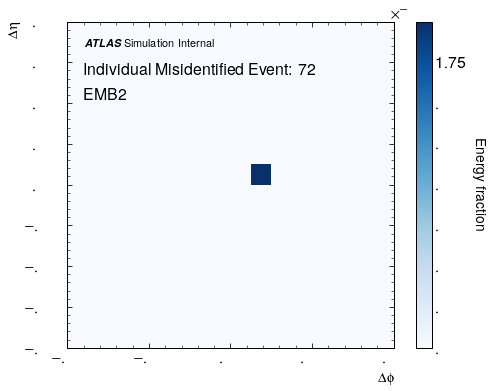

<Figure size 576x432 with 0 Axes>

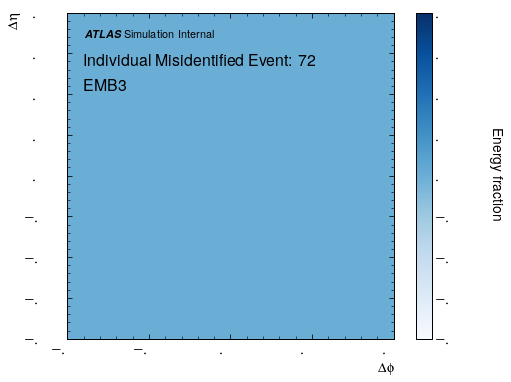

<Figure size 576x432 with 0 Axes>

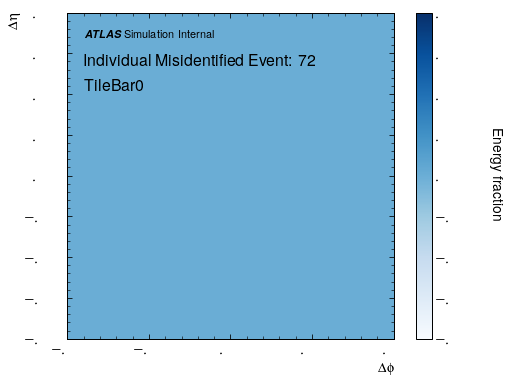

<Figure size 576x432 with 0 Axes>

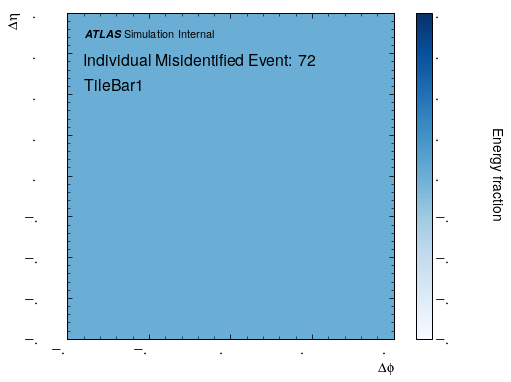

<Figure size 576x432 with 0 Axes>

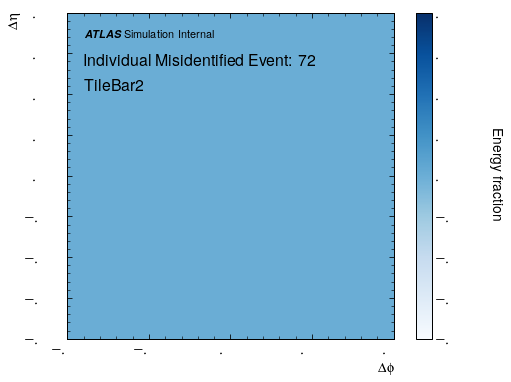

<Figure size 576x432 with 0 Axes>

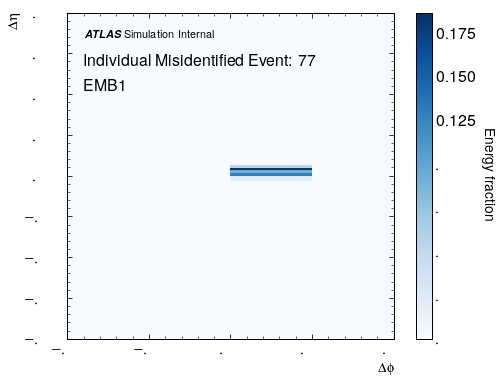

<Figure size 576x432 with 0 Axes>

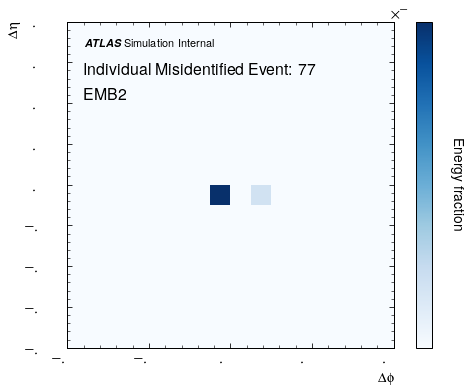

<Figure size 576x432 with 0 Axes>

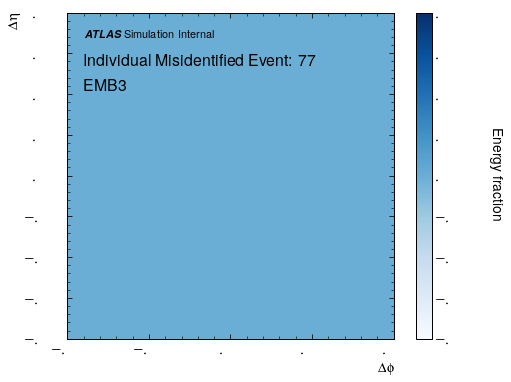

<Figure size 576x432 with 0 Axes>

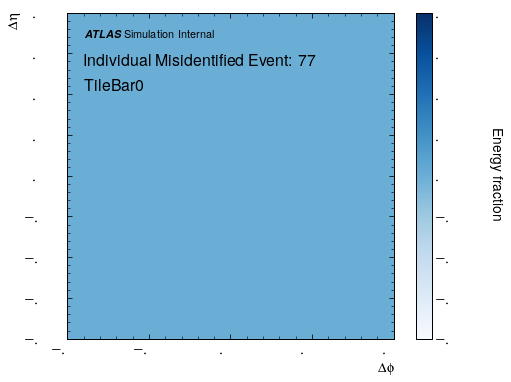

<Figure size 576x432 with 0 Axes>

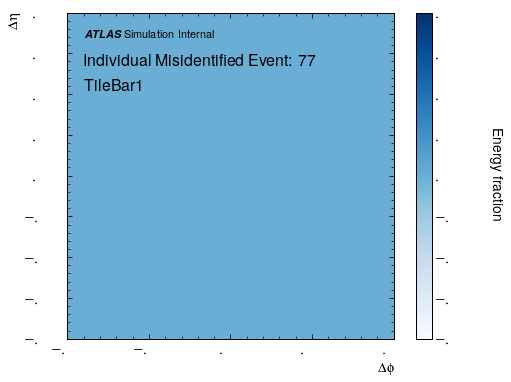

<Figure size 576x432 with 0 Axes>

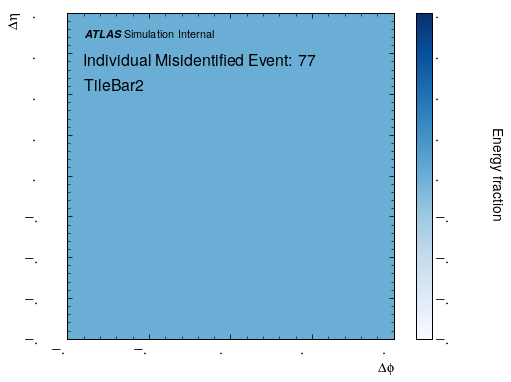

<Figure size 576x432 with 0 Axes>

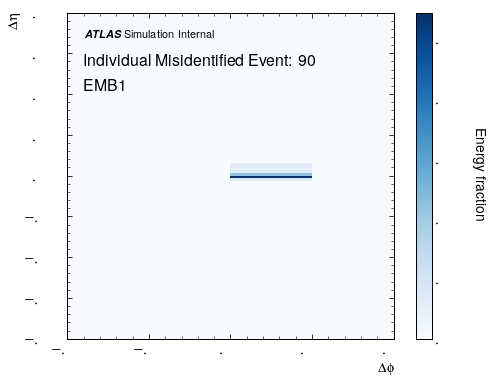

<Figure size 576x432 with 0 Axes>

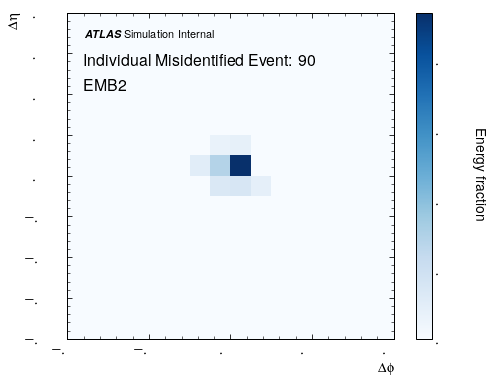

<Figure size 576x432 with 0 Axes>

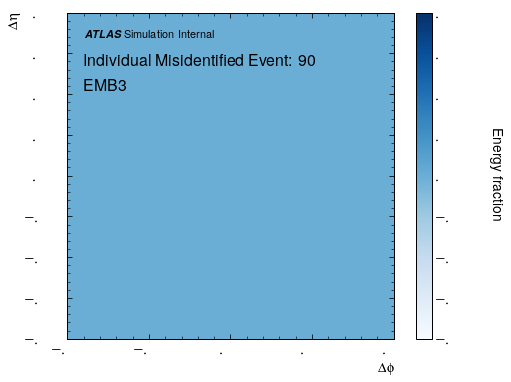

<Figure size 576x432 with 0 Axes>

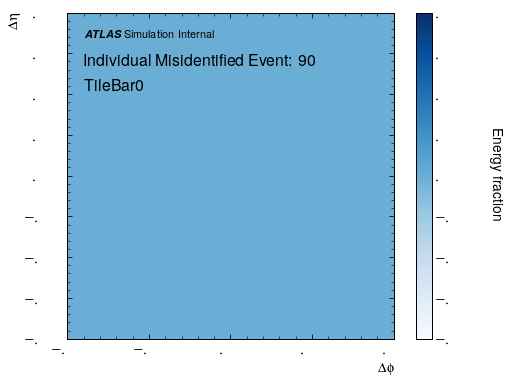

<Figure size 576x432 with 0 Axes>

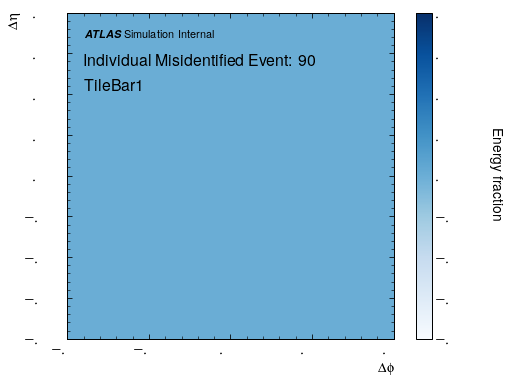

<Figure size 576x432 with 0 Axes>

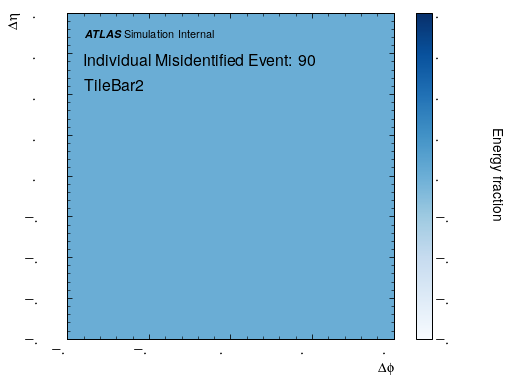

<Figure size 576x432 with 0 Axes>

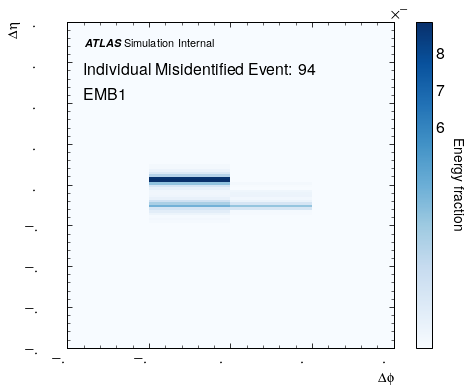

<Figure size 576x432 with 0 Axes>

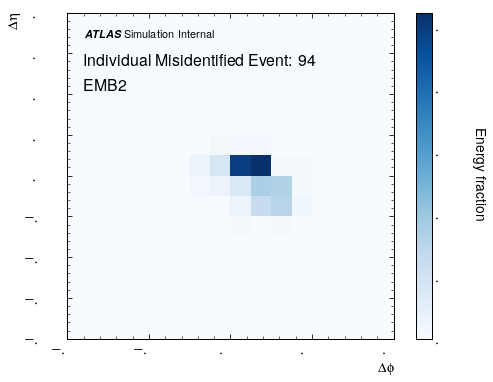

<Figure size 576x432 with 0 Axes>

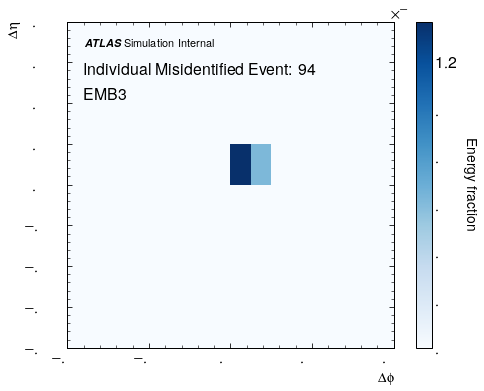

<Figure size 576x432 with 0 Axes>

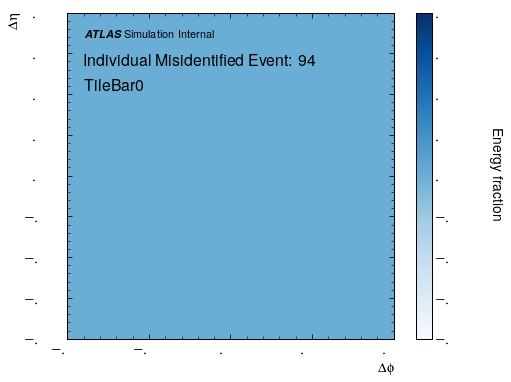

<Figure size 576x432 with 0 Axes>

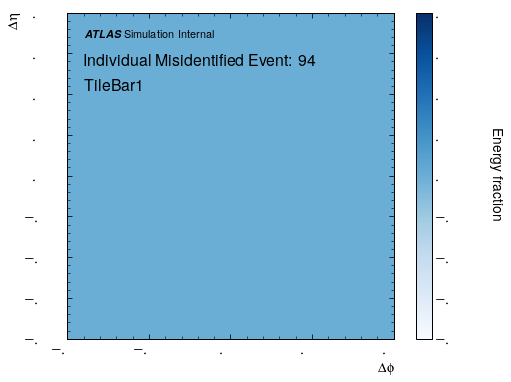

<Figure size 576x432 with 0 Axes>

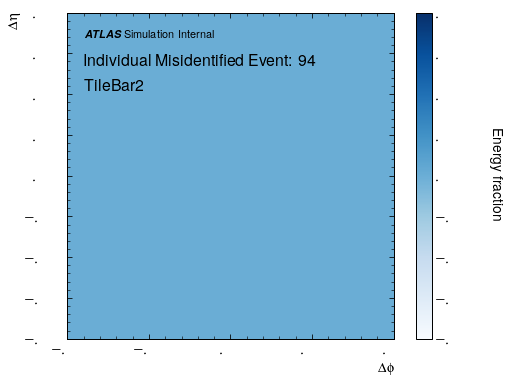

<Figure size 576x432 with 0 Axes>

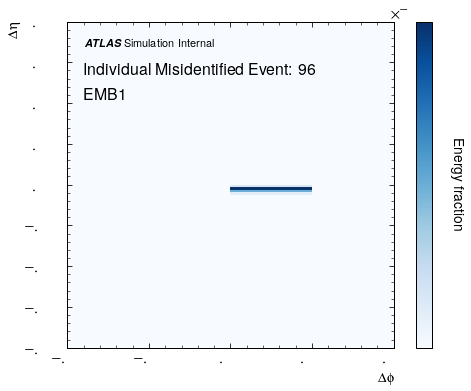

<Figure size 576x432 with 0 Axes>

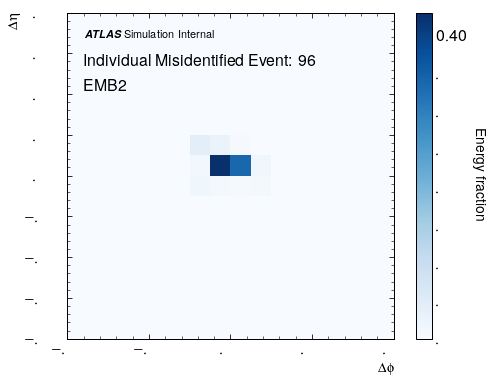

<Figure size 576x432 with 0 Axes>

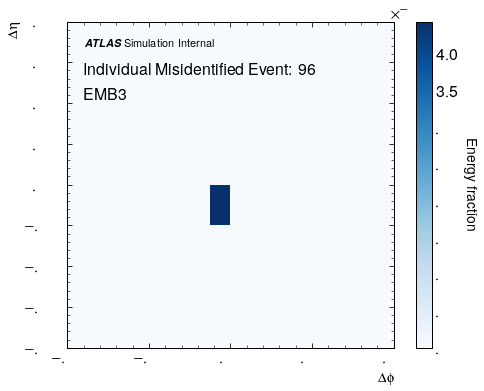

<Figure size 576x432 with 0 Axes>

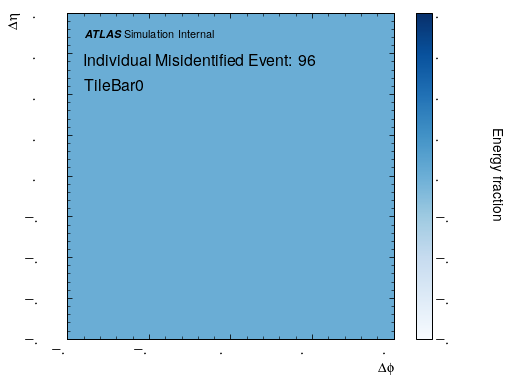

<Figure size 576x432 with 0 Axes>

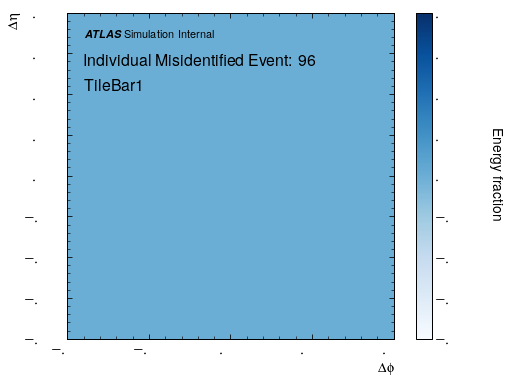

<Figure size 576x432 with 0 Axes>

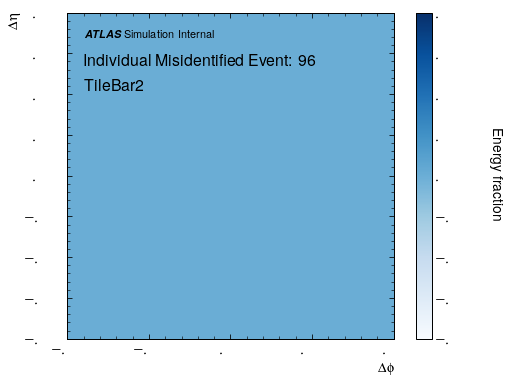

<Figure size 576x432 with 0 Axes>

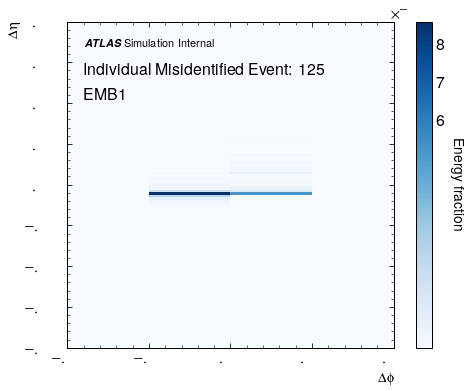

<Figure size 576x432 with 0 Axes>

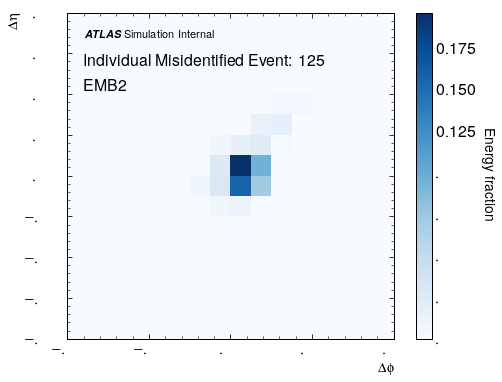

<Figure size 576x432 with 0 Axes>

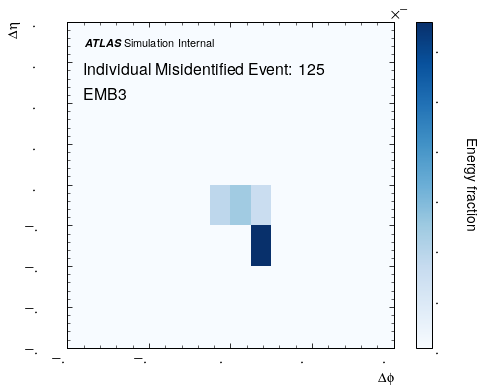

<Figure size 576x432 with 0 Axes>

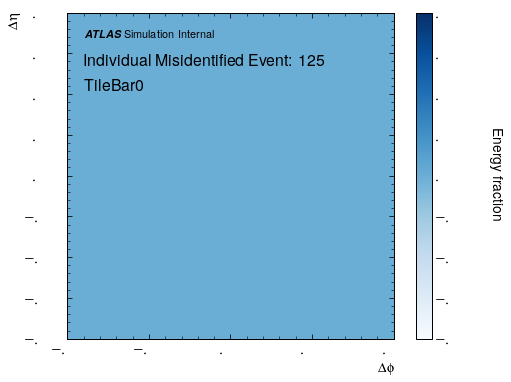

<Figure size 576x432 with 0 Axes>

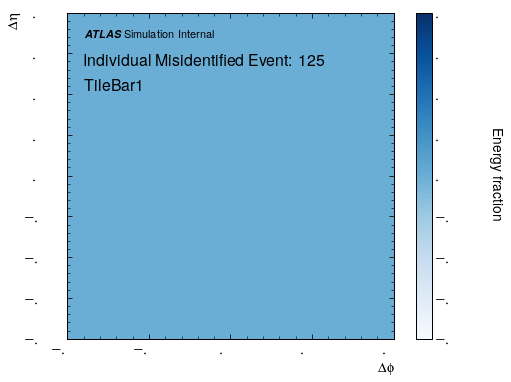

<Figure size 576x432 with 0 Axes>

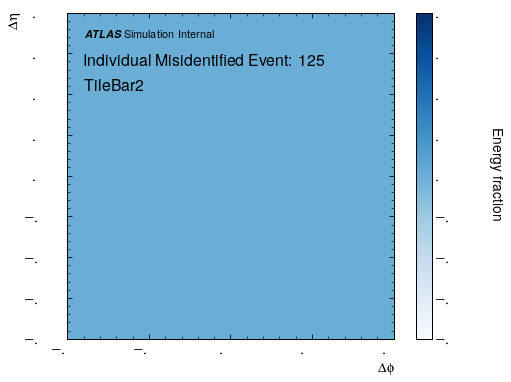

<Figure size 576x432 with 0 Axes>

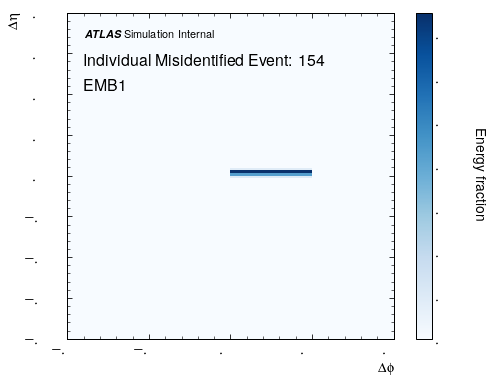

<Figure size 576x432 with 0 Axes>

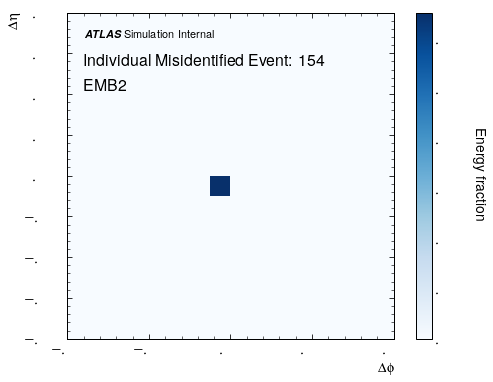

<Figure size 576x432 with 0 Axes>

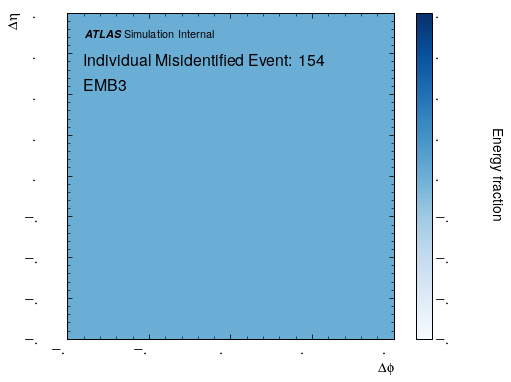

<Figure size 576x432 with 0 Axes>

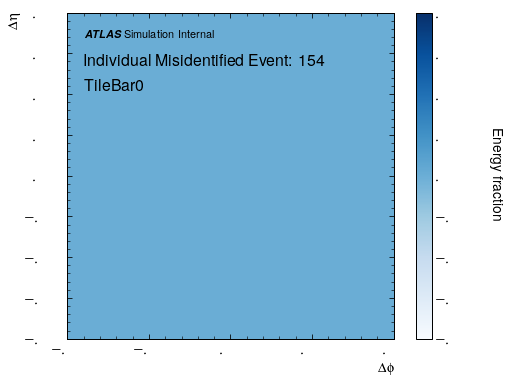

<Figure size 576x432 with 0 Axes>

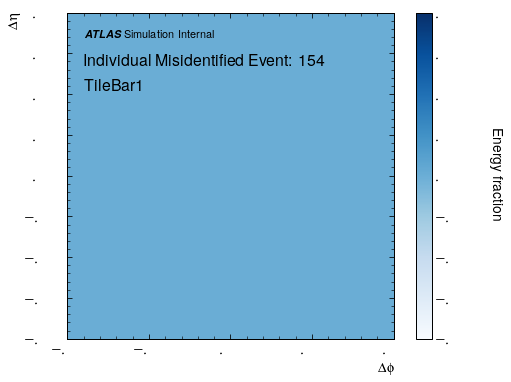

<Figure size 576x432 with 0 Axes>

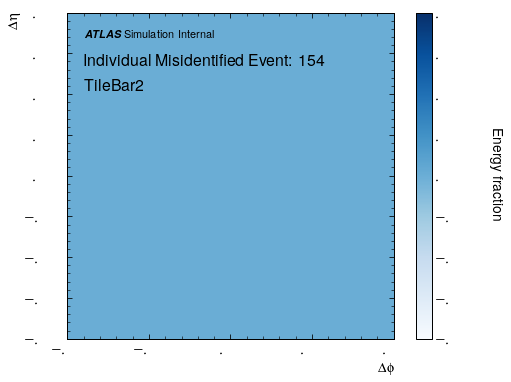

<Figure size 576x432 with 0 Axes>

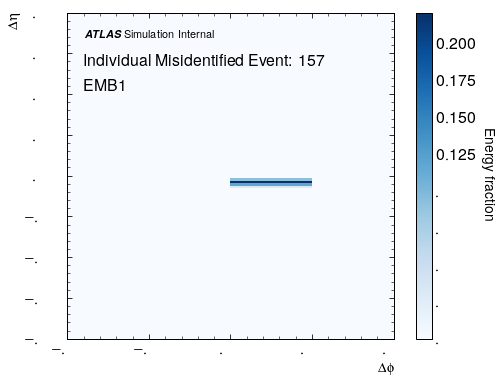

<Figure size 576x432 with 0 Axes>

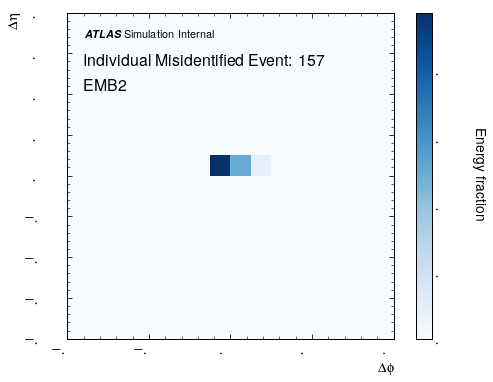

<Figure size 576x432 with 0 Axes>

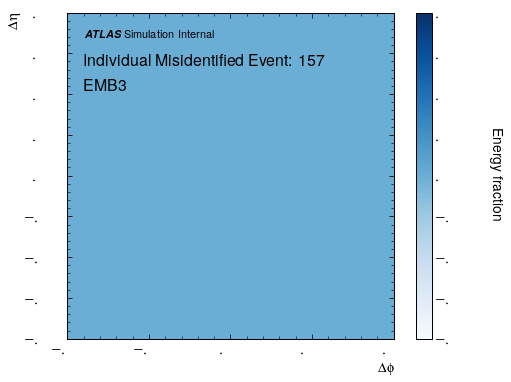

<Figure size 576x432 with 0 Axes>

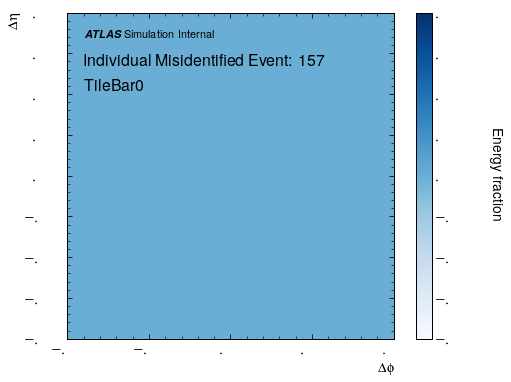

<Figure size 576x432 with 0 Axes>

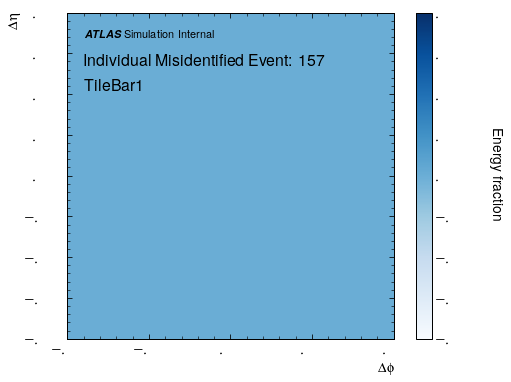

<Figure size 576x432 with 0 Axes>

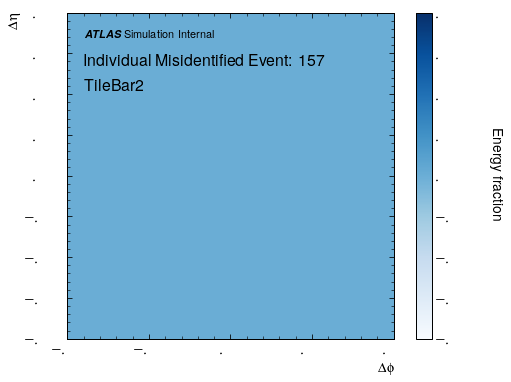

<Figure size 576x432 with 0 Axes>

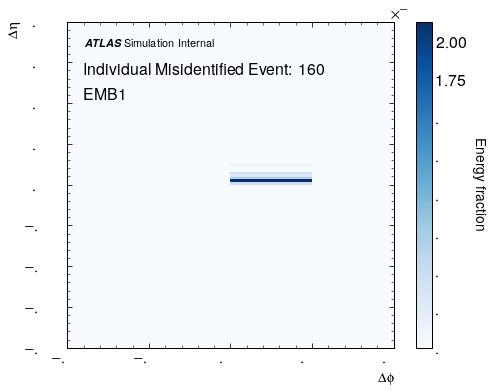

<Figure size 576x432 with 0 Axes>

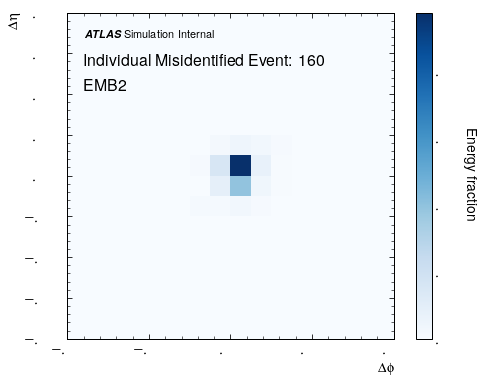

<Figure size 576x432 with 0 Axes>

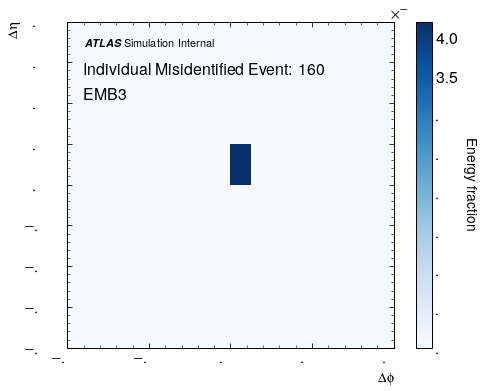

<Figure size 576x432 with 0 Axes>

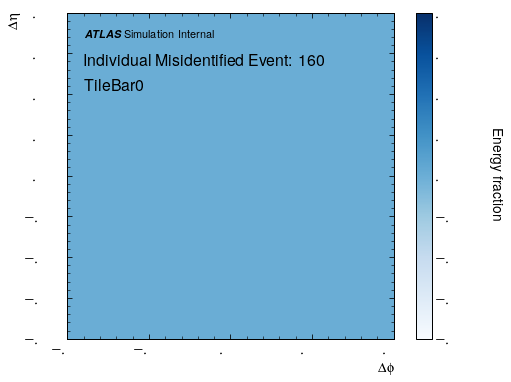

<Figure size 576x432 with 0 Axes>

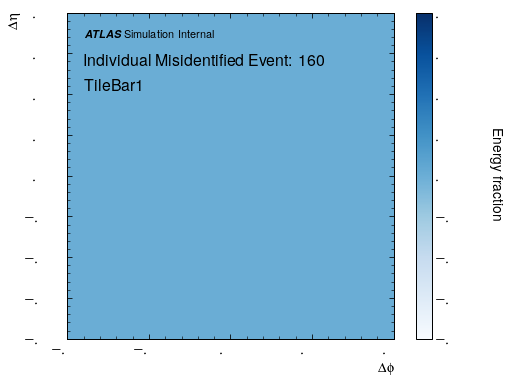

<Figure size 576x432 with 0 Axes>

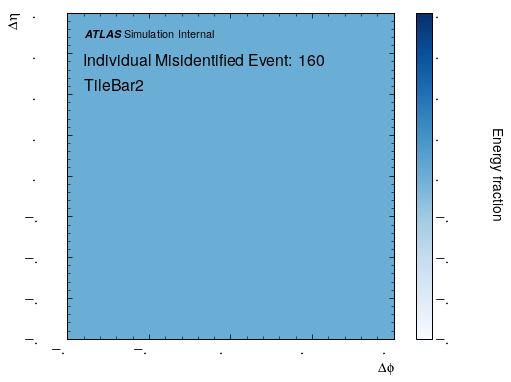

<Figure size 576x432 with 0 Axes>

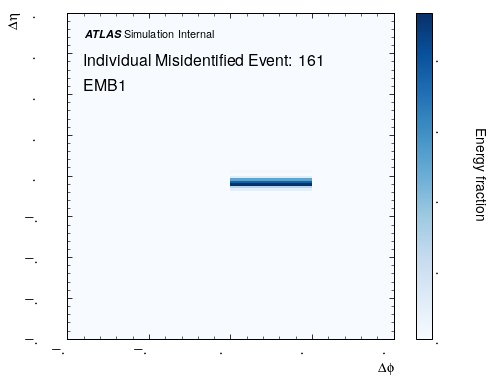

<Figure size 576x432 with 0 Axes>

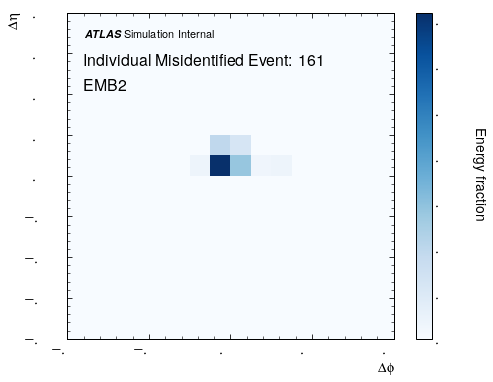

<Figure size 576x432 with 0 Axes>

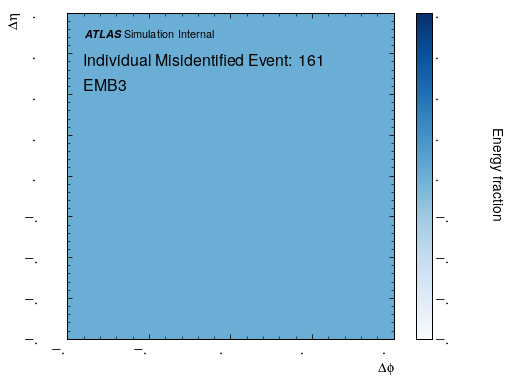

<Figure size 576x432 with 0 Axes>

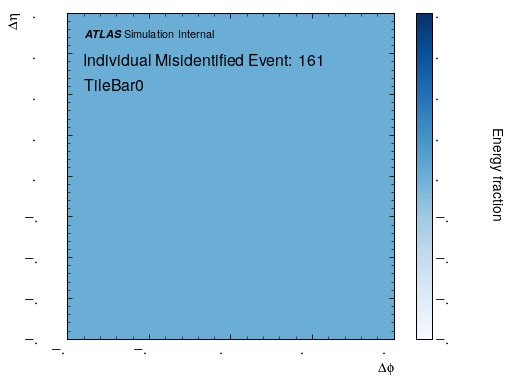

<Figure size 576x432 with 0 Axes>

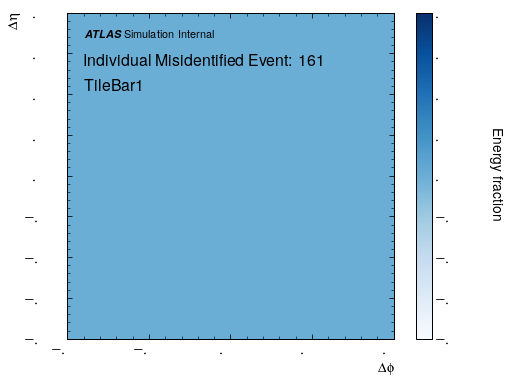

<Figure size 576x432 with 0 Axes>

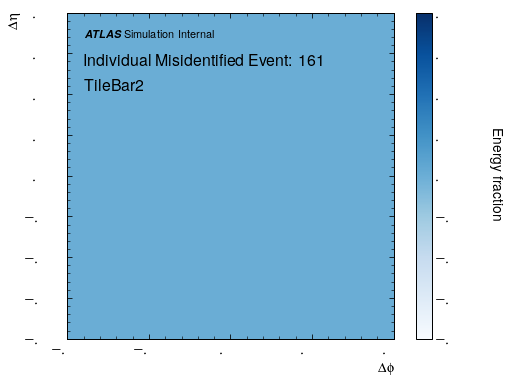

<Figure size 576x432 with 0 Axes>

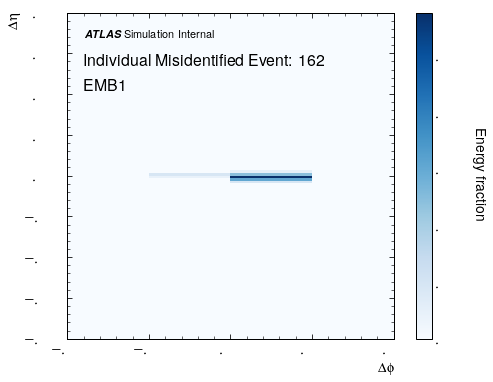

<Figure size 576x432 with 0 Axes>

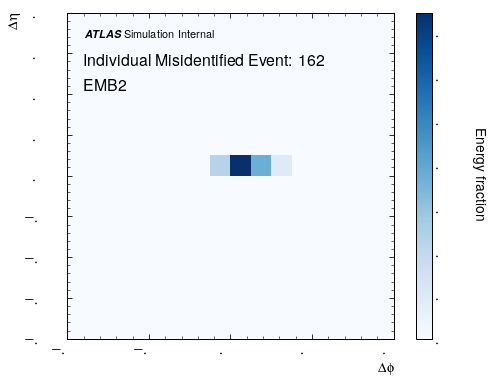

<Figure size 576x432 with 0 Axes>

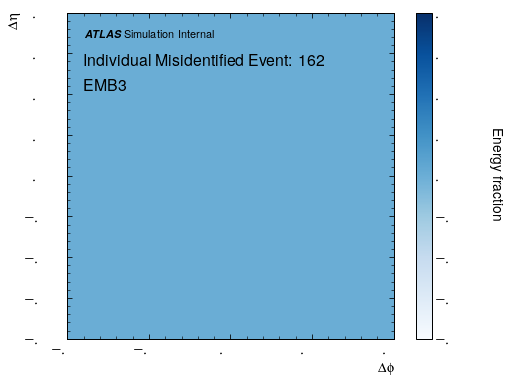

<Figure size 576x432 with 0 Axes>

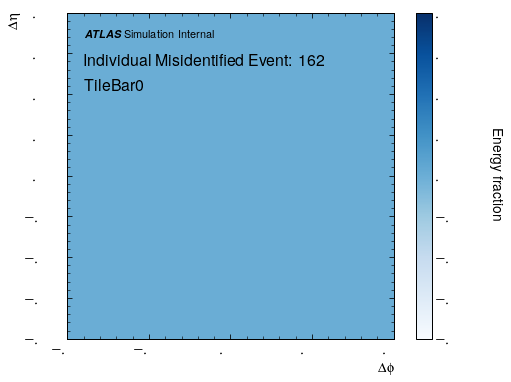

<Figure size 576x432 with 0 Axes>

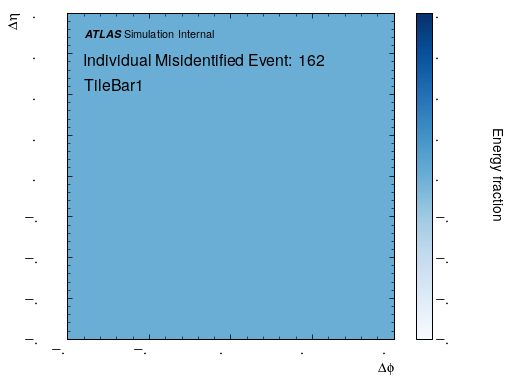

<Figure size 576x432 with 0 Axes>

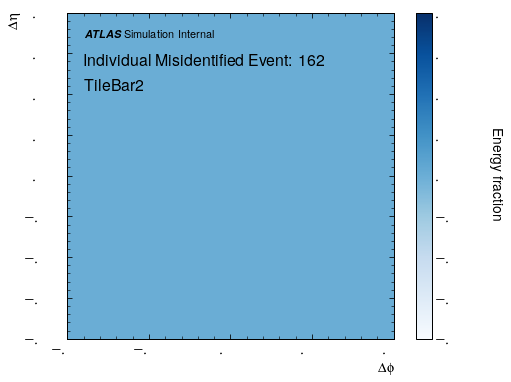

<Figure size 576x432 with 0 Axes>

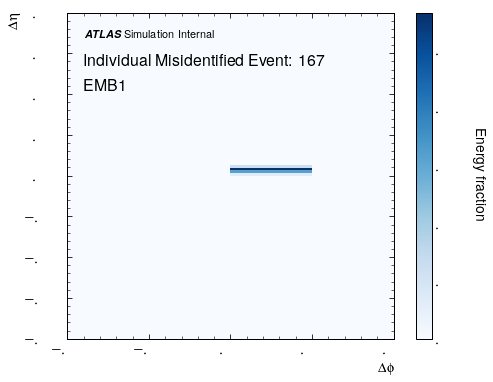

<Figure size 576x432 with 0 Axes>

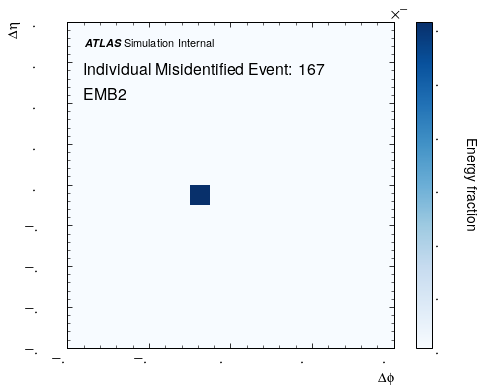

<Figure size 576x432 with 0 Axes>

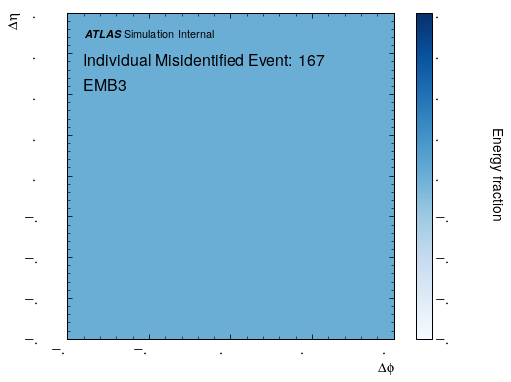

<Figure size 576x432 with 0 Axes>

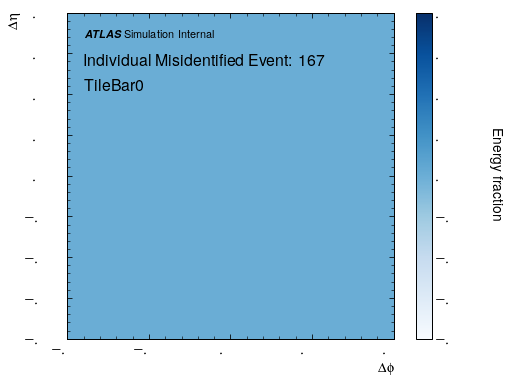

<Figure size 576x432 with 0 Axes>

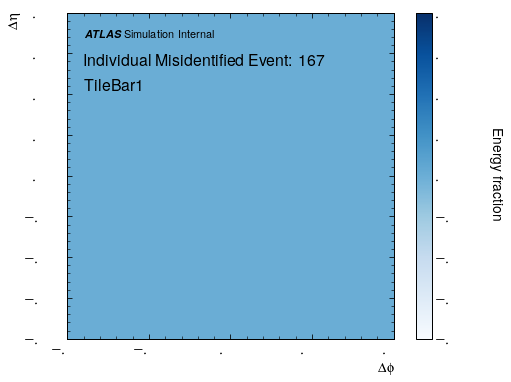

<Figure size 576x432 with 0 Axes>

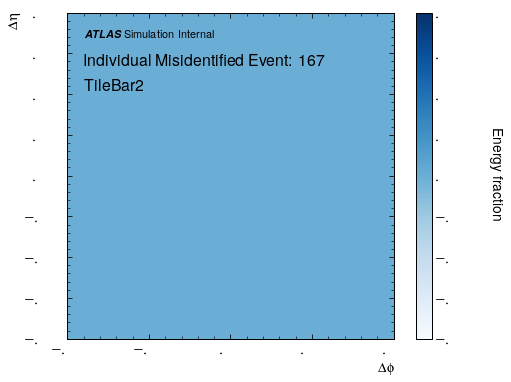

<Figure size 576x432 with 0 Axes>

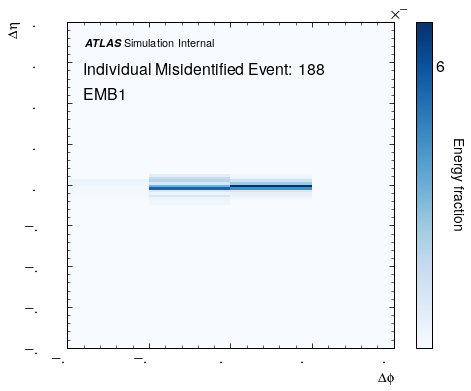

<Figure size 576x432 with 0 Axes>

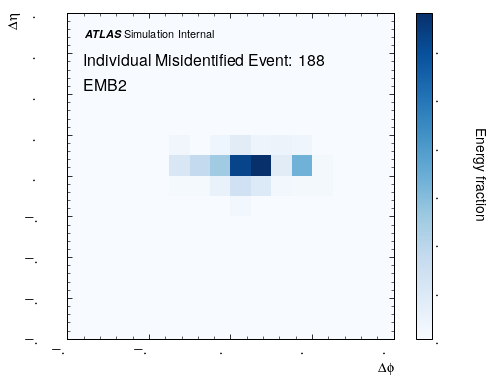

<Figure size 576x432 with 0 Axes>

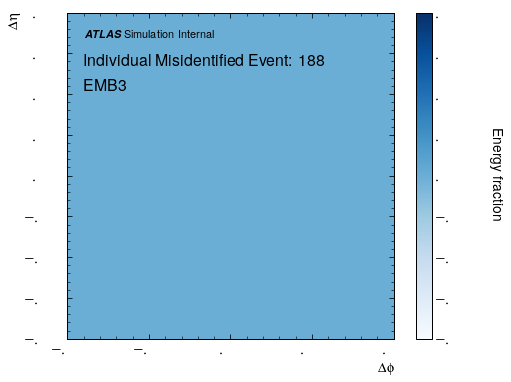

<Figure size 576x432 with 0 Axes>

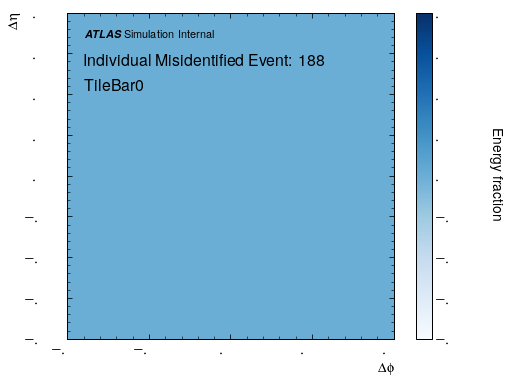

<Figure size 576x432 with 0 Axes>

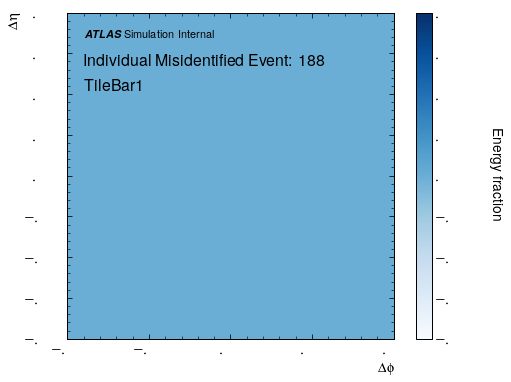

<Figure size 576x432 with 0 Axes>

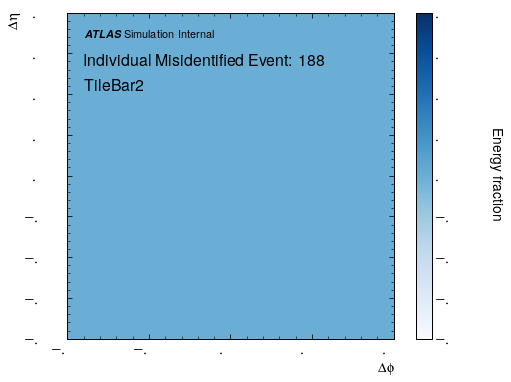

<Figure size 576x432 with 0 Axes>

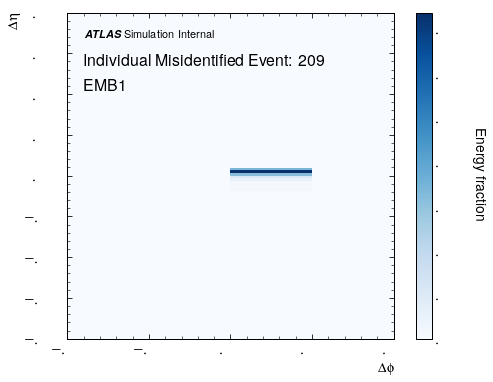

<Figure size 576x432 with 0 Axes>

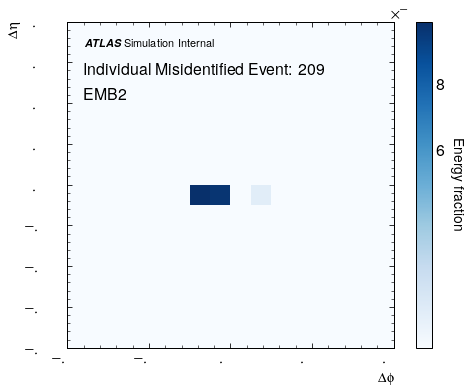

<Figure size 576x432 with 0 Axes>

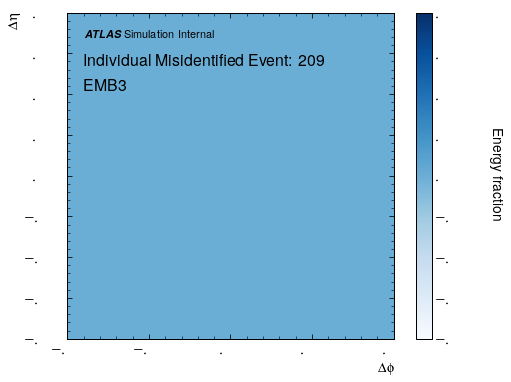

<Figure size 576x432 with 0 Axes>

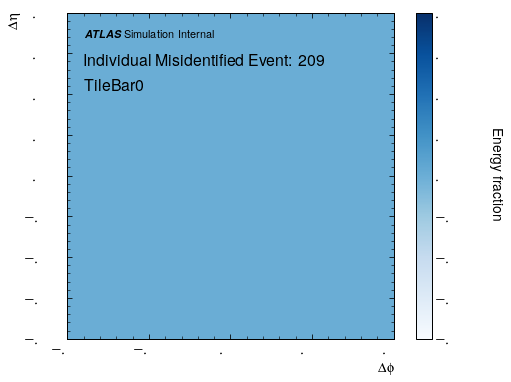

<Figure size 576x432 with 0 Axes>

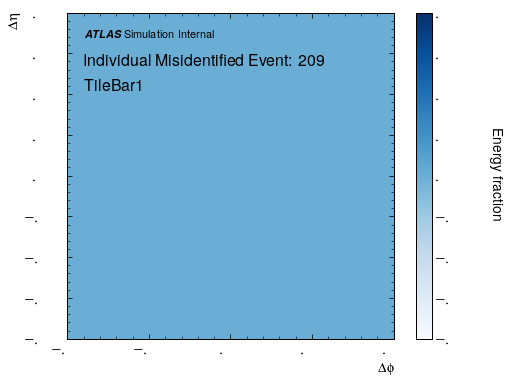

<Figure size 576x432 with 0 Axes>

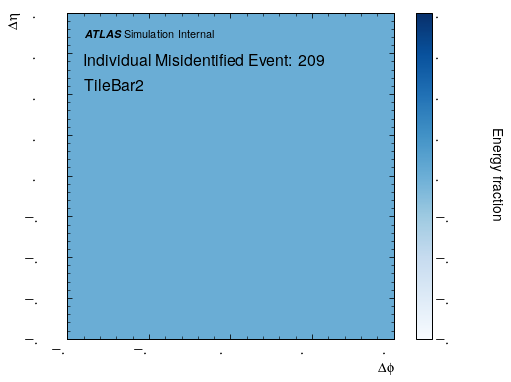

<Figure size 576x432 with 0 Axes>

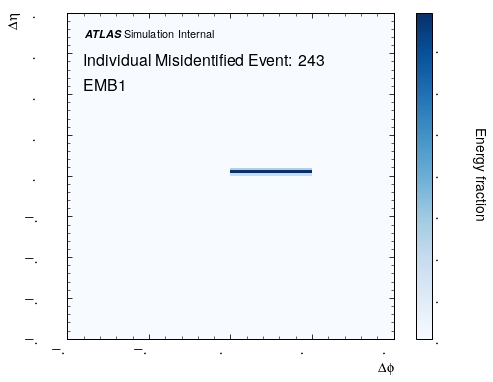

<Figure size 576x432 with 0 Axes>

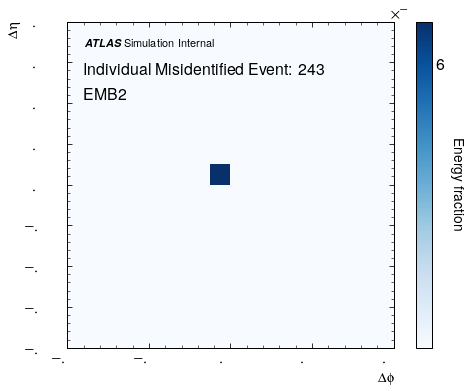

<Figure size 576x432 with 0 Axes>

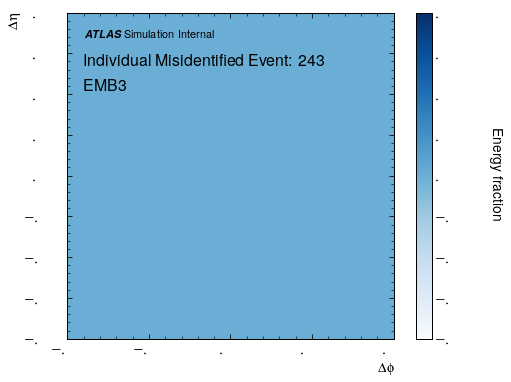

<Figure size 576x432 with 0 Axes>

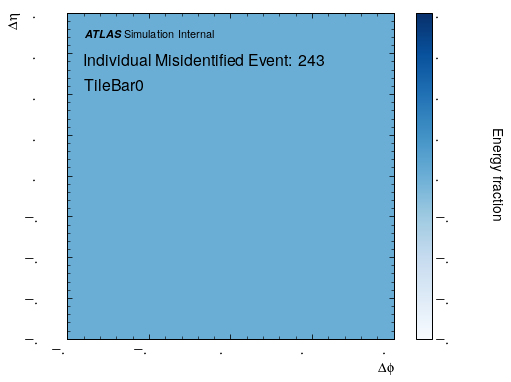

<Figure size 576x432 with 0 Axes>

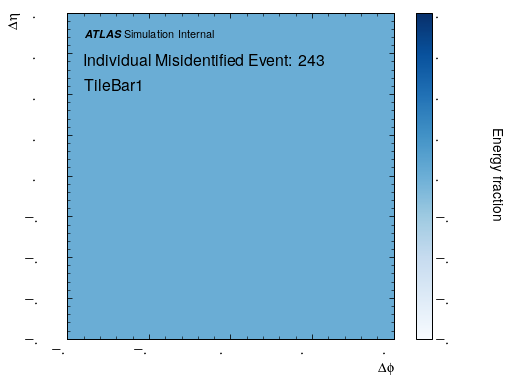

<Figure size 576x432 with 0 Axes>

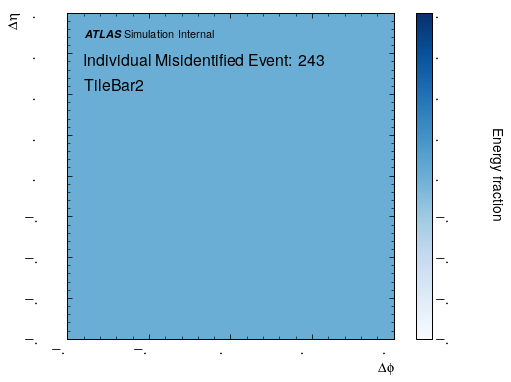

In [14]:
for i in range(20):
    render_images_ebin(misclassified_events_ebin[i],ebin=ebin,width=width)

<Figure size 576x432 with 0 Axes>

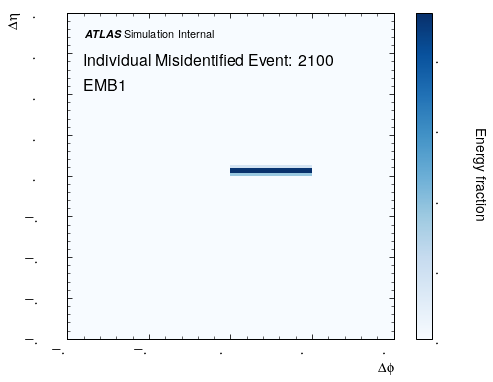

<Figure size 576x432 with 0 Axes>

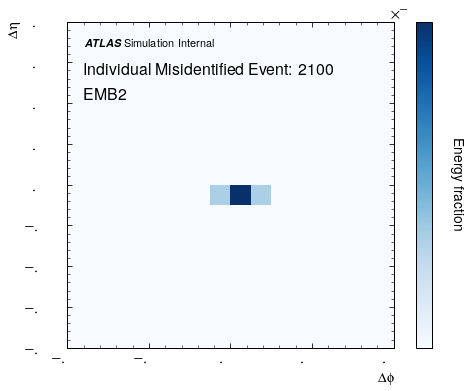

<Figure size 576x432 with 0 Axes>

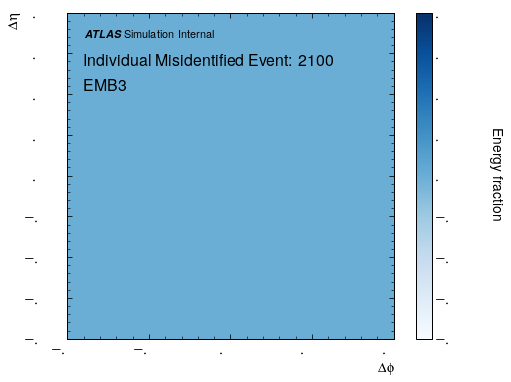

<Figure size 576x432 with 0 Axes>

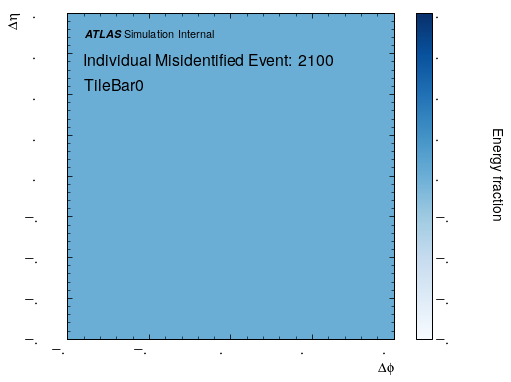

<Figure size 576x432 with 0 Axes>

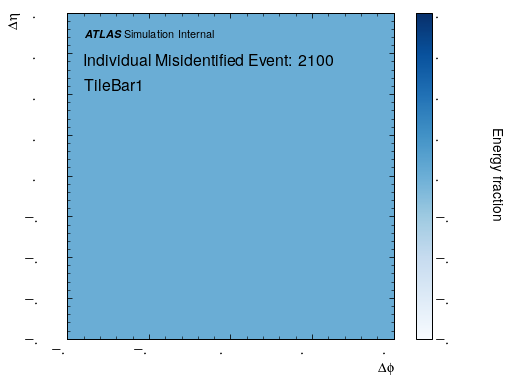

<Figure size 576x432 with 0 Axes>

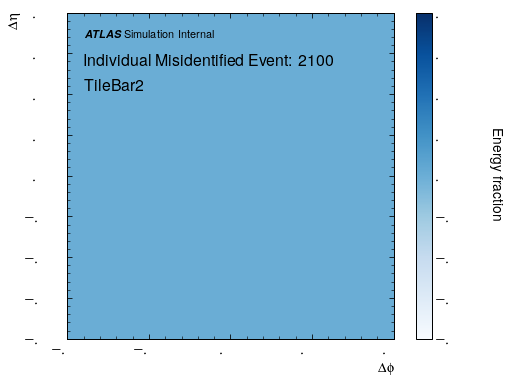

<Figure size 576x432 with 0 Axes>

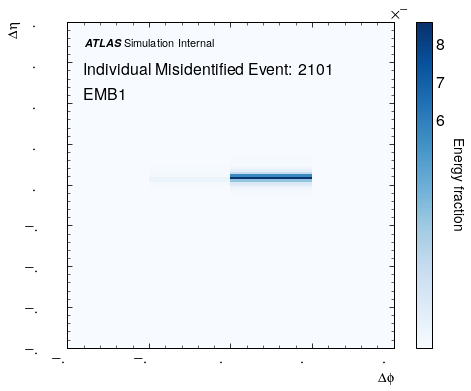

<Figure size 576x432 with 0 Axes>

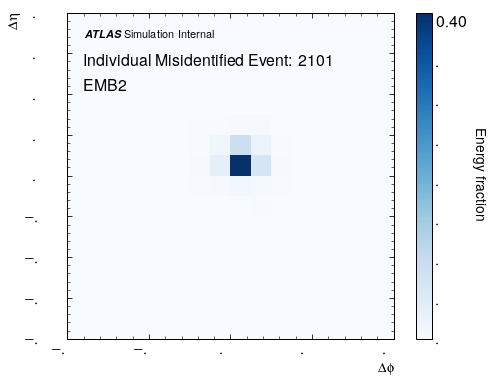

<Figure size 576x432 with 0 Axes>

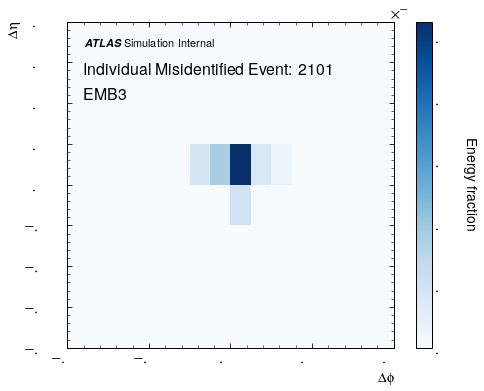

<Figure size 576x432 with 0 Axes>

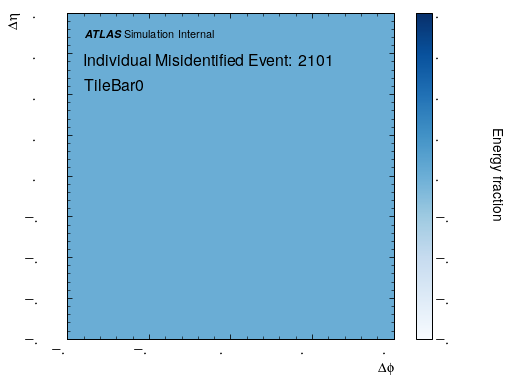

<Figure size 576x432 with 0 Axes>

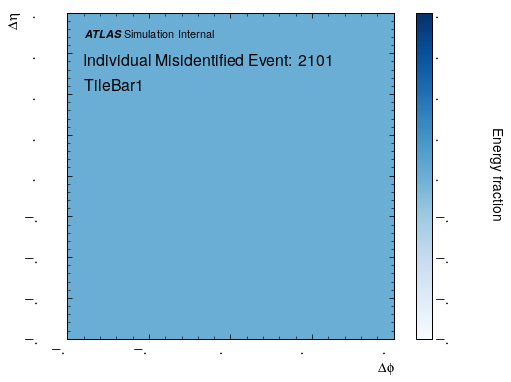

<Figure size 576x432 with 0 Axes>

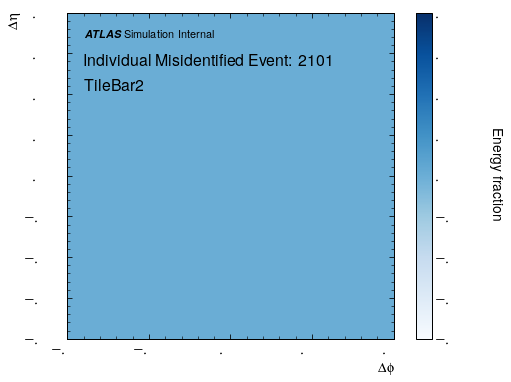

<Figure size 576x432 with 0 Axes>

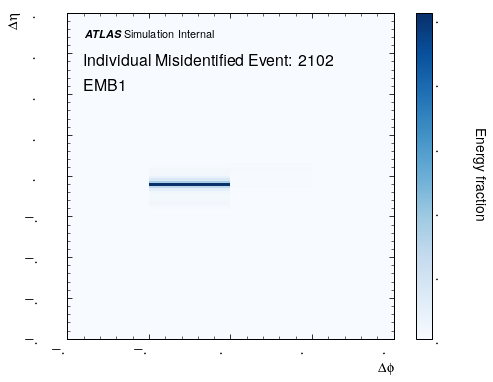

<Figure size 576x432 with 0 Axes>

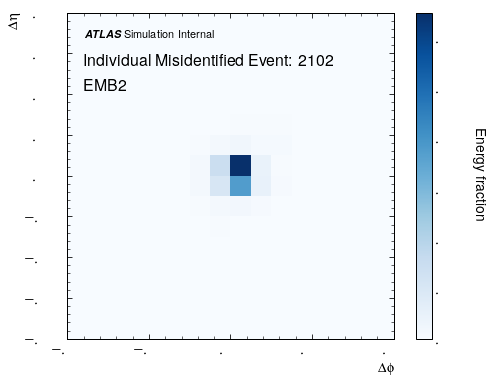

<Figure size 576x432 with 0 Axes>

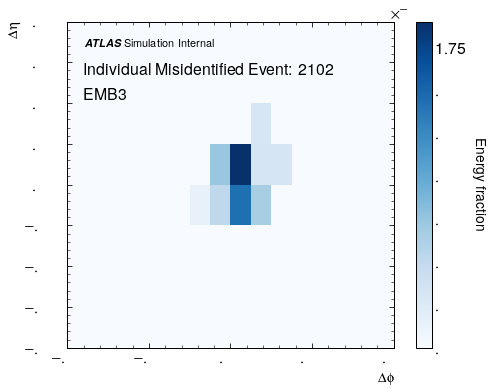

<Figure size 576x432 with 0 Axes>

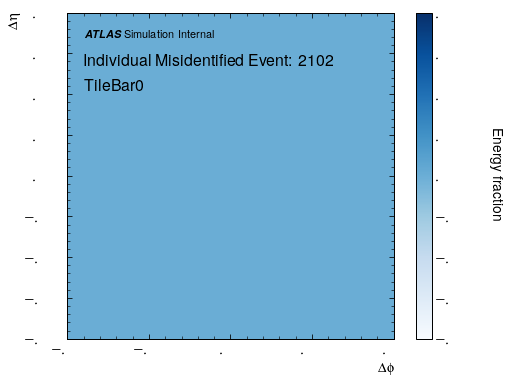

<Figure size 576x432 with 0 Axes>

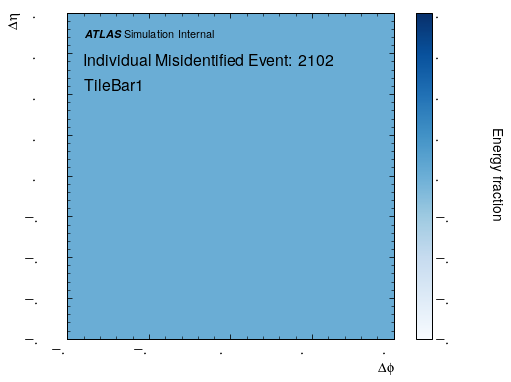

<Figure size 576x432 with 0 Axes>

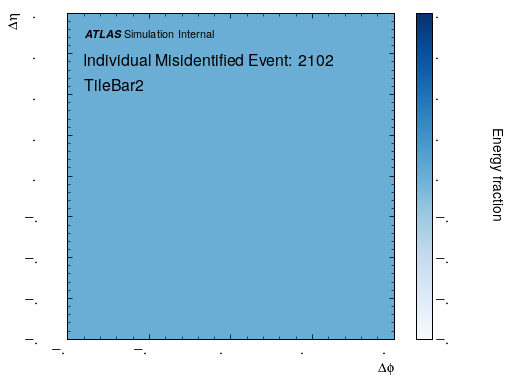

<Figure size 576x432 with 0 Axes>

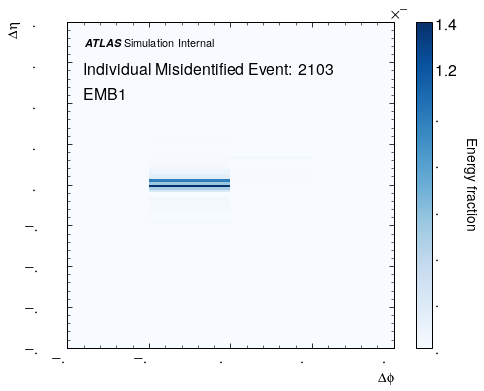

<Figure size 576x432 with 0 Axes>

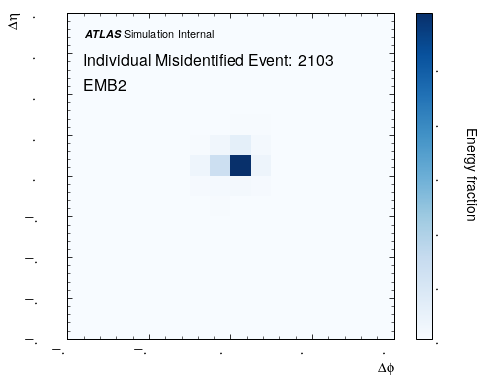

<Figure size 576x432 with 0 Axes>

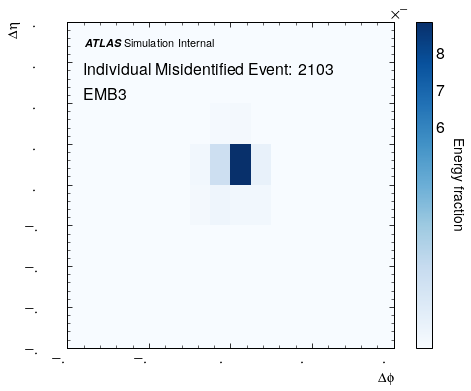

<Figure size 576x432 with 0 Axes>

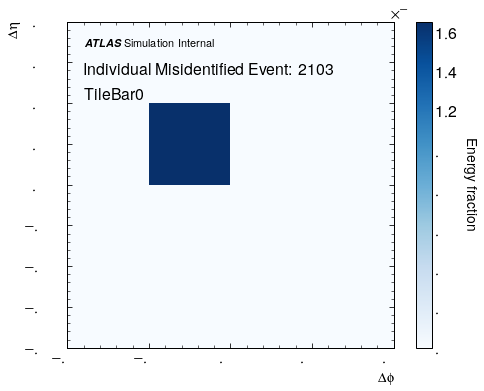

<Figure size 576x432 with 0 Axes>

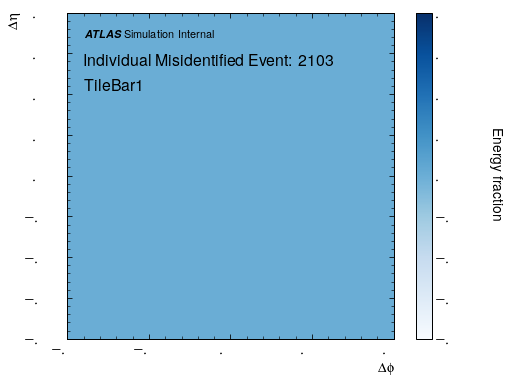

<Figure size 576x432 with 0 Axes>

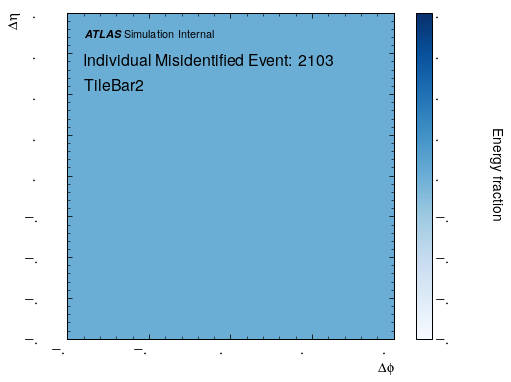

<Figure size 576x432 with 0 Axes>

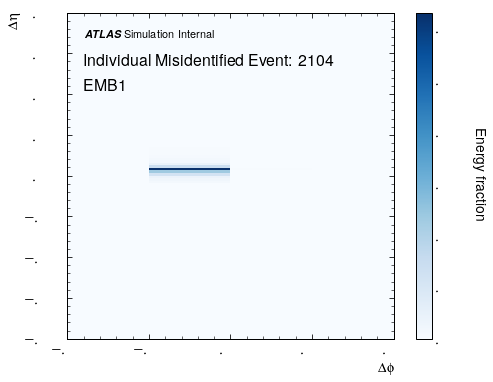

<Figure size 576x432 with 0 Axes>

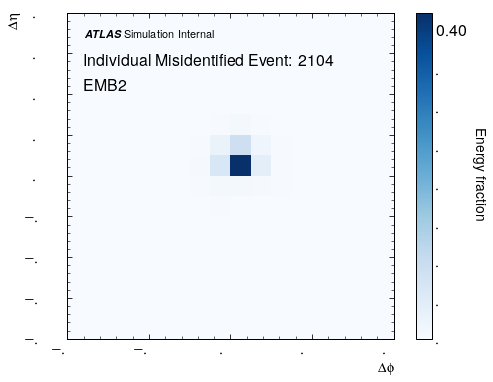

<Figure size 576x432 with 0 Axes>

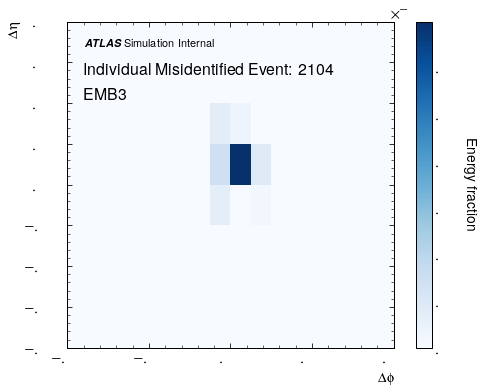

<Figure size 576x432 with 0 Axes>

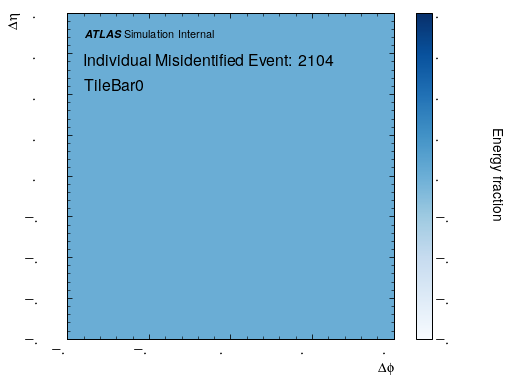

<Figure size 576x432 with 0 Axes>

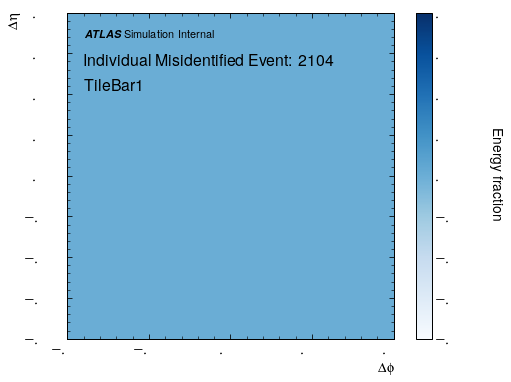

<Figure size 576x432 with 0 Axes>

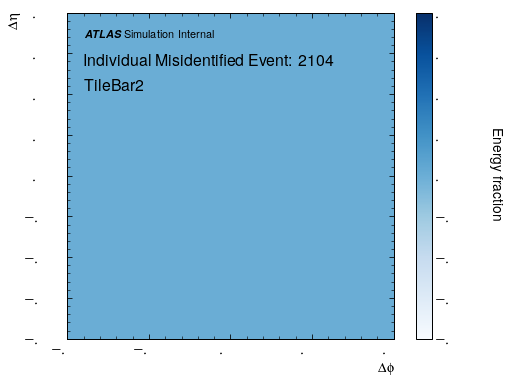

<Figure size 576x432 with 0 Axes>

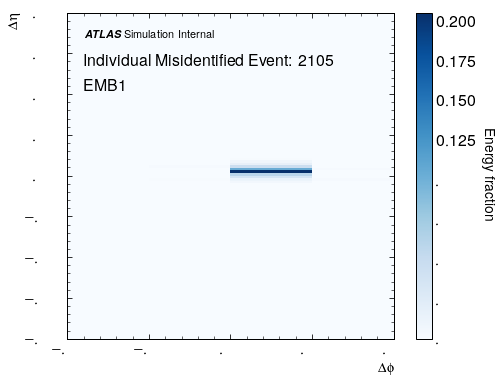

<Figure size 576x432 with 0 Axes>

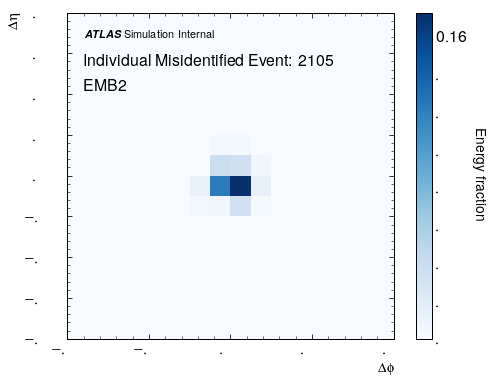

<Figure size 576x432 with 0 Axes>

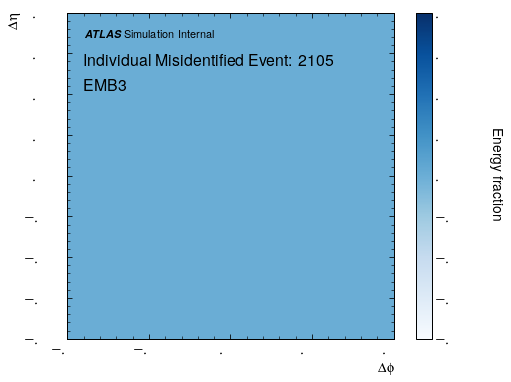

<Figure size 576x432 with 0 Axes>

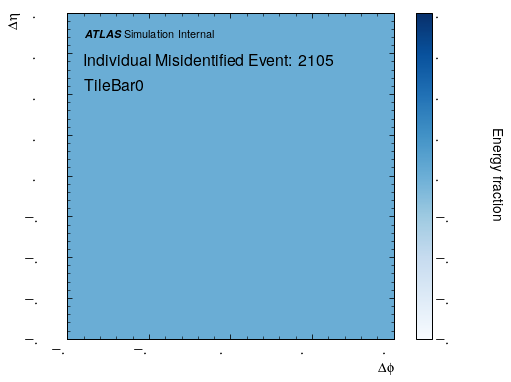

<Figure size 576x432 with 0 Axes>

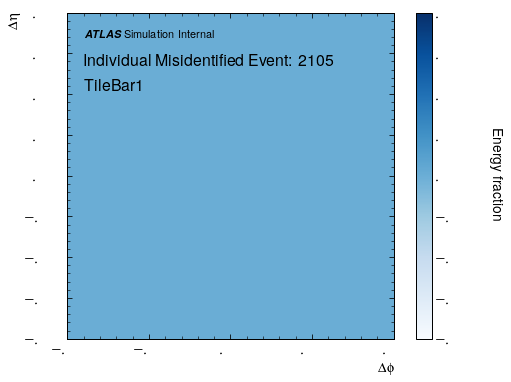

<Figure size 576x432 with 0 Axes>

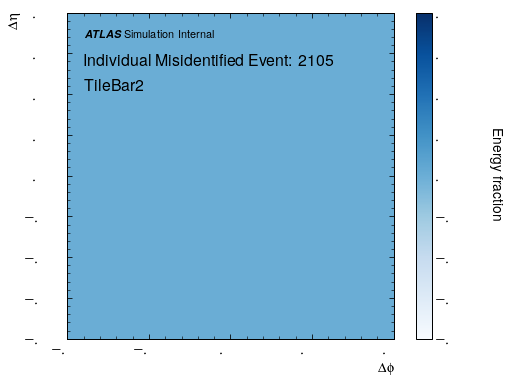

<Figure size 576x432 with 0 Axes>

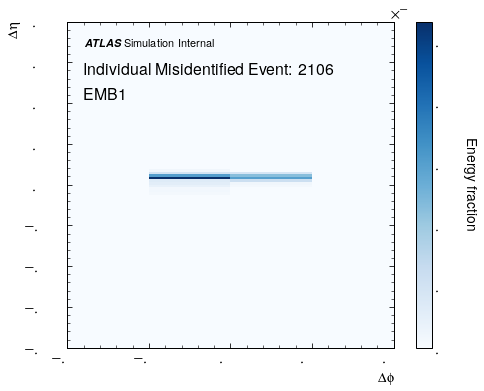

<Figure size 576x432 with 0 Axes>

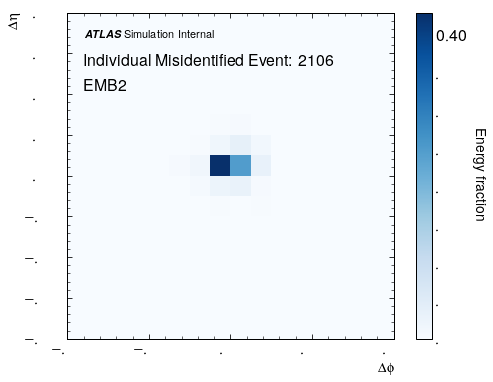

<Figure size 576x432 with 0 Axes>

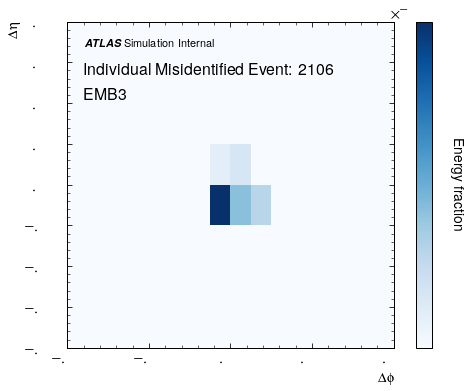

<Figure size 576x432 with 0 Axes>

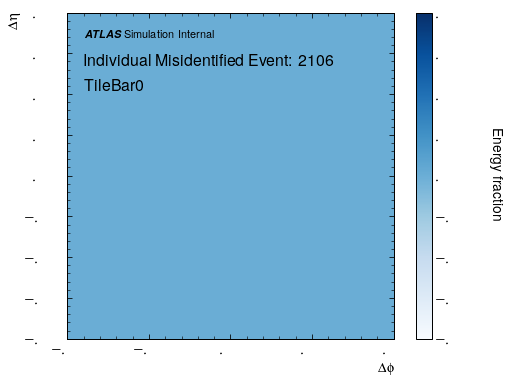

<Figure size 576x432 with 0 Axes>

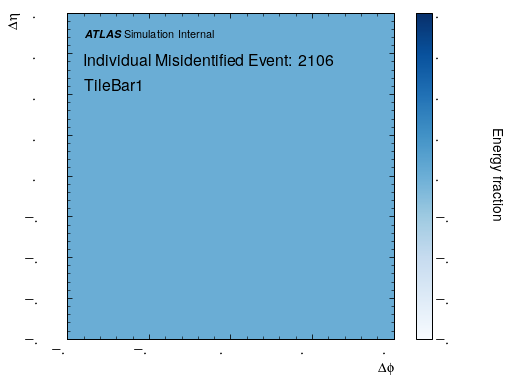

<Figure size 576x432 with 0 Axes>

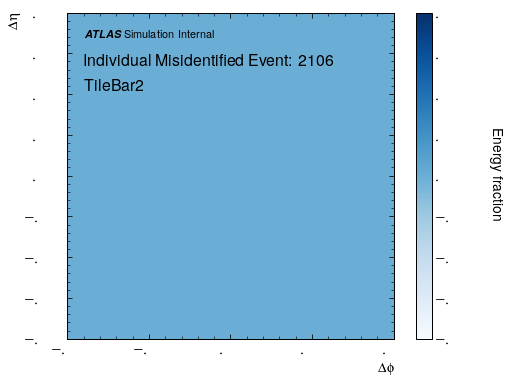

<Figure size 576x432 with 0 Axes>

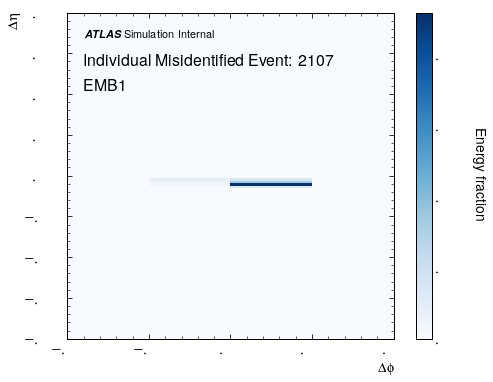

<Figure size 576x432 with 0 Axes>

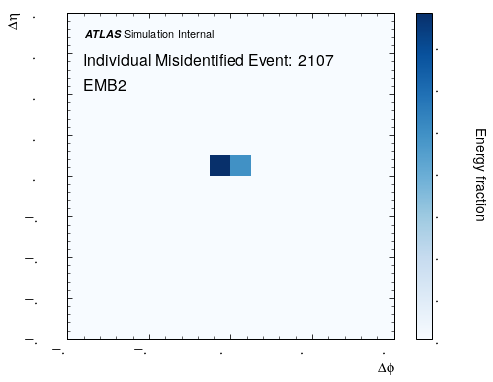

<Figure size 576x432 with 0 Axes>

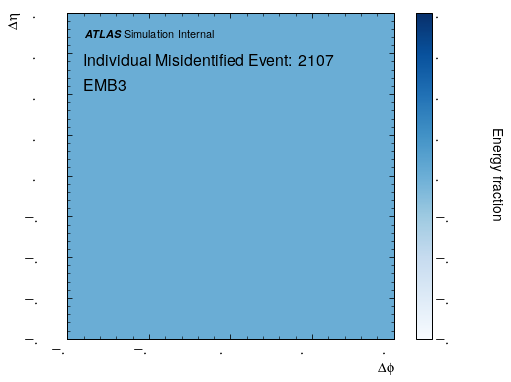

<Figure size 576x432 with 0 Axes>

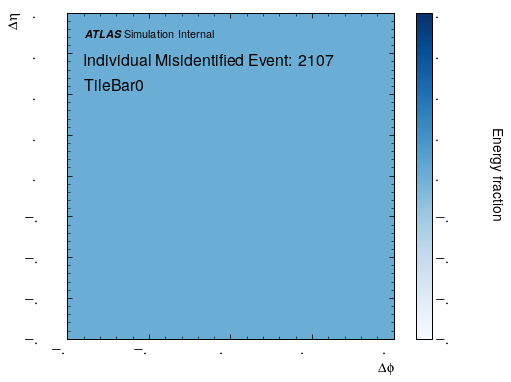

<Figure size 576x432 with 0 Axes>

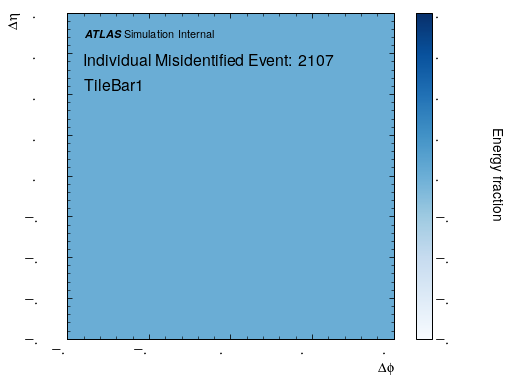

<Figure size 576x432 with 0 Axes>

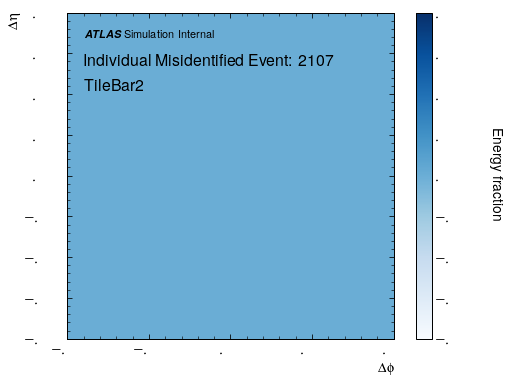

<Figure size 576x432 with 0 Axes>

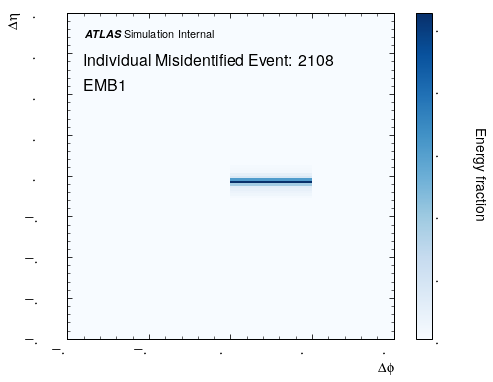

<Figure size 576x432 with 0 Axes>

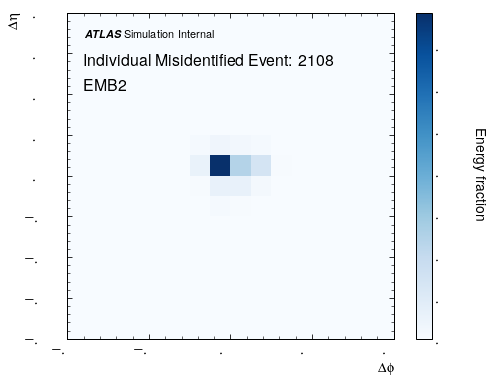

<Figure size 576x432 with 0 Axes>

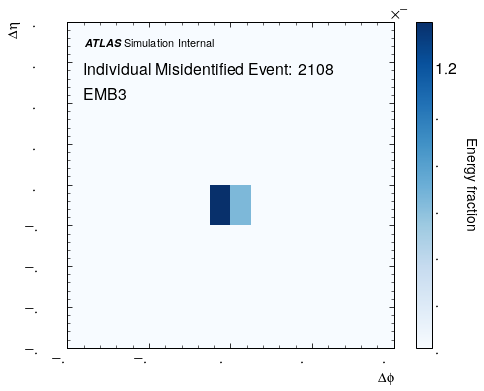

<Figure size 576x432 with 0 Axes>

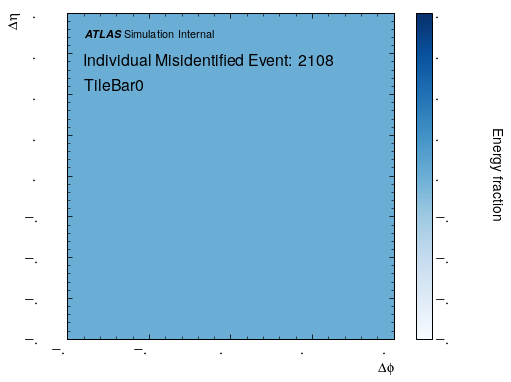

<Figure size 576x432 with 0 Axes>

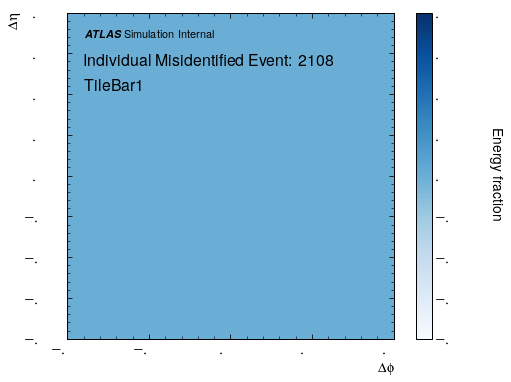

<Figure size 576x432 with 0 Axes>

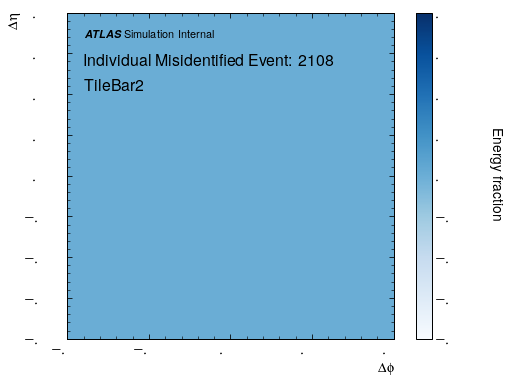

<Figure size 576x432 with 0 Axes>

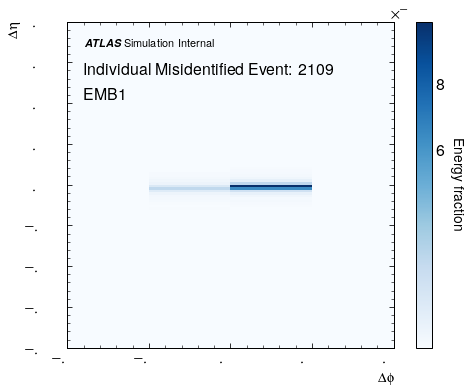

<Figure size 576x432 with 0 Axes>

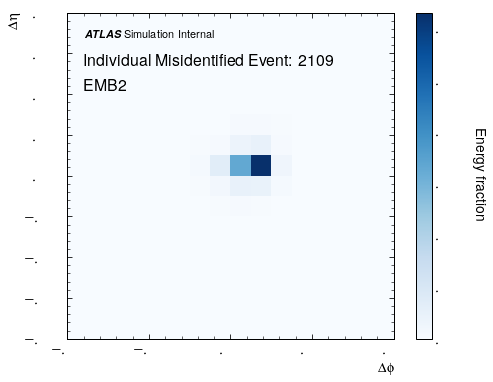

<Figure size 576x432 with 0 Axes>

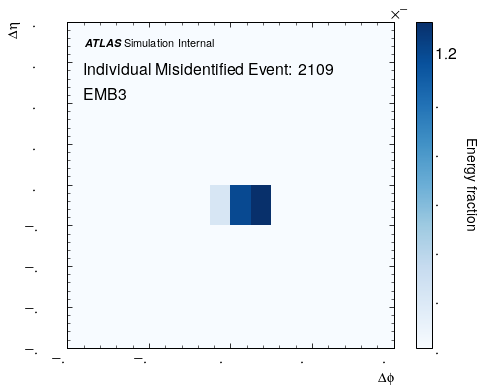

<Figure size 576x432 with 0 Axes>

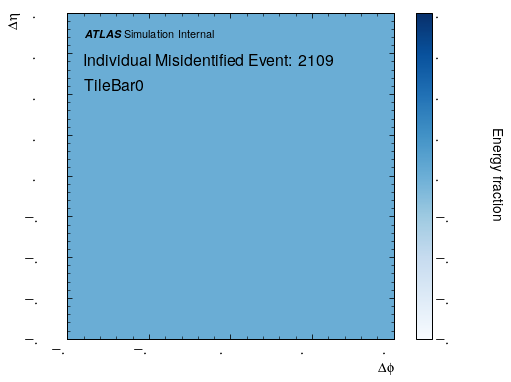

<Figure size 576x432 with 0 Axes>

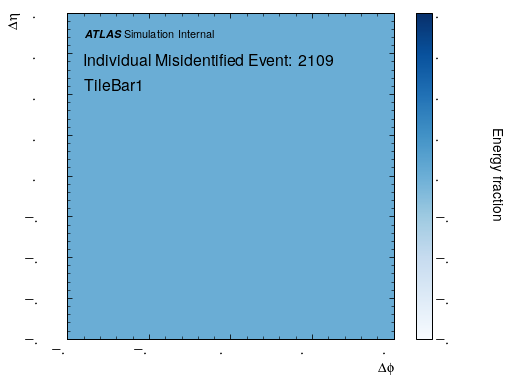

<Figure size 576x432 with 0 Axes>

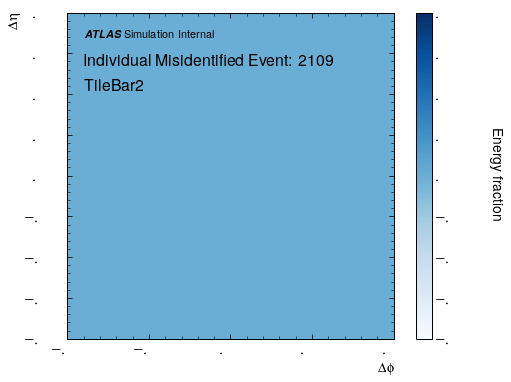

<Figure size 576x432 with 0 Axes>

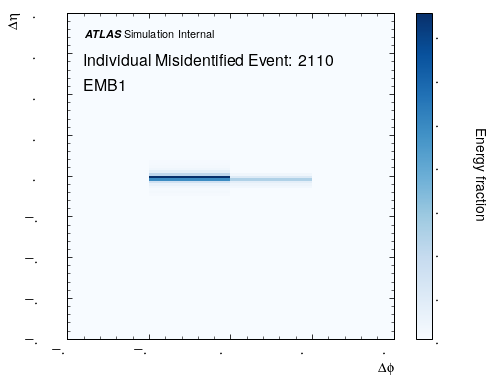

<Figure size 576x432 with 0 Axes>

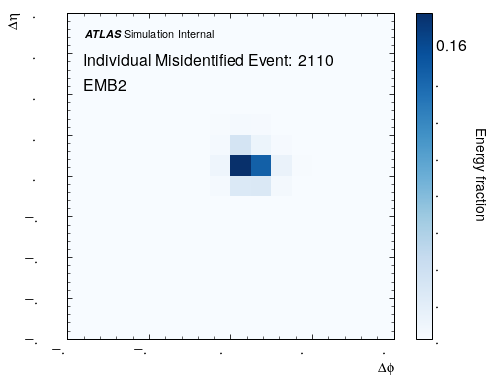

<Figure size 576x432 with 0 Axes>

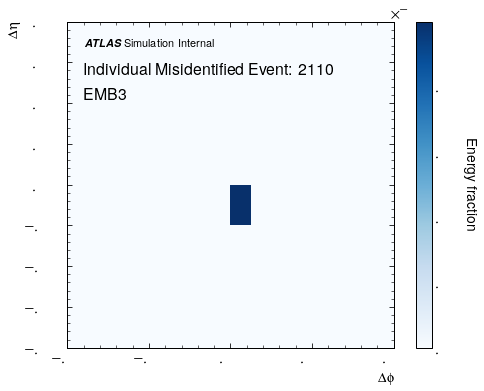

<Figure size 576x432 with 0 Axes>

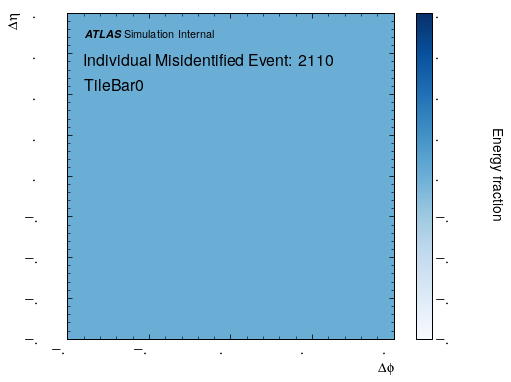

<Figure size 576x432 with 0 Axes>

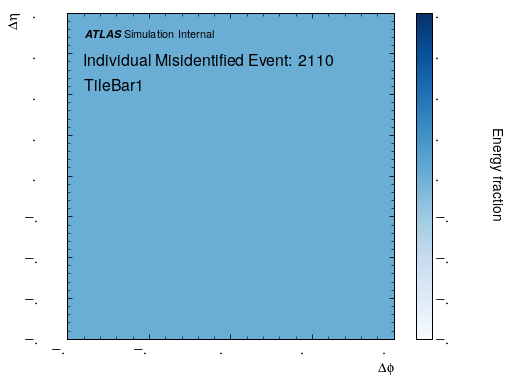

<Figure size 576x432 with 0 Axes>

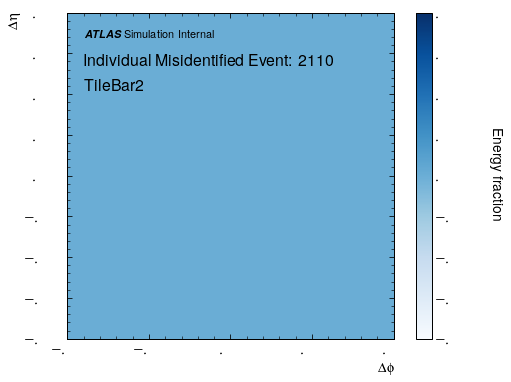

<Figure size 576x432 with 0 Axes>

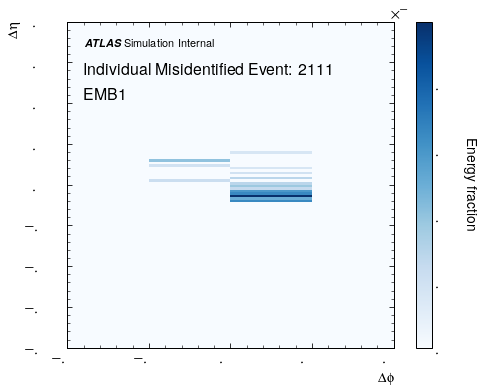

<Figure size 576x432 with 0 Axes>

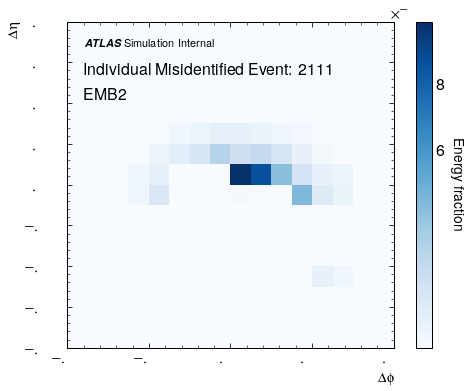

<Figure size 576x432 with 0 Axes>

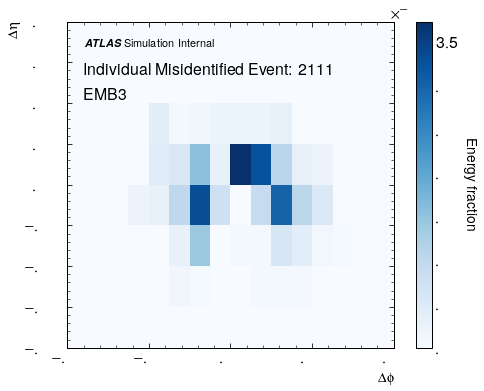

<Figure size 576x432 with 0 Axes>

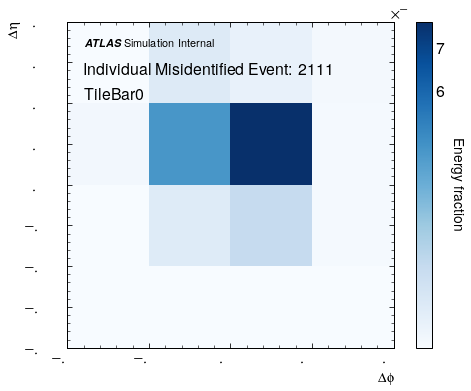

<Figure size 576x432 with 0 Axes>

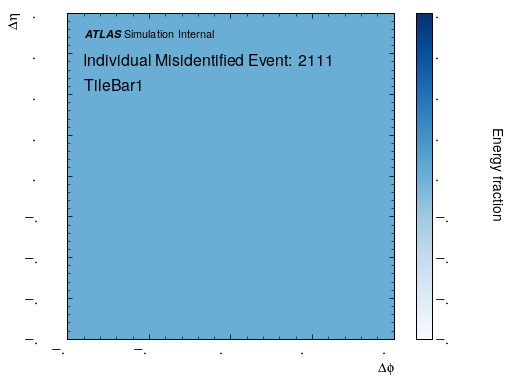

<Figure size 576x432 with 0 Axes>

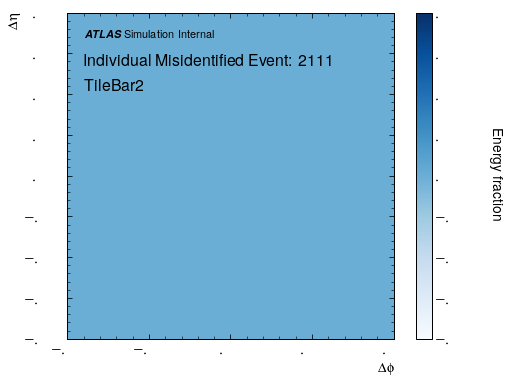

<Figure size 576x432 with 0 Axes>

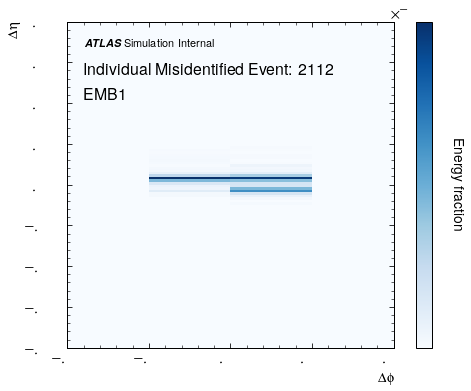

<Figure size 576x432 with 0 Axes>

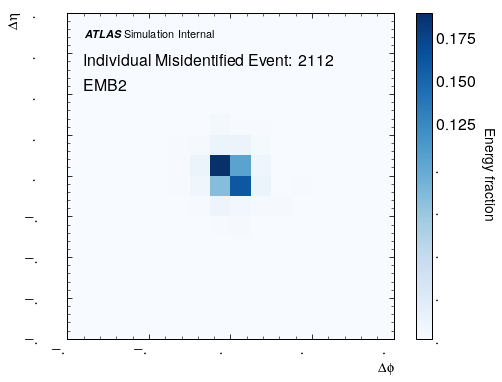

<Figure size 576x432 with 0 Axes>

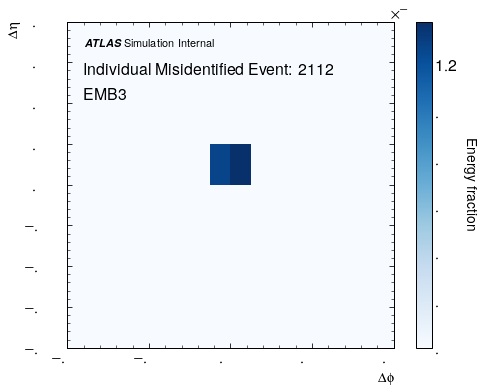

<Figure size 576x432 with 0 Axes>

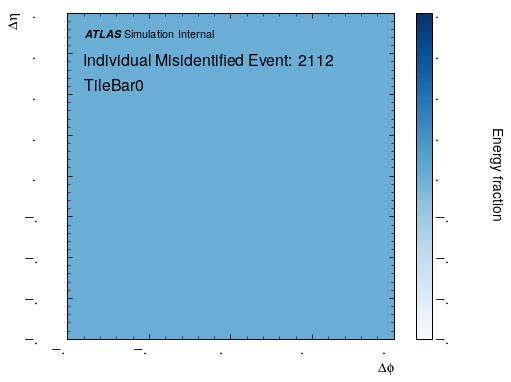

<Figure size 576x432 with 0 Axes>

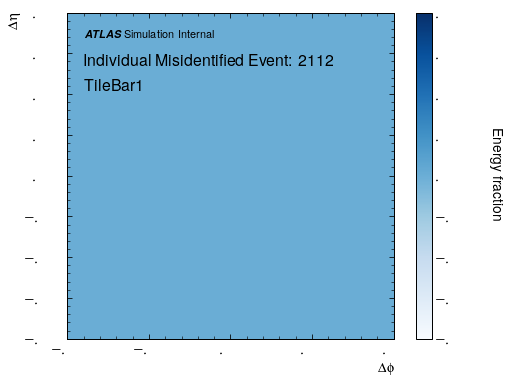

<Figure size 576x432 with 0 Axes>

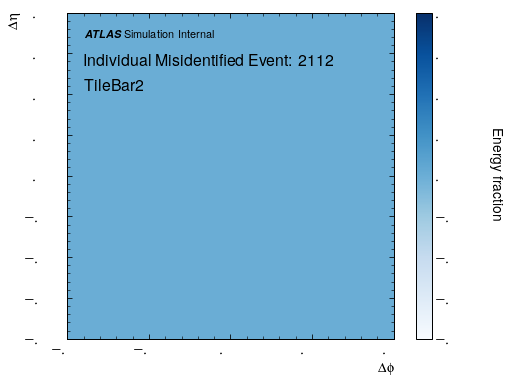

<Figure size 576x432 with 0 Axes>

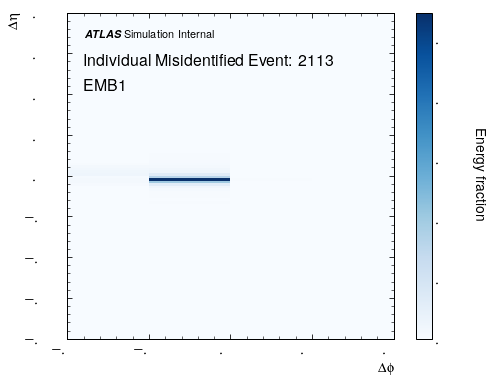

<Figure size 576x432 with 0 Axes>

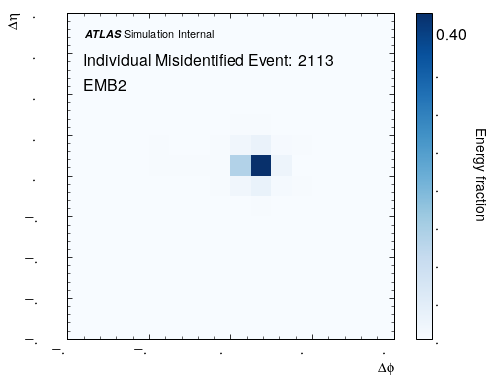

<Figure size 576x432 with 0 Axes>

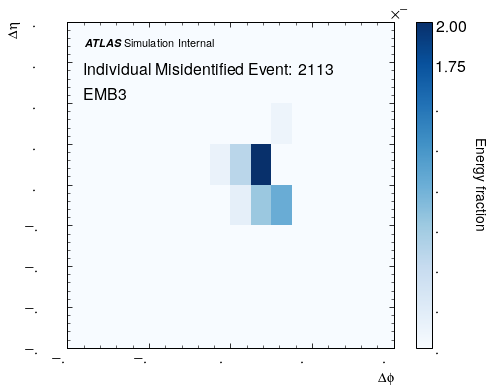

<Figure size 576x432 with 0 Axes>

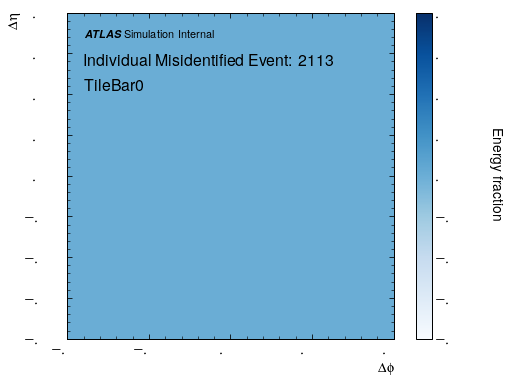

<Figure size 576x432 with 0 Axes>

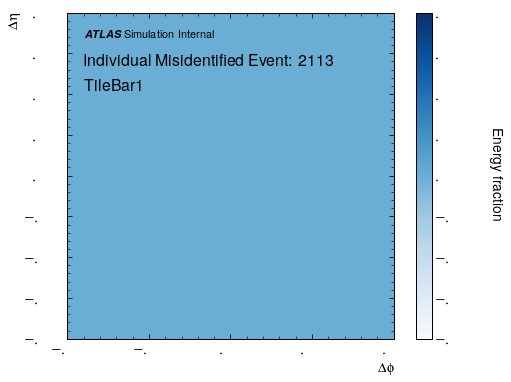

<Figure size 576x432 with 0 Axes>

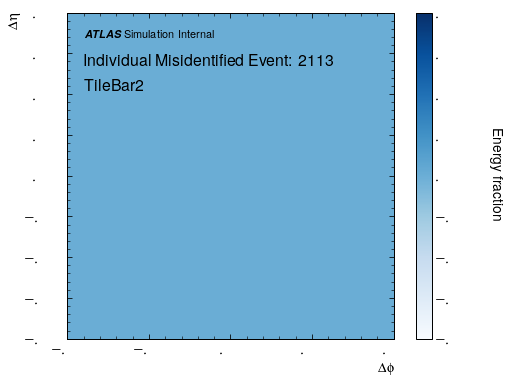

<Figure size 576x432 with 0 Axes>

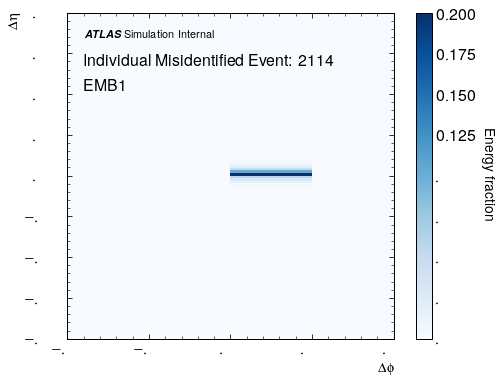

<Figure size 576x432 with 0 Axes>

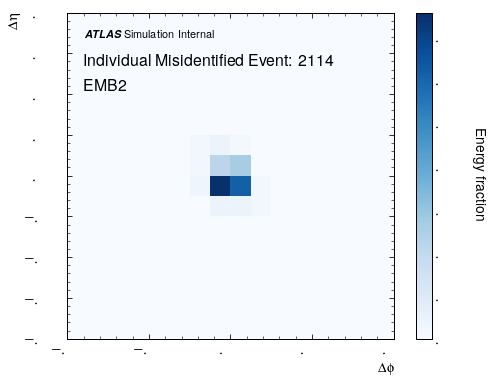

<Figure size 576x432 with 0 Axes>

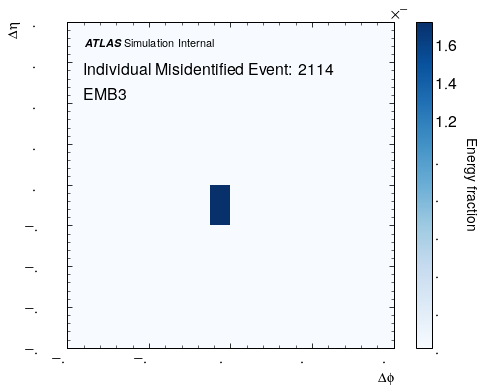

<Figure size 576x432 with 0 Axes>

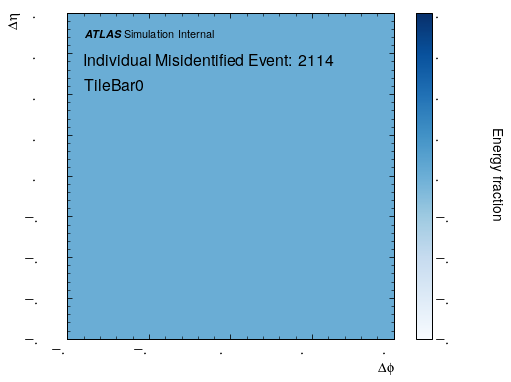

<Figure size 576x432 with 0 Axes>

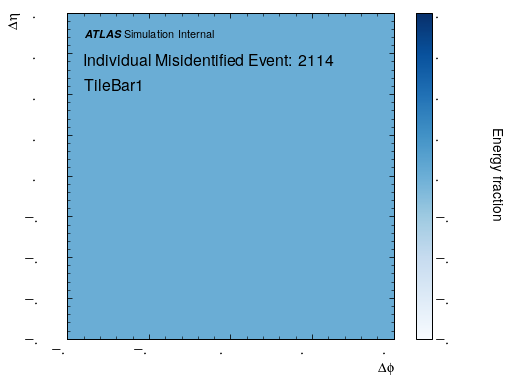

<Figure size 576x432 with 0 Axes>

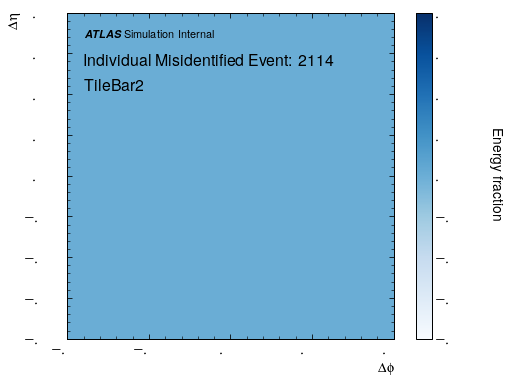

<Figure size 576x432 with 0 Axes>

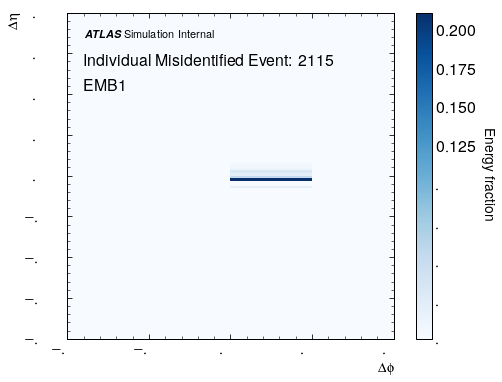

<Figure size 576x432 with 0 Axes>

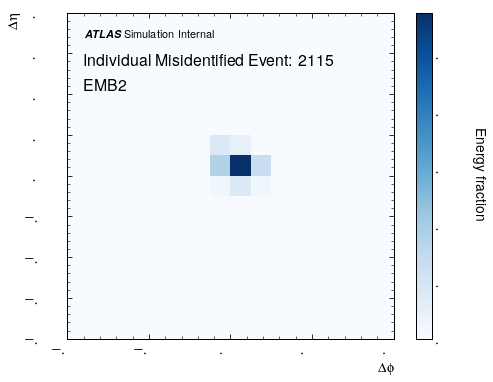

<Figure size 576x432 with 0 Axes>

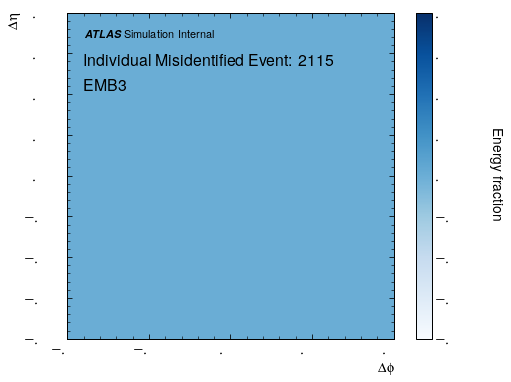

<Figure size 576x432 with 0 Axes>

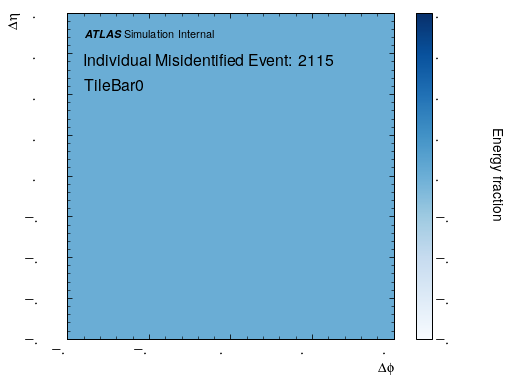

<Figure size 576x432 with 0 Axes>

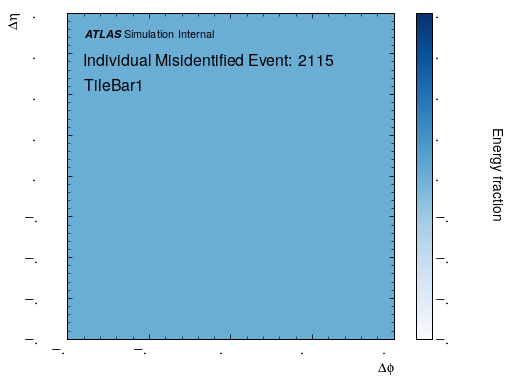

<Figure size 576x432 with 0 Axes>

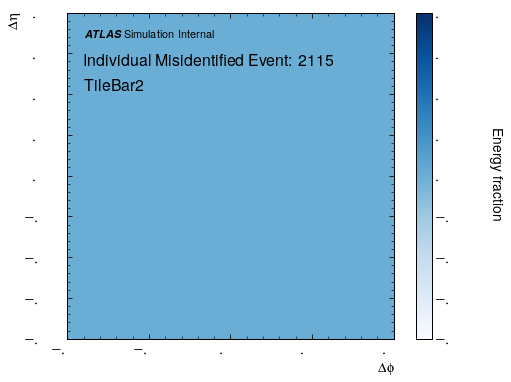

<Figure size 576x432 with 0 Axes>

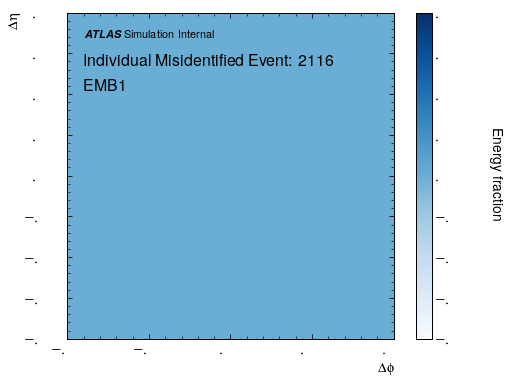

<Figure size 576x432 with 0 Axes>

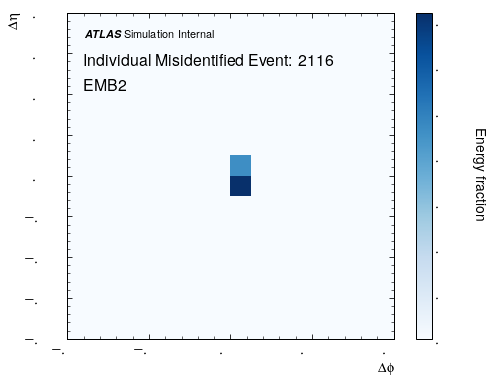

<Figure size 576x432 with 0 Axes>

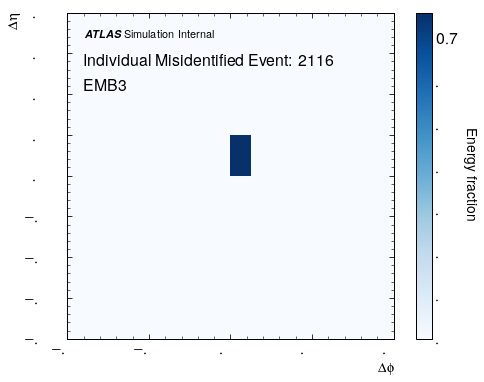

<Figure size 576x432 with 0 Axes>

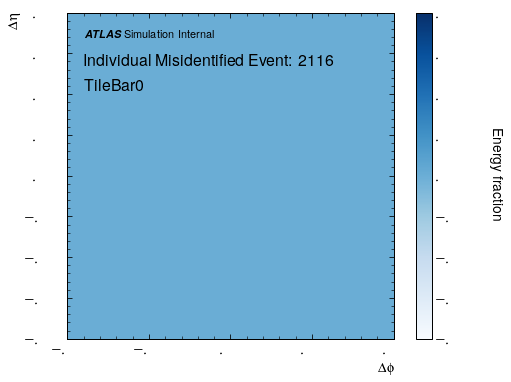

<Figure size 576x432 with 0 Axes>

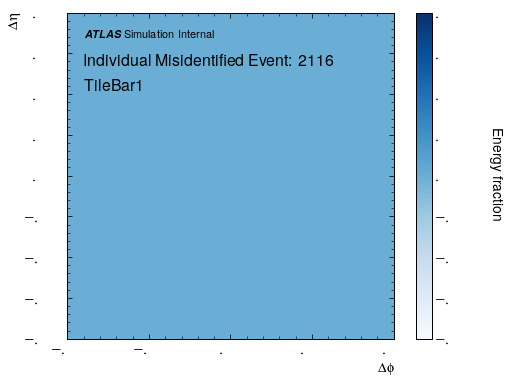

<Figure size 576x432 with 0 Axes>

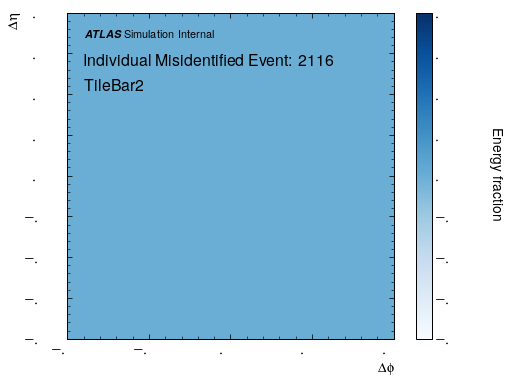

<Figure size 576x432 with 0 Axes>

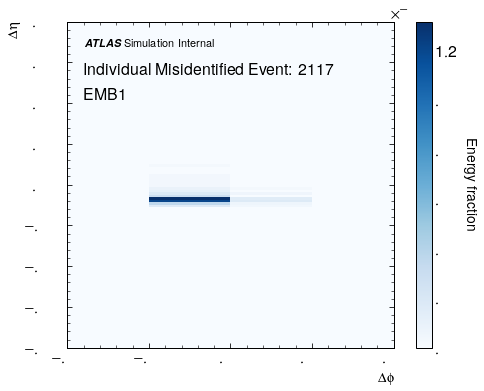

<Figure size 576x432 with 0 Axes>

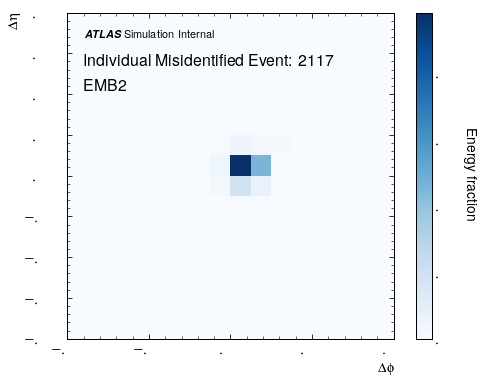

<Figure size 576x432 with 0 Axes>

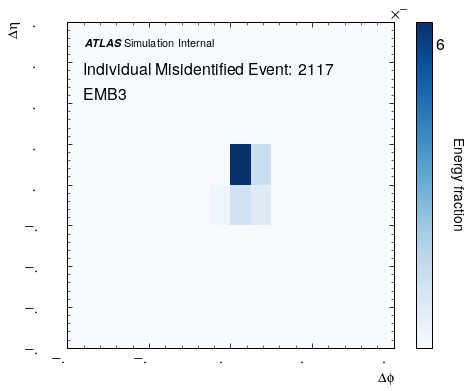

<Figure size 576x432 with 0 Axes>

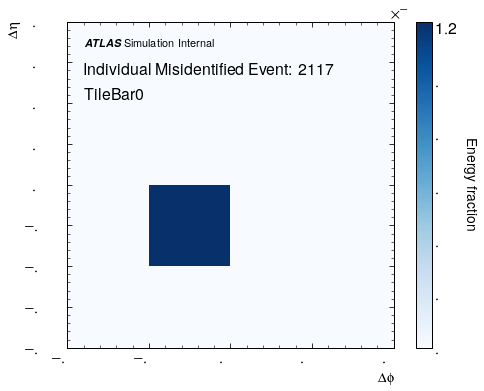

<Figure size 576x432 with 0 Axes>

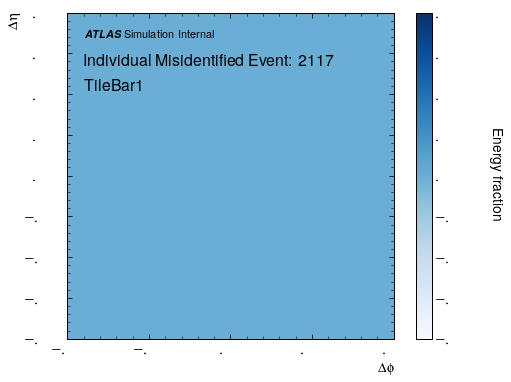

<Figure size 576x432 with 0 Axes>

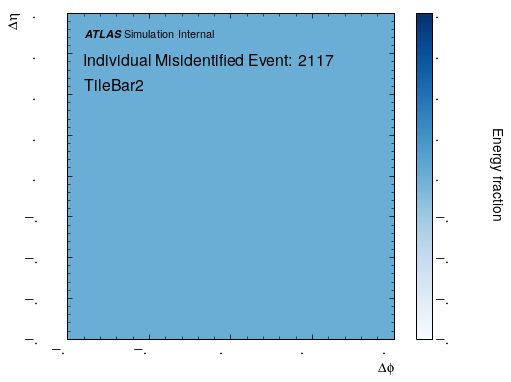

<Figure size 576x432 with 0 Axes>

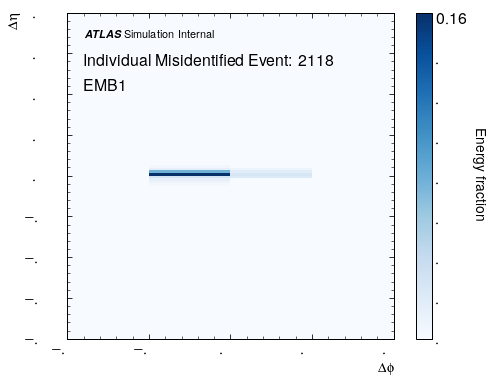

<Figure size 576x432 with 0 Axes>

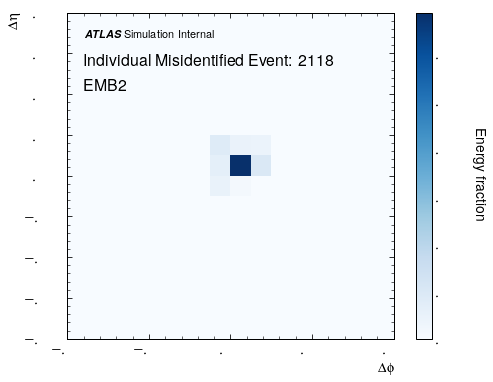

<Figure size 576x432 with 0 Axes>

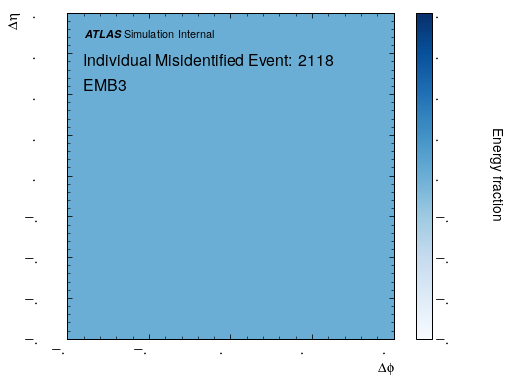

<Figure size 576x432 with 0 Axes>

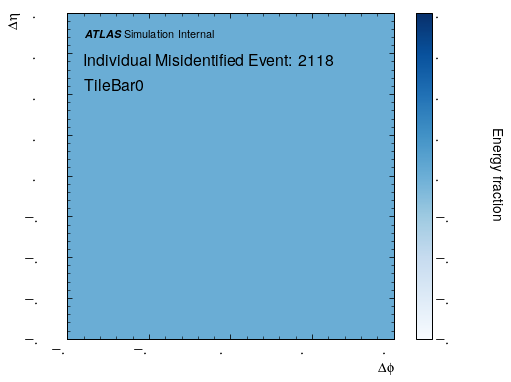

<Figure size 576x432 with 0 Axes>

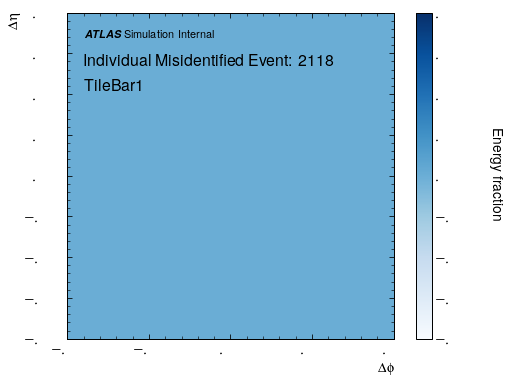

<Figure size 576x432 with 0 Axes>

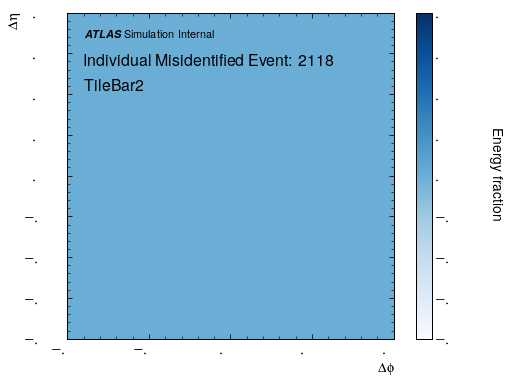

<Figure size 576x432 with 0 Axes>

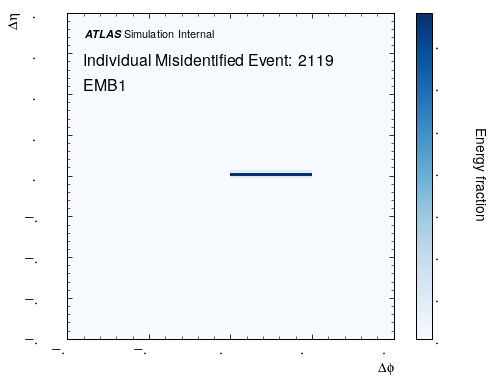

<Figure size 576x432 with 0 Axes>

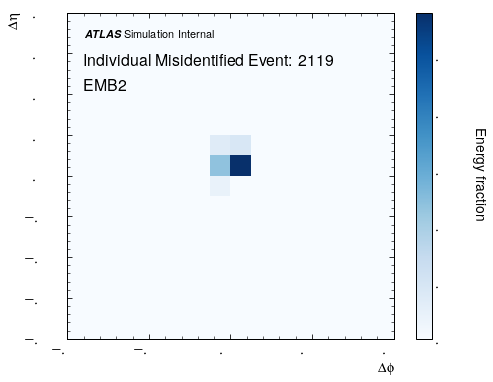

<Figure size 576x432 with 0 Axes>

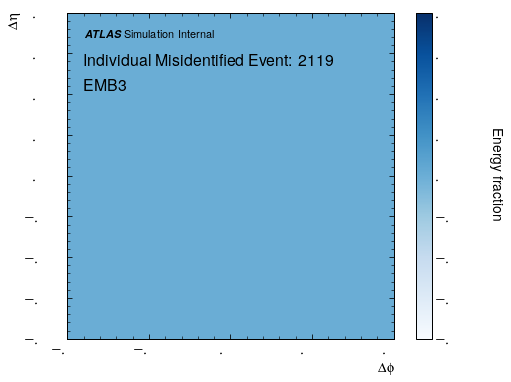

<Figure size 576x432 with 0 Axes>

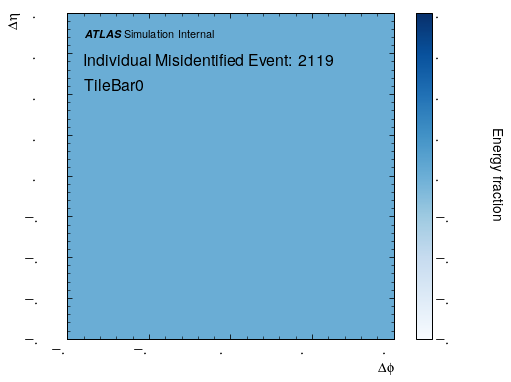

<Figure size 576x432 with 0 Axes>

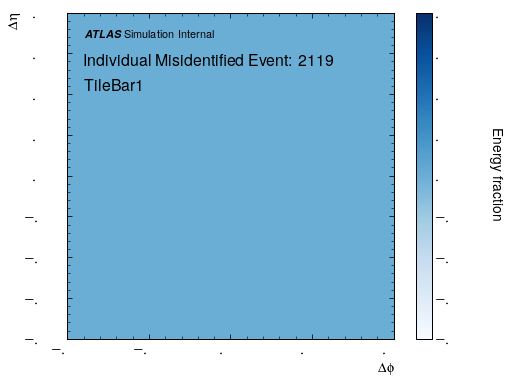

<Figure size 576x432 with 0 Axes>

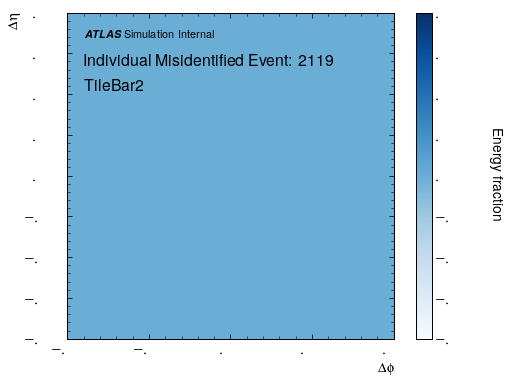

In [19]:
for i in range(2100,2120):
    render_images_ebin(i,ebin=ebin,width=width)

In [62]:
def render_images_grid_ebin(index,ebin,width=0.1,filename='', title=''):
    sel = pdata_merged.test & (pdata_merged['clusterE']<((1-width)*ebin)) & (pdata_merged['clusterE']<((1+width)*ebin))
    plt.cla(); plt.clf()
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.5)
    for i,layer in enumerate(mu.cell_meta):
        fig.patch.set_facecolor('white')
        plt.subplot(2,3,i+1)
        plt.imshow(pcells_merged[layer][sel][index], extent=[-0.2, 0.2, -0.2, 0.2],
            cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
        ampl.set_xlabel("$\Delta\phi$")
        ampl.set_ylabel("$\Delta\eta$")
#         ampl.draw_atlas_label(0.05, 0.95, simulation = True, fontsize = 11)
#         fig.axes[0].text(-0.18, 0.135, 'Individual Misidentified Event: '+str(index))
#         fig.axes[0].text(-0.18, 0.105, layer)
        plt.title(layer)
        plt.gca().tick_params(labelsize=10)
#         cbar = plt.colorbar()
#         cbar.set_label('Energy fraction', rotation=270, labelpad=20)
    if( title != '' ):
        fig.suptitle(title)
    if( filename != '' ):
        plt.savefig(plotpath+filename+'.pdf')
    plt.show()

<Figure size 576x432 with 0 Axes>

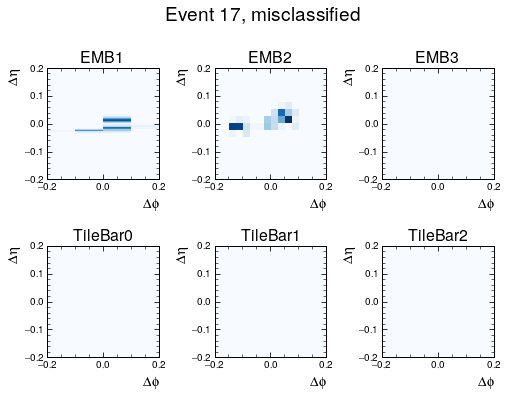

<Figure size 576x432 with 0 Axes>

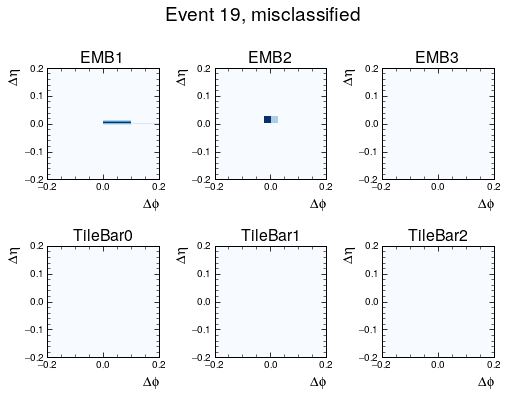

<Figure size 576x432 with 0 Axes>

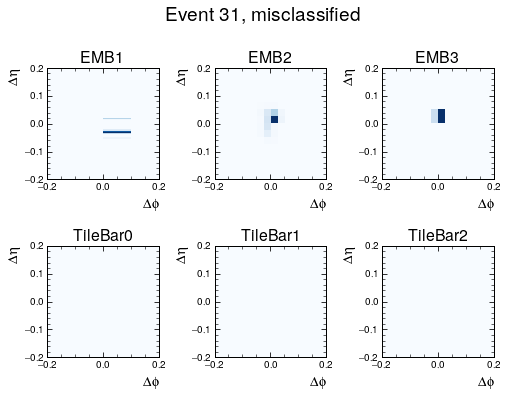

<Figure size 576x432 with 0 Axes>

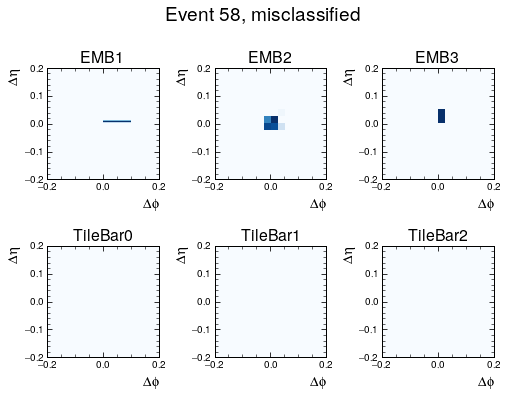

<Figure size 576x432 with 0 Axes>

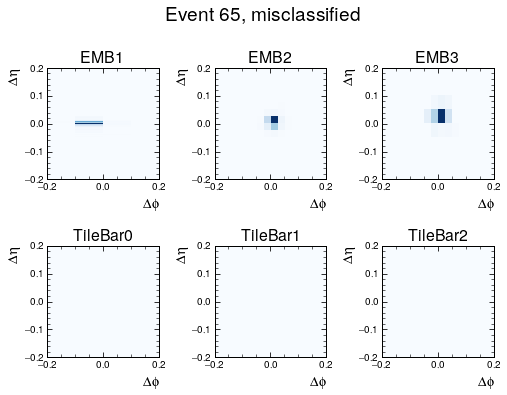

<Figure size 576x432 with 0 Axes>

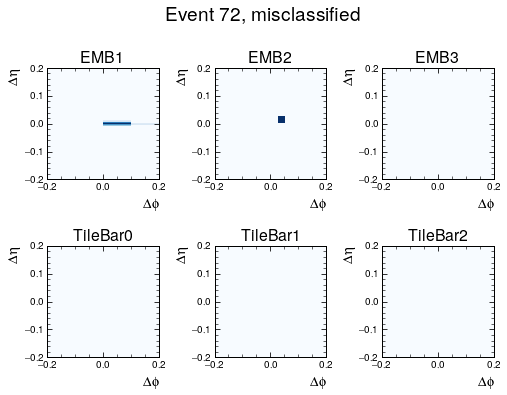

<Figure size 576x432 with 0 Axes>

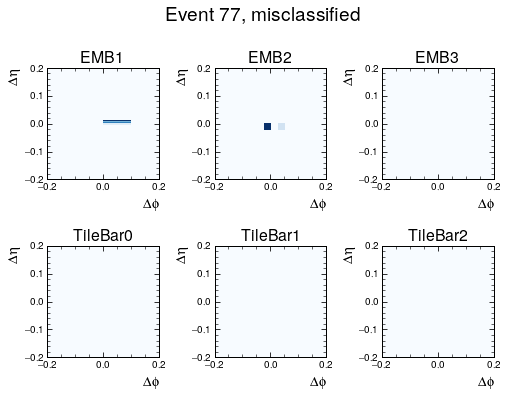

<Figure size 576x432 with 0 Axes>

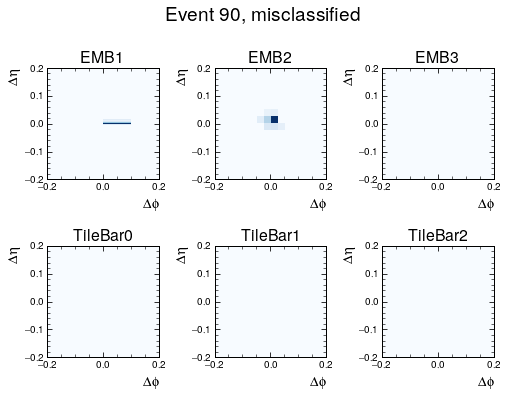

<Figure size 576x432 with 0 Axes>

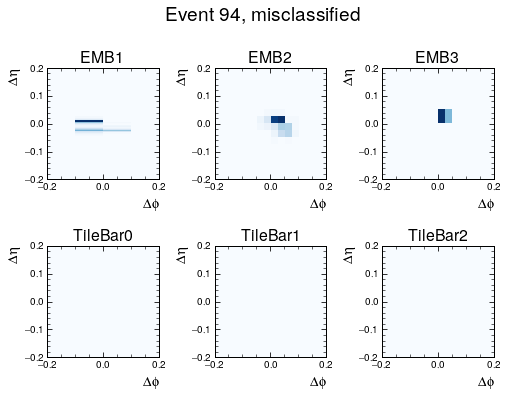

<Figure size 576x432 with 0 Axes>

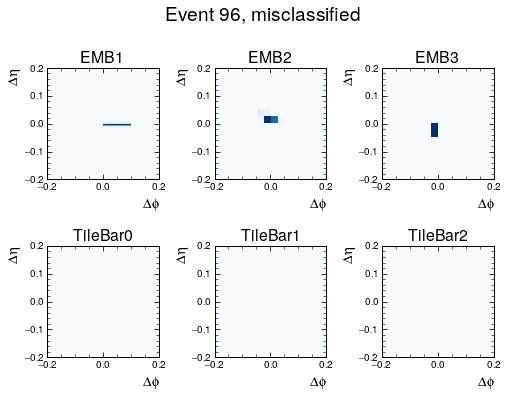

<Figure size 576x432 with 0 Axes>

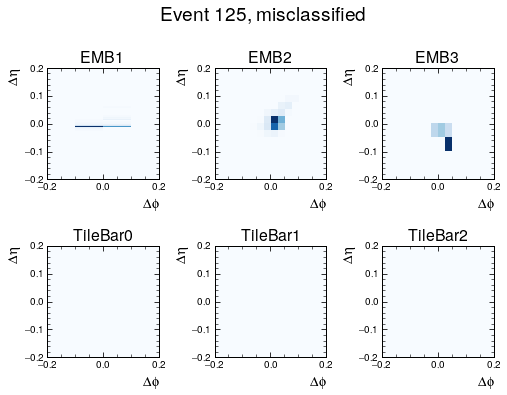

<Figure size 576x432 with 0 Axes>

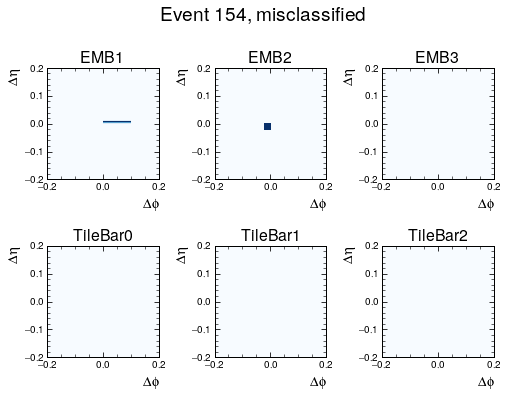

<Figure size 576x432 with 0 Axes>

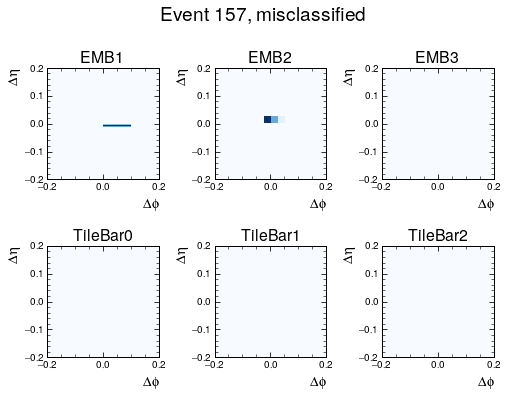

<Figure size 576x432 with 0 Axes>

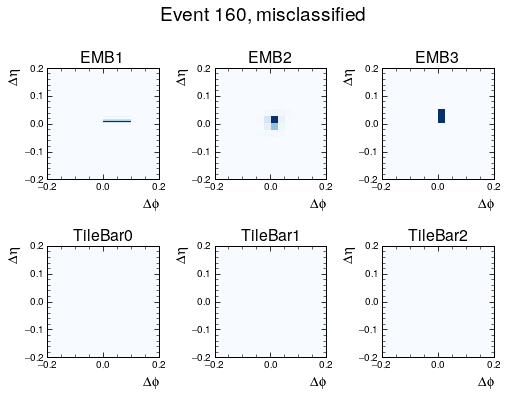

<Figure size 576x432 with 0 Axes>

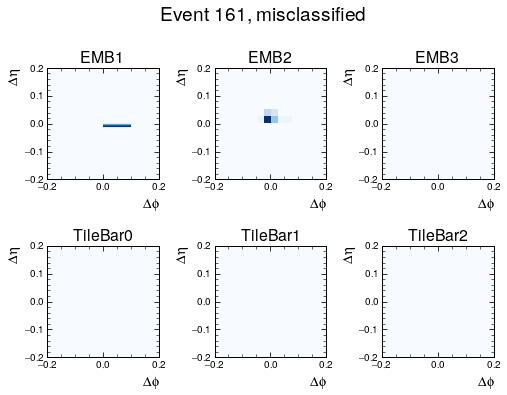

<Figure size 576x432 with 0 Axes>

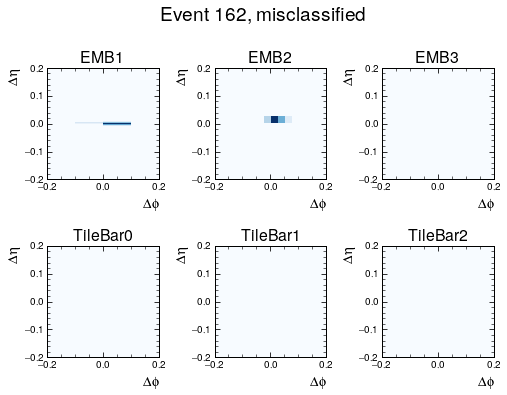

<Figure size 576x432 with 0 Axes>

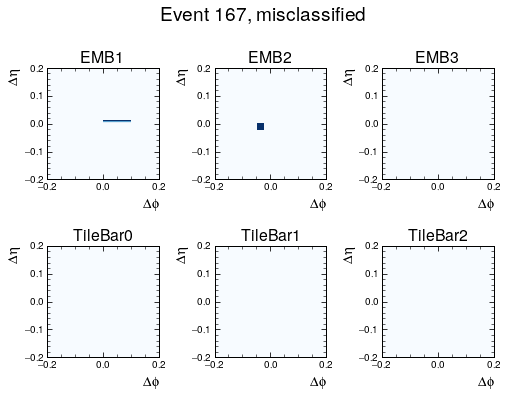

<Figure size 576x432 with 0 Axes>

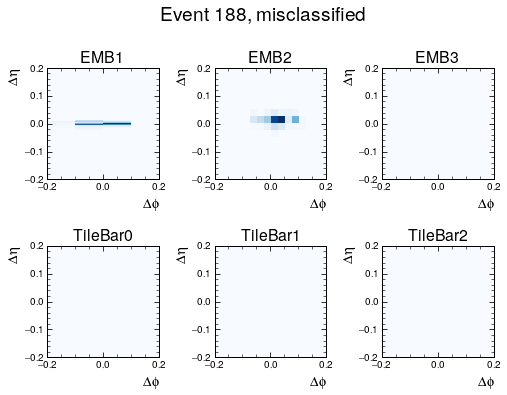

<Figure size 576x432 with 0 Axes>

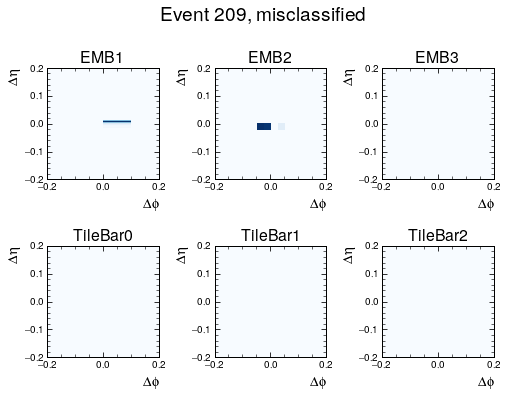

<Figure size 576x432 with 0 Axes>

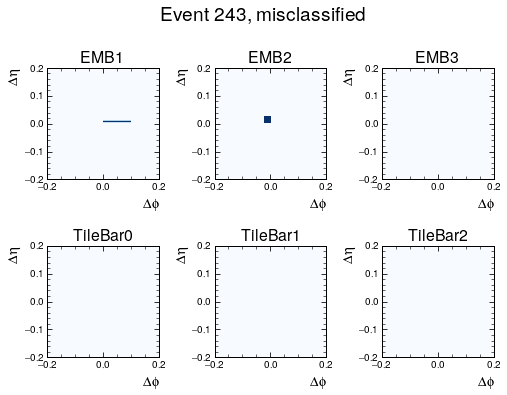

In [64]:
for i in range(20):
    render_images_grid_ebin(misclassified_events_ebin[i],
                            ebin=ebin,width=width,
                            filename='misclassified_grid_binned_100_10_'+str(i),
                            title='Event '+str(misclassified_events_ebin[i])+', misclassified')

<Figure size 576x432 with 0 Axes>

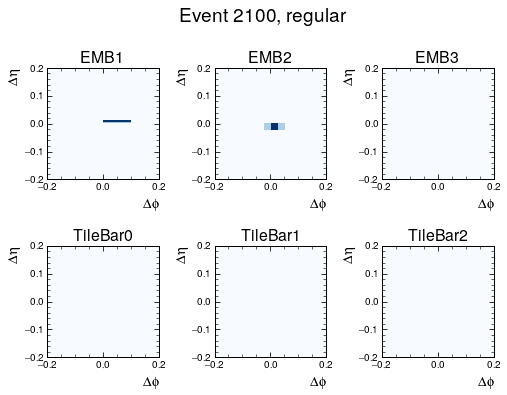

<Figure size 576x432 with 0 Axes>

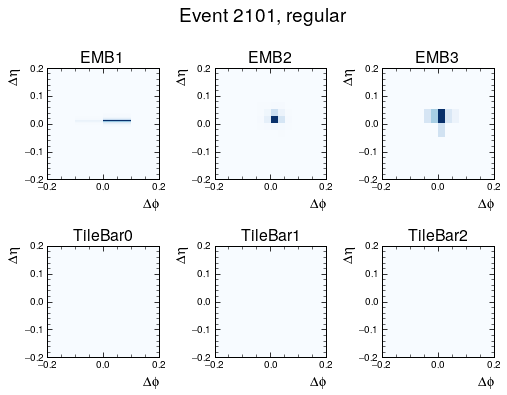

<Figure size 576x432 with 0 Axes>

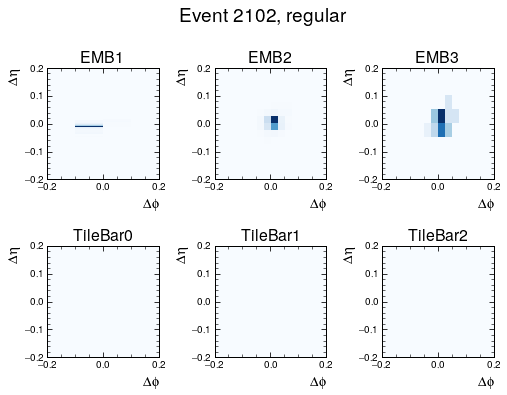

<Figure size 576x432 with 0 Axes>

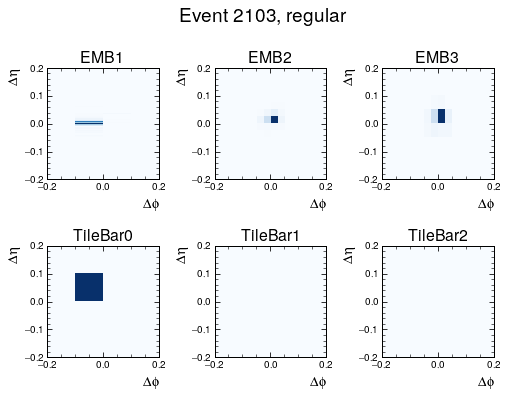

<Figure size 576x432 with 0 Axes>

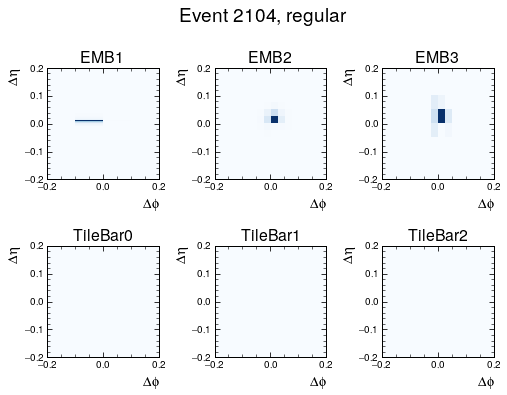

<Figure size 576x432 with 0 Axes>

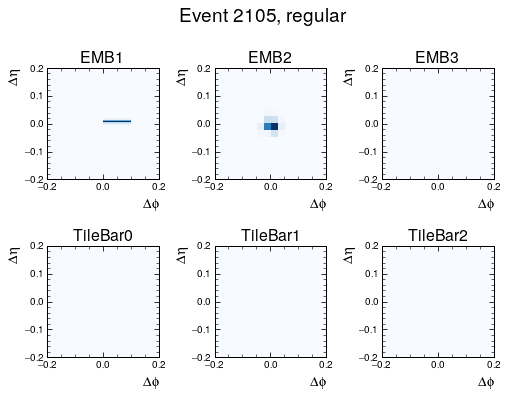

<Figure size 576x432 with 0 Axes>

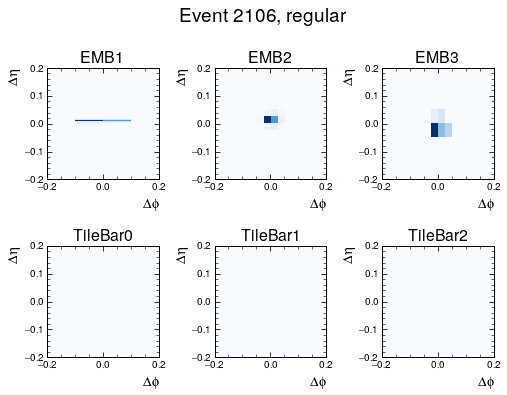

<Figure size 576x432 with 0 Axes>

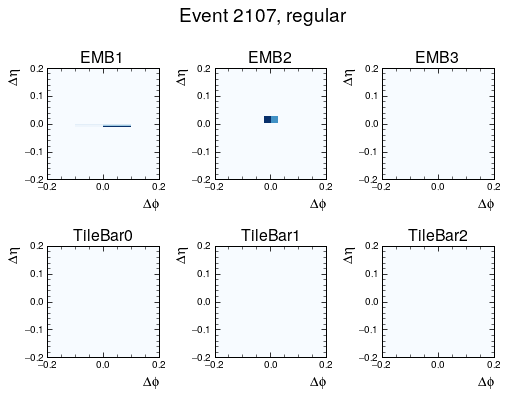

<Figure size 576x432 with 0 Axes>

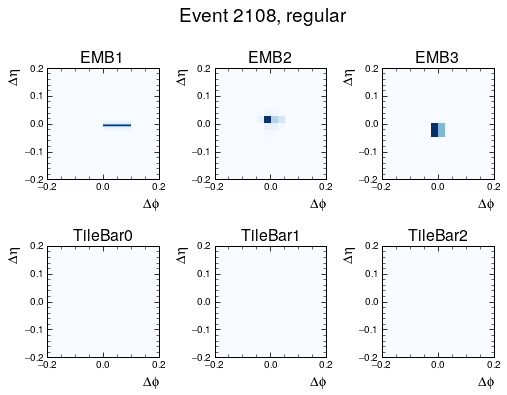

<Figure size 576x432 with 0 Axes>

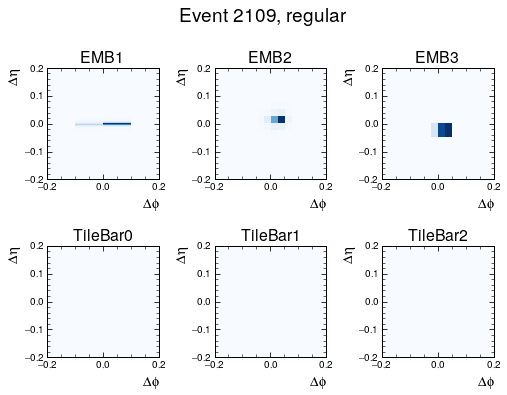

<Figure size 576x432 with 0 Axes>

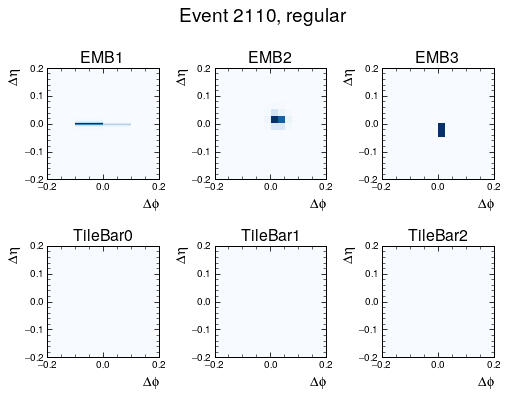

<Figure size 576x432 with 0 Axes>

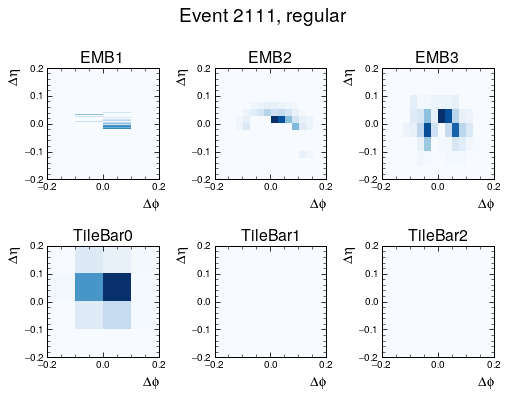

<Figure size 576x432 with 0 Axes>

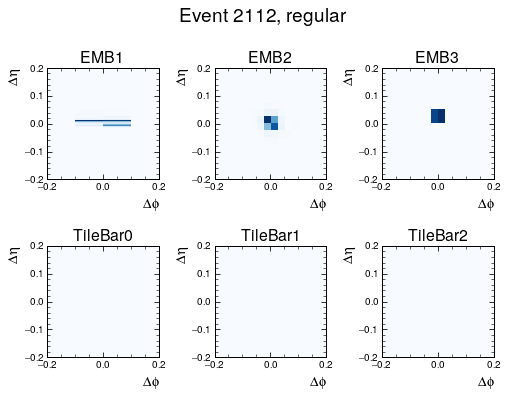

<Figure size 576x432 with 0 Axes>

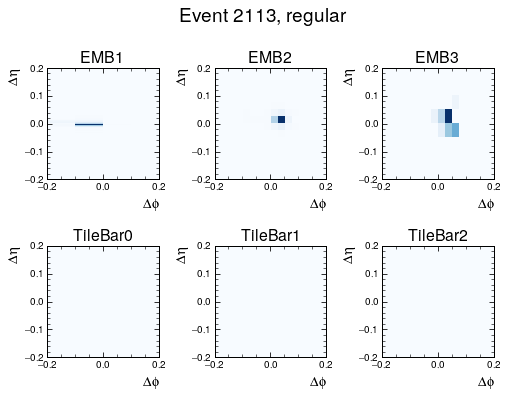

<Figure size 576x432 with 0 Axes>

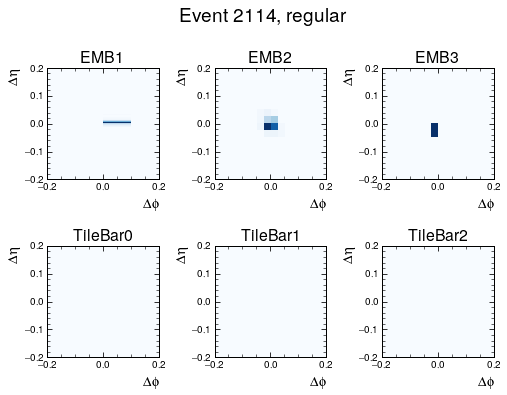

<Figure size 576x432 with 0 Axes>

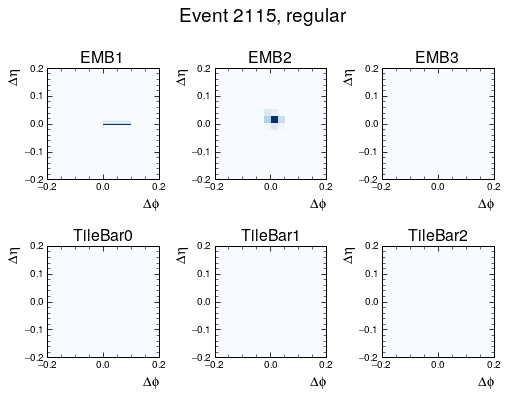

<Figure size 576x432 with 0 Axes>

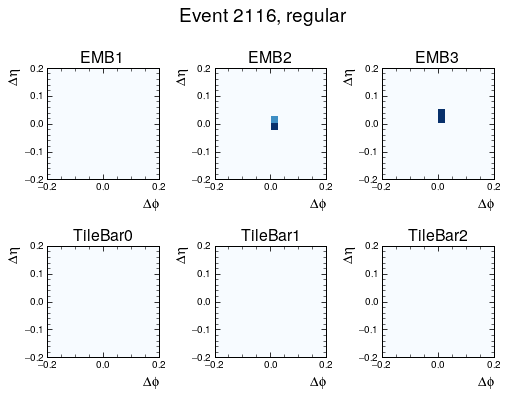

<Figure size 576x432 with 0 Axes>

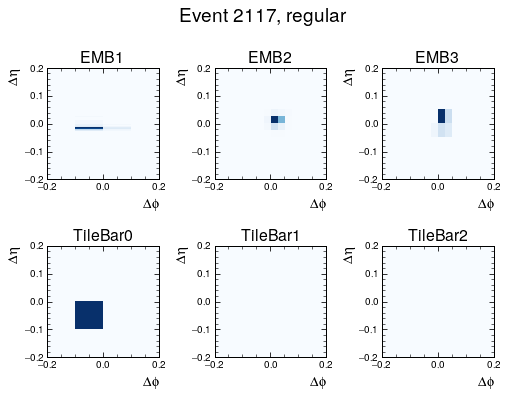

<Figure size 576x432 with 0 Axes>

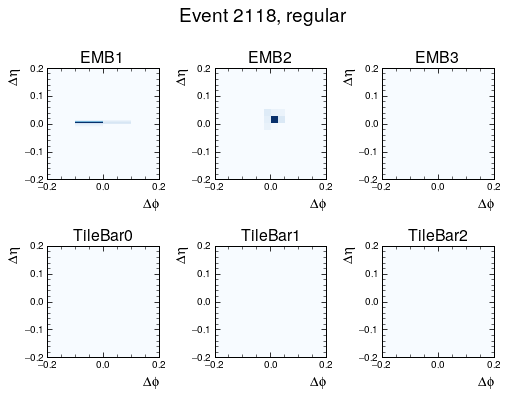

<Figure size 576x432 with 0 Axes>

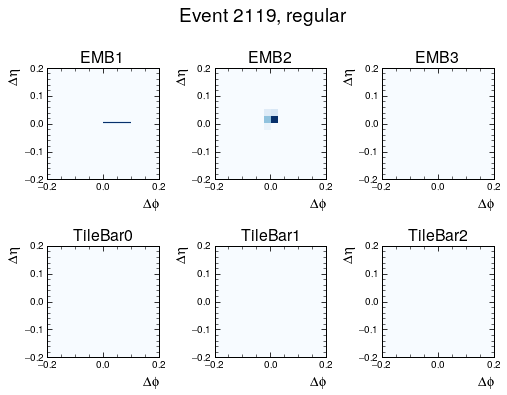

In [65]:
for i in range(2100,2120):
    render_images_grid_ebin(i,
                            ebin=ebin,width=width,
                            filename='regular_grid_binned_100_10_'+str(i),
                            title='Event '+str(i)+', regular')